## generate data

In [443]:
import os, shutil
import random
import math

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as tnf
import torch.distributions as td

import sklearn.linear_model
import sklearn.preprocessing

import copy
from pprint import pprint
import time, datetime

from collections import OrderedDict

import uncertainty_toolbox as uct

from torch_lr_finder import LRFinder
# import pyro
# import pyro.distributions as dist
# from pyro.nn import PyroModule, PyroSample

# import loss_landscapes
# import loss_landscapes.metrics


# from ax.service.ax_client import AxClient
# from ax.service.utils.instantiation import ObjectiveProperties
# from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
# from ax.modelbridge.registry import Models

# from ax.utils.notebook.plotting import render
# import plotly.io as pio
# pio.renderers.default = "png"

# import cooper

In [2]:
# %matplotlib ipympl
# %matplotlib inline
%load_ext line_profiler

In [437]:
pltparams = {
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
    'figure.titlesize': 'x-large',
    'savefig.dpi': 100,
}
# plt.style.use('default')
plt.rcParams.update(pltparams)

# sns.set(font_scale = 1.2)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
# data_path = "/mnt/beegfs/projects/power-conv/data"
random_seed=2022
saved_model_path = "/home/phan/Workspace/saved_model"

In [5]:
def set_random_seed(random_seed):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_seed)
        
def set_all_random_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# random_seed=2022
# set_all_random_seeds(random_seed)

In [6]:
# os.listdir(data_path)

In [7]:
# !tar -xzf /mnt/beegfs/projects/power-conv/data/xls.tar.gz --directory /mnt/beegfs/projects/power-conv/data/
# !tar -czvf /mnt/beegfs/projects/power-conv/data/csv.tar.gz /mnt/beegfs/projects/power-conv/data/csv

https://blog.tensorflow.org/2018/10/industrial-ai-bhges-physics-based.html

The phenomenon of fatigue crack propagation can be modeled with the Paris law. Paris law relates the rate of crack growth $\left(da/dN\right)$ to the stress intensity factor  $\left(\Delta K = \Delta\sigma\sqrt{\pi a}\right)$ through the equation below:

$\frac{da}{dN}=C(\Delta\sigma\sqrt{\pi a})^m$
\begin{align}
ln\ \frac {da}{dN} = ln\ C + m\ ln\ (\Delta\sigma\sqrt{\pi a}) = ln\ C + m\ (ln \Delta \sigma + 0.5 ln\ \pi + 0.5 ln\ a)
\end{align}

Where $a$ is the crack length, $N$ is the number of loading cycles, $\sigma$ is the stress, and $C, m$ are material properties.
Integrating the Paris law for a specific geometry and loading configuration, we arrive at the analytical formulation for the size of a crack as a function of the loading cycle as shown below:

$a(N) = \left[ N  C \left(1-\frac{m}{2}\right) \left(\Delta\sigma\sqrt{\pi}\right)^m + a_0^{1-\frac{m}{2}}\right]^\frac{2}{2-m}$

where $a_0$ is the initial crack length.
The parameters $C$ and $m$ need to be calibrated for each application with crack length $(a)$ vs loading cycles $(N)$ data

\begin{align}
\int_{N_0}^{N_f} dN = \int_{a_0}^{a_f} \frac {da} {C ( \sigma \sqrt{\pi a})^m} 
=> N |_{N_0}^{N_f} = \frac 1 {C (\sigma \sqrt \pi)^m} \int_{a_0}^{a_f} a^{-m/2} da 
=> N_f - N_0 = \frac 1 {C (\sigma \sqrt \pi)^m} \frac 1 {1 - m/2} a^{1-m/2} |_{a_0}^{a_f}
=> N_f - N_0 = \frac 1 {C (\sigma \sqrt \pi)^m} \frac 1 {1 - m/2} (a_f^{1 - m/2} - a_0^{1 - m/2})
\end{align}

In [8]:
def paris_law(a, C, m, dsigma):
    righthandside = C * dsigma**m * (np.pi * a)**(m/2)
    return righthandside

In [9]:
def cycle_to_crack(N, C, m, a0, dsigma):
    a_N = ( N*C*(1 - m/2) * (dsigma*np.pi**0.5)**m + a0**(1 - m/2) )**(2/(2 - m))
    return a_N


Text(0, 0.5, 'crack length')

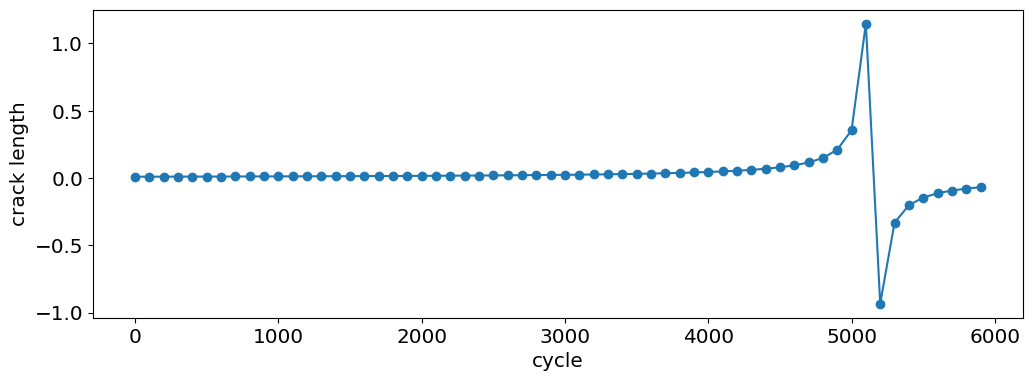

In [439]:
paris_C = np.exp(-23.5)
paris_m = 4.
paris_dsigma = 75.
paris_a0 = 0.01

N = np.arange(0., 6000., 100)
plt.figure(figsize=(12,4))
plt.plot(N, cycle_to_crack(N, paris_C, paris_m, paris_a0, paris_dsigma), marker="o")
plt.xlabel("cycle")
plt.ylabel("crack length")

/tmp/ipykernel_2882/2927881142.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(N[:], np.log(cycle_to_crack(N, paris_C, paris_m, paris_a0, paris_dsigma)), marker="o")


Text(0, 0.5, 'crack length')

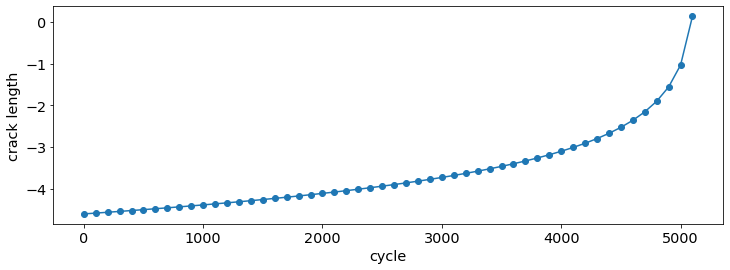

In [11]:
plt.figure(figsize=(12,4))
plt.plot(N[:], np.log(cycle_to_crack(N, paris_C, paris_m, paris_a0, paris_dsigma)), marker="o")
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

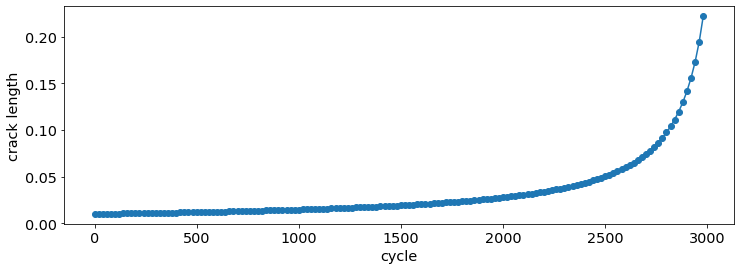

In [12]:
paris_C = np.exp(-23)
paris_m = 4.
paris_dsigma = 75.
paris_a0 = 0.01

N = np.arange(0., 3000., 20)
a = cycle_to_crack(N, paris_C, paris_m, paris_a0, paris_dsigma)
plt.figure(figsize=(12,4))
plt.plot(N, a, marker="o")
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

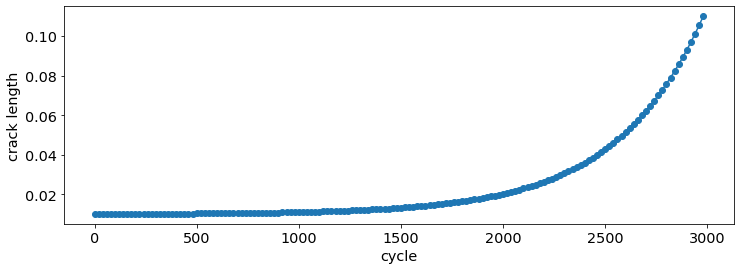

In [13]:
def power_func(offset, multi, powerbase, x):
    return offset + multi * powerbase**x


y = power_func(0.01, 1e-4, 1e3, N/max(N))
plt.figure(figsize=(12,4))
plt.plot(N, y, marker="o")
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

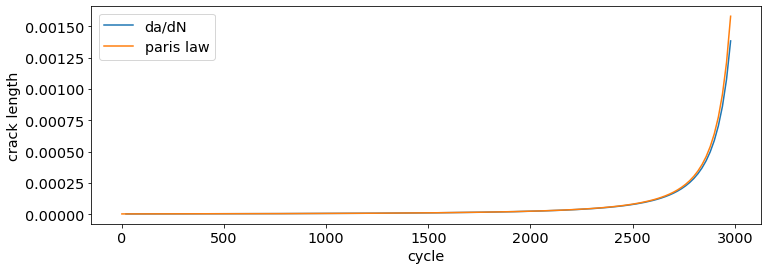

In [14]:
# dadN = (a[1:] - a[:-1]) / (N[1:] - N[:-1])
dadN = np.diff(a) / np.diff(N)
# print(np.mean(dadN), np.min(dadN), np.max(dadN))
parislaw_rightside = paris_law(a, paris_C, paris_m, paris_dsigma)

plt.figure(figsize=(12,4))
plt.plot(N[1:], dadN, label="da/dN")
plt.plot(N, parislaw_rightside, label="paris law")
# plt.ylim(0.001, 0.0015)
plt.legend()
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

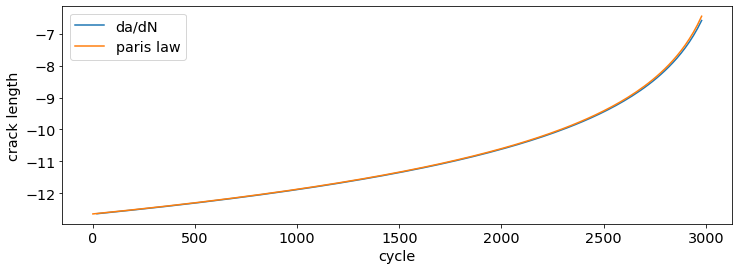

In [15]:
plt.figure(figsize=(12,4))
plt.plot(N[1:], np.log(dadN), label="da/dN")
plt.plot(N, np.log(parislaw_rightside), label="paris law")
plt.legend()
plt.xlabel("cycle")
plt.ylabel("crack length")

## preprocess

In [16]:
def generate_data(C, m, a0, dsigma, trainsize, startN=0., endN=1000., stepN=10, noise_strength=1e-3, random_seed=None):
    N = np.arange(startN, endN, stepN)
    true_target = cycle_to_crack(N, C, m, a0, dsigma)
    if random_seed: np.random.seed(random_seed)

    noise = np.random.normal(0, 1, N.shape[0]) * noise_strength
#     print(np.max(true_target) - np.min(true_target), np.mean(true_target), np.std(true_target))
    noisy_target = true_target + noise
    
    trainidx = int(N.shape[0] * trainsize)
    
    trainx = N[:trainidx]
    testx = N[trainidx:]
    trainy = noisy_target[:trainidx]
    testy = noisy_target[trainidx:]
    
    return trainx, trainy, testx, testy

def scale_data(original_data):
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaled = scaler.fit_transform(original_data)

    return scaler, scaled.squeeze()

(array([ 1.,  4.,  2., 15., 18., 16., 21., 13.,  8.,  2.]),
 array([-0.02714644, -0.02194509, -0.01674374, -0.01154239, -0.00634104,
        -0.00113969,  0.00406166,  0.00926301,  0.01446437,  0.01966572,
         0.02486707]),
 <BarContainer object of 10 artists>)

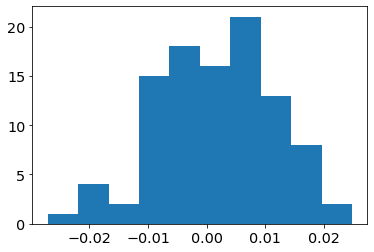

In [17]:
plt.hist(np.random.normal(0, 1, 100) * 1e-2)

In [18]:
paris_C = np.exp(-23)
paris_m = 4.
paris_dsigma = 75.
paris_a0 = 0.01

train_input, train_target, test_input, test_target = generate_data(paris_C, paris_m, paris_a0, paris_dsigma, trainsize=0.8, 
    startN=0., endN=3000., stepN=20, noise_strength=1e-3, random_seed=random_seed)


Text(0, 0.5, 'crack length')

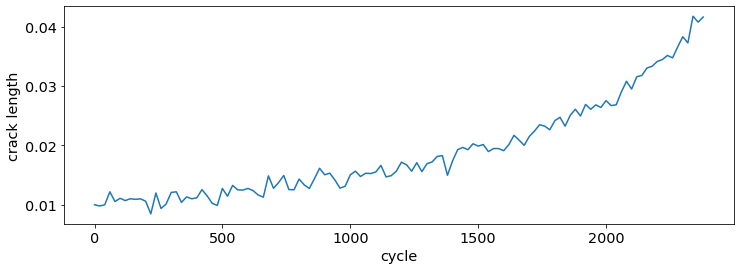

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(train_input, train_target)
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

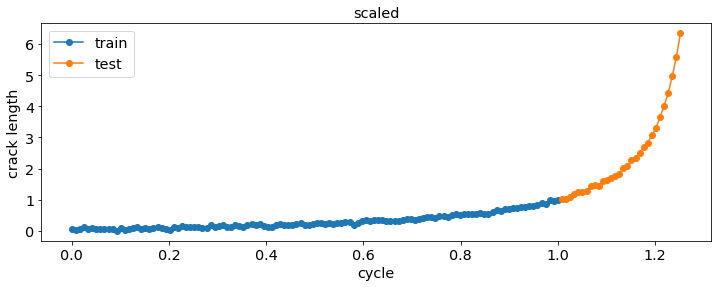

In [20]:
train_xscaler, train_xscaled = scale_data(train_input.reshape(-1, 1))
train_yscaler, train_yscaled = scale_data(train_target.reshape(-1, 1))

test_xscaled = train_xscaler.transform(test_input.reshape(-1, 1)).squeeze()
test_yscaled = train_yscaler.transform(test_target.reshape(-1, 1)).squeeze()

plt.figure(figsize=(12, 4))
plt.plot(train_xscaled, train_yscaled, marker="o", label="train")
plt.plot(test_xscaled, test_yscaled, marker="o", label="test")
plt.legend()
plt.title("scaled")
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

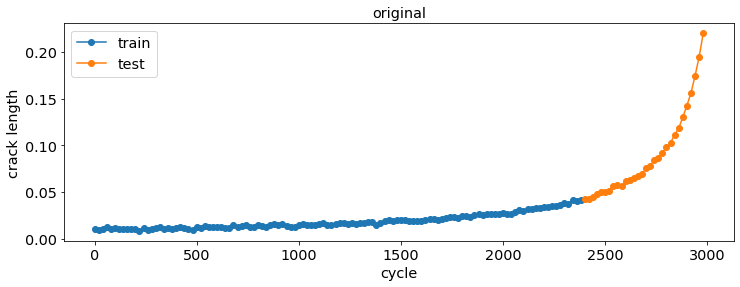

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(train_input, train_target, marker="o", label="train")
plt.plot(test_input, test_target, marker="o", label="test")
plt.legend()
plt.title("original")
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

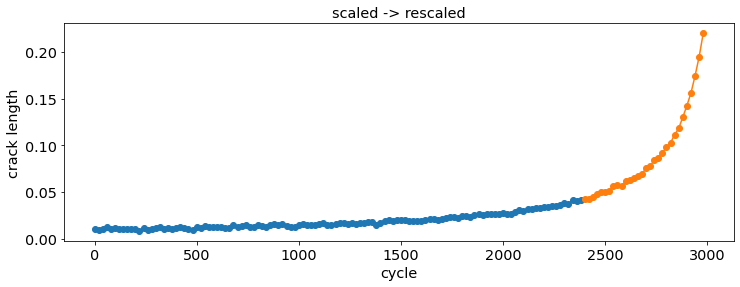

In [22]:
train_xrescaled = train_xscaler.inverse_transform(train_xscaled.reshape(-1, 1)).squeeze()
train_yrescaled = train_yscaler.inverse_transform(train_yscaled.reshape(-1, 1)).squeeze()

test_xrescaled = train_xscaler.inverse_transform(test_xscaled.reshape(-1, 1)).squeeze()
test_yrescaled = train_yscaler.inverse_transform(test_yscaled.reshape(-1, 1)).squeeze()

plt.figure(figsize=(12,4))
plt.plot(train_xrescaled, train_yrescaled, marker="o")
plt.plot(test_xrescaled, test_yrescaled, marker="o")
plt.title("scaled -> rescaled")
plt.xlabel("cycle")
plt.ylabel("crack length")

## check preprocessing

In [23]:
def plot_twinx(x, y1, label1, y2, label2, y3=None, label3=None, title=None):
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax2 = ax1.twinx()
    ax1.set_xlabel("cycle")

    plot1 = ax1.plot(x, y1, label=label1, color="blue") #, marker="o"
    ax1.set_ylabel(label1, color="blue")

    plot2 = ax2.plot(x, y2, label=label2, color="orange")#, marker="o"
    ax2.set_ylabel(label2, color="orange")
    
    if y3 is not None:
        ax2.plot(x, y3, label=label3, color="green")#, marker="o"
        ax1.plot([], [], label=label3, color="green")
    
#     hack for legend
    ax1.plot([], [], label=label2, color="orange")#, marker="o"
    ax1.legend()
    
    if title: ax1.set_title(title)
    
    return fig

Text(0, 0.5, 'crack length')

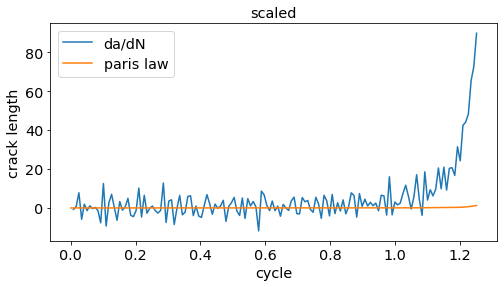

In [24]:
all_xscaled = np.concatenate([train_xscaled, test_xscaled])
all_yscaled = np.concatenate([train_yscaled, test_yscaled])

dadN_scaled = np.diff(all_yscaled) / np.diff(all_xscaled)
parislaw_scaled = paris_law(all_yscaled, paris_C, paris_m, paris_dsigma)

plt.figure(figsize=(8,4))
plt.plot(all_xscaled[1:], dadN_scaled, label="da/dN")
plt.plot(all_xscaled, parislaw_scaled, label="paris law")
plt.legend()
plt.title("scaled")
plt.xlabel("cycle")
plt.ylabel("crack length")

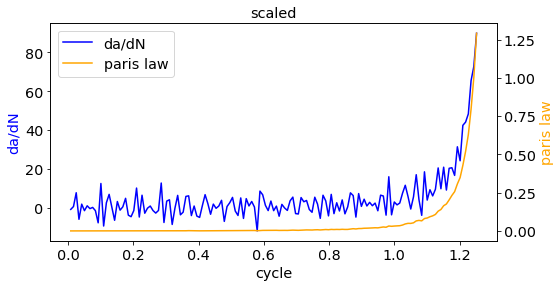

In [25]:
fig = plot_twinx(all_xscaled[1:], dadN_scaled, "da/dN", parislaw_scaled[1:], "paris law", title="scaled")

Text(0, 0.5, 'crack length')

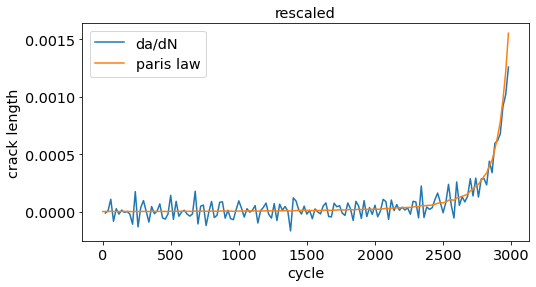

In [26]:
all_xrescaled = train_xscaler.inverse_transform(all_xscaled.reshape(-1, 1)).squeeze()
all_yrescaled = train_yscaler.inverse_transform(all_yscaled.reshape(-1, 1)).squeeze()


dadN_rescaled = np.diff(all_yrescaled) / np.diff(all_xrescaled)
parislaw_rescaled = paris_law(all_yrescaled, paris_C, paris_m, paris_dsigma)

plt.figure(figsize=(8,4))
plt.plot(all_xrescaled[1:], dadN_rescaled, label="da/dN", )
plt.plot(all_xrescaled, parislaw_rescaled, label="paris law")
plt.legend()
plt.title("rescaled")
plt.xlabel("cycle")
plt.ylabel("crack length")
# print(parislaw_rescaled)


Text(0, 0.5, 'crack length')

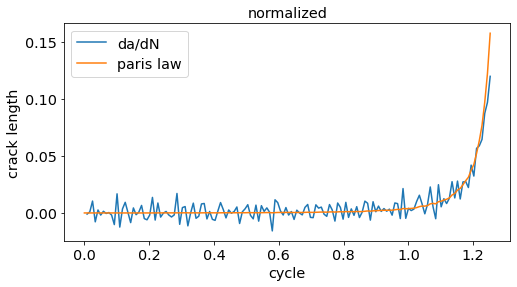

In [27]:
plt.figure(figsize=(8,4))
plt.plot(all_xscaled[1:], dadN_scaled/sum(dadN_scaled), label="da/dN")
plt.plot(all_xscaled, parislaw_scaled/sum(parislaw_scaled), label="paris law")
plt.legend()
plt.title("normalized")
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

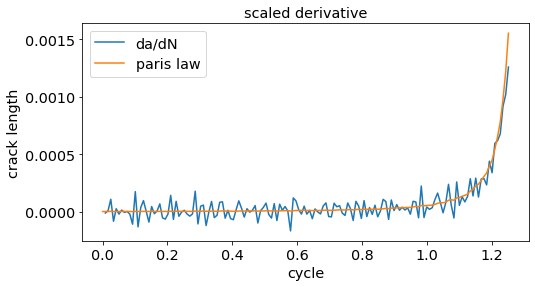

In [28]:
plt.figure(figsize=(8,4))
plt.plot(all_xscaled[1:], dadN_scaled*(max(train_target) - min(train_target))/(max(train_input) - min(train_input)), label="da/dN")
plt.plot(all_xscaled, parislaw_rescaled, label="paris law")
plt.legend()
plt.title("scaled derivative")
plt.xlabel("cycle")
plt.ylabel("crack length")
# plt.xlim(0,1)

In [29]:
totensor = lambda array:torch.tensor(array).reshape(-1, 1).float()
# train_xtensor = totensor(train_xscaled)
# train_ytensor = totensor(train_yscaled)
# test_xtensor = totensor(test_xscaled)
# test_ytensor = totensor(test_yscaled)

train_xtensor = totensor(train_input)
train_ytensor = totensor(train_target)
test_xtensor = totensor(test_input)
test_ytensor = totensor(test_target)

print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)

torch.Size([120, 1]) torch.Size([120, 1]) torch.Size([30, 1]) torch.Size([30, 1])


In [30]:
tensor_to_array = lambda tensor: tensor.detach().cpu().numpy().squeeze()
array_to_tensor = lambda array: torch.tensor(array, device=device)

class TorchMinMaxScaler:
    def fit(self, data):
        self.min = torch.min(data)
        self.max = torch.max(data)
        return self
        
    def forward(self, data):
        scaled = (data - self.min) / (self.max - self.min)
        return scaled
    
    def inverse(self, data):
        rescaled = data * (self.max - self.min) + self.min
        return rescaled

In [31]:
train_xscaler_torch = TorchMinMaxScaler().fit(train_xtensor)
train_yscaler_torch = TorchMinMaxScaler().fit(train_ytensor)

train_xtensor = train_xscaler_torch.forward(train_xtensor)
train_ytensor = train_yscaler_torch.forward(train_ytensor)
test_xtensor = train_xscaler_torch.forward(test_xtensor)
test_ytensor = train_yscaler_torch.forward(test_ytensor)

print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)


torch.Size([120, 1]) torch.Size([120, 1]) torch.Size([30, 1]) torch.Size([30, 1])


Text(0, 0.5, 'crack length')

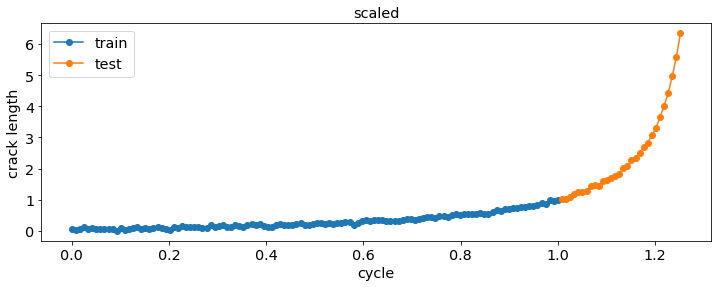

In [32]:
plt.figure(figsize=(12, 4))
plt.plot(train_xtensor, train_ytensor, marker="o", label="train")
plt.plot(test_xtensor, test_ytensor, marker="o", label="test")
plt.legend()
plt.title("scaled")
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

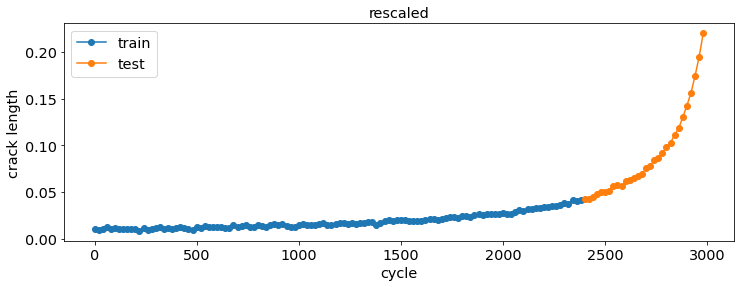

In [33]:
plt.figure(figsize=(12, 4))
plt.plot(train_xscaler_torch.inverse(train_xtensor), train_yscaler_torch.inverse(train_ytensor), marker="o", label="train")
plt.plot(train_xscaler_torch.inverse(test_xtensor), train_yscaler_torch.inverse(test_ytensor), marker="o", label="test")
plt.legend()
plt.title("rescaled")
plt.xlabel("cycle")
plt.ylabel("crack length")

In [34]:
def plot_target_prediction(traininput, traintarget, trainprediction, testinput, testtarget, testprediction=None,
    title=None, figsize=(12, 4), marker="o"):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(traininput, traintarget, label="train target", marker=marker)
    plt.plot(testinput, testtarget, label="test target", marker=marker)
    plt.plot(traininput, trainprediction, label="train prediction", marker=marker)
    
    if testprediction is not None:
        plt.plot(testinput, testprediction, marker=marker, label="test prediction")
    # plt.ylim(-0.01, 0.02)
        
    if title: plt.title(title)    
    
    plt.legend()
    plt.xlabel("cycle")
    plt.ylabel("crack length")

    return fig

## Data tensor

torch.Size([120, 1]) torch.Size([120, 1]) torch.Size([30, 1]) torch.Size([30, 1])
torch.Size([100, 1])


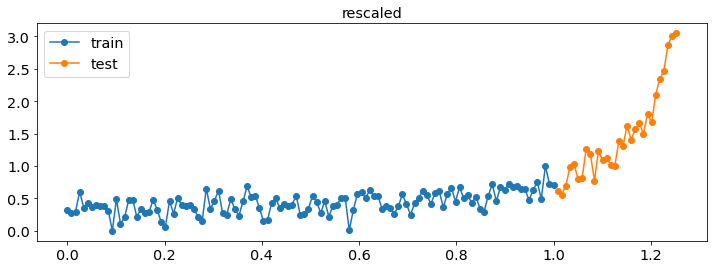

In [35]:
def sample_physics_points(xmin, xmax, xstep):
    return torch.linspace(xmin, xmax, steps=xstep).reshape(-1, 1).requires_grad_(True).to(device)                

def generate_data_tensor():
    paris_C = np.exp(-23)
    paris_m = 4.
    paris_dsigma = 75.
    paris_a0 = 0.01

    train_input, train_target, test_input, test_target = generate_data(paris_C, paris_m, paris_a0, paris_dsigma, trainsize=0.8, 
        startN=0., endN=3000., stepN=20, noise_strength=1e-2, random_seed=random_seed)

    # train_xtensor = totensor(train_input)
    # train_ytensor = totensor(train_target)
    # test_xtensor = totensor(test_input)
    # test_ytensor = totensor(test_target)

    # print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)

    train_xscaler_torch = TorchMinMaxScaler().fit(totensor(train_input))
    train_yscaler_torch = TorchMinMaxScaler().fit(totensor(train_target))

    train_xtensor = train_xscaler_torch.forward(totensor(train_input))
    train_ytensor = train_yscaler_torch.forward(totensor(train_target))
    test_xtensor = train_xscaler_torch.forward(totensor(test_input))
    test_ytensor = train_yscaler_torch.forward(totensor(test_target))

    print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)
    
    fig = plt.figure(figsize=(12, 4))
    # plt.plot(train_xscaler_torch.inverse(train_xtensor), train_yscaler_torch.inverse(train_ytensor), marker="o", label="train")
    # plt.plot(train_xscaler_torch.inverse(test_xtensor), train_yscaler_torch.inverse(test_ytensor), marker="o", label="test")
    plt.plot(train_xtensor, train_ytensor, marker="o", label="train")
    plt.plot(test_xtensor, test_ytensor, marker="o", label="test")
    plt.legend()
    plt.title("rescaled")
    
    return train_xtensor, train_ytensor, test_xtensor, test_ytensor, fig

train_xtensor, train_ytensor, test_xtensor, test_ytensor, fig = generate_data_tensor()

min_xphysics = min(min(train_xtensor), min(test_xtensor)).detach().item()
max_xphysics = max(max(train_xtensor), max(test_xtensor)).detach().item()
# min_xphysics = min(test_xtensor).detach().item()
# max_xphysics = max(test_xtensor).detach().item()
physics_xtensor = sample_physics_points(min_xphysics, max_xphysics, xstep=100)
print(physics_xtensor.shape)

## regular neural network

In [36]:
class FullyConnected(nn.Module):
    "Defines a fully connected neural network"
    def __init__(self, layer_size, activation=nn.Tanh):
        super().__init__()
#         activation = nn.Tanh
#         activation = nn.ReLU
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-2], layer_size[-1])
        )
        
    def forward(self, inpt):
        # outpt = inpt
        # for layer in self.layers:
        #     outpt = layer(outpt)
        
        # enforce positive value by model the ln and take exp
#         return torch.exp(outpt)
        return self.layers(inpt)
    
model = FullyConnected([1, 16, 8, 1])
model(torch.rand(2, 1)).shape

torch.Size([2, 1])

In [37]:
class FullyConnectedExp(nn.Module):
    "Defines a fully connected neural network"
    def __init__(self, layer_size, activation=nn.Tanh):
        super().__init__()
#         activation = nn.Tanh
#         activation = nn.ReLU
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-2], layer_size[-1])
        )
        
    def forward(self, inpt):
#         outpt = inpt
#         for layer in self.layers:
#             outpt = layer(outpt)
        
#         # enforce positive value by model the ln and take exp
        return torch.exp(self.layers(inpt))

model = FullyConnectedExp([1, 16, 8, 1])
model(torch.rand(2, 1)).shape

torch.Size([2, 1])

In [38]:
def predict_model(model, inputdata, targetdata=None):
    model.eval()
    loss = None
    
    with torch.no_grad():
        outputdata = model(inputdata.to(device))
#         predictions = outputdata
        if targetdata is not None:
            loss = tnf.mse_loss(outputdata, targetdata.to(device)).detach().item()
        
    return outputdata.detach().cpu(), loss

## train regular neural network

In [39]:
def train_model(model, traininput, trainlabel, epochs=5):
#     optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    losses = []
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
        outputdata = model(traininput)
#         predictions = outputdata[0]
#         print(f"{predictions.shape=}, {trainlabel.shape=}")
        loss = tnf.mse_loss(outputdata, trainlabel)
        
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
        losses.append(loss.detach().item())
        
        if epochs < 10 or epoch % (epochs//10) == 0:
            print(f"Epoch {epoch+1} loss = {loss}")
            
    return losses

Epoch 1 loss = 0.4840499460697174
Epoch 11 loss = 0.2226152867078781
Epoch 21 loss = 0.18326106667518616
Epoch 31 loss = 0.16242343187332153
Epoch 41 loss = 0.13643649220466614
Epoch 51 loss = 0.10841276496648788
Epoch 61 loss = 0.0654929131269455
Epoch 71 loss = 0.03900492563843727
Epoch 81 loss = 0.03254561871290207
Epoch 91 loss = 0.029444558545947075


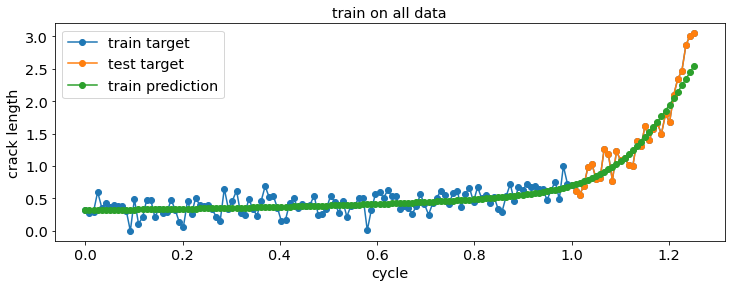

In [40]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
# model = nn.Linear(1,1).to(device)
losses = train_model(model, torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), epochs=100)

train_predictions, _ = predict_model(model, torch.cat([train_xtensor, test_xtensor]))
# test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), train_predictions, 
                       test_xtensor, test_ytensor, title="train on all data")
# print(f"{test_loss = }")



Epoch 1 loss = 0.303886741399765
Epoch 11 loss = 0.09127440303564072
Epoch 21 loss = 0.0885094478726387
Epoch 31 loss = 0.06255365908145905
Epoch 41 loss = 0.04158242046833038
Epoch 51 loss = 0.030107535421848297
Epoch 61 loss = 0.16515502333641052
Epoch 71 loss = 0.1890750676393509
Epoch 81 loss = 0.045054033398628235
Epoch 91 loss = 0.033546265214681625


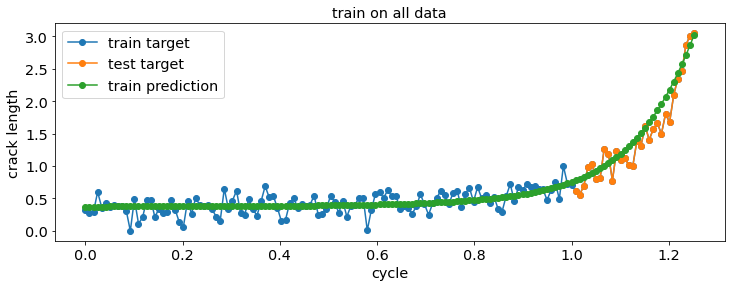

In [41]:
model = FullyConnectedExp([1, 4, 4, 1], activation=nn.Tanh).to(device)
# model = nn.Linear(1,1).to(device)
losses = train_model(model, torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), epochs=100)

train_predictions, _ = predict_model(model, torch.cat([train_xtensor, test_xtensor]))
# test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), train_predictions, 
                       test_xtensor, test_ytensor, title="train on all data")
# print(f"{test_loss = }")



In [42]:

# fig = plt.figure(figsize=(12, 4))
# plt.plot(train_xscaled, train_yscaled, marker="o", label="train target")
# plt.plot(test_xscaled, test_yscaled, marker="o", label="test target")
# plt.plot(np.concatenate([train_xscaled, test_xscaled]), train_predictions, marker="o", label="train prediction")
# # plt.plot(testinput, testprediction, marker="o", label="test prediction")
# # plt.ylim(-0.01, 0.02)
# plt.legend()

In [43]:
# def rescale_data(scaler, scaled):
#     return scaler.inverse_transform(scaled)

# fig = plot_target_prediction(train_xrescaled, train_yrescaled, rescale_data(train_yscaler, train_predictions), 
#     test_xrescaled, test_yrescaled, rescale_data(train_yscaler, test_predictions))

# fig = plot_target_prediction(train_xrescaled, train_yrescaled, train_yscaler_torch.inverse(train_predictions), 
#     test_xrescaled, test_yrescaled, train_yscaler_torch.inverse(test_predictions))

## Learning rate finder

In [445]:
train_dataset = torch.utils.data.TensorDataset(train_xtensor, train_ytensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_xtensor), shuffle=False)

 85%|████████▌ | 85/100 [00:00<00:00, 875.95it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.87E-02


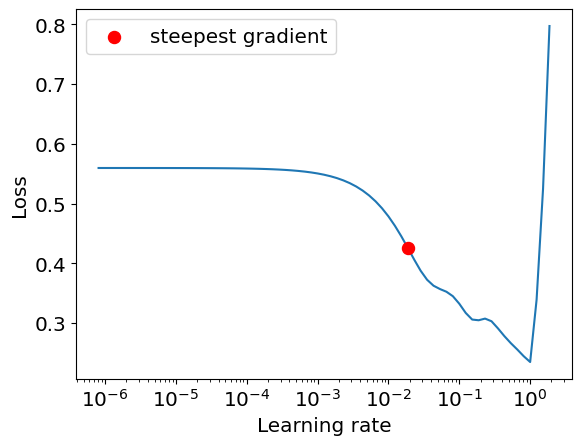

In [448]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay=1e-6)

lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_dataloader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

## neural network with physics

\begin{align}
\frac{da}{dN}=C(\Delta\sigma\sqrt{\pi a})^m
\\
ln\ \frac {da}{dN} = ln\ C + m\ ln\ (\Delta\sigma\sqrt{\pi a}) = ln\ C + m\ (ln \Delta \sigma + 0.5 ln\ \pi + 0.5 ln\ a)
\end{align}

Rescale derivative after normalization
\begin{align}
T_x(x) = \tilde x = \frac {x - min_x} {max_x - min_x} \\
T_y(y) = \tilde y = \frac {y - min_y} {max_y - min_y} \\
\hat y = model(\tilde x) \\
\\
paris(T_y^{-1}(\hat y)) = \frac d {dx} T_y^{-1} (\hat y) \\
\\
paris(T_y^{-1}(\hat y)) = paris(\hat y(max_y - min_y) + min_y) \\
\\
\frac d {dx} T_y^{-1} (\hat y) = \frac d {d \tilde x} (T_Y^{-1}(\hat y) ) \frac {d \tilde x} {dx} \\
= \frac d {d \tilde x} (model(\tilde x) (max_y - min_y) + min_y) . \frac d {dx} (\frac {x - min_x} {max_x - min_x}) \\
= (max_y - min_y) . \frac {d\ model(\tilde x)} {d \tilde x} . \frac 1 {max_x - min_x}
\end{align}

<!-- paris(\hat y(max_y - min_y) + min_y) = \frac d {dx} (\hat y(max_y - min_y) + min_y) \\ -->


In [44]:
# def paris_law_torch(C, m, a, dsigma):
#     righthandside = C * (dsigma * torch.sqrt(np.pi * a))**m
#     return righthandside

def paris_law_torch_log(loga, C, m, dsigma):
    # log_righthandside = np.log(C) + m * (np.log(dsigma) * 0.5 * np.log(np.pi) + 0.5 * torch.log(a))
    log_righthandside = torch.log(torch.tensor(C)) + m * (torch.log(torch.tensor(dsigma)) * 0.5 * torch.log(torch.tensor(np.pi)) + 0.5 * loga)
    return log_righthandside

def compute_data_physics_loss(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler, physics_coeff):
    
    data_prediction = model(inputdata)
    dataloss = tnf.mse_loss(data_prediction, targetdata)

    inputphysics.requires_grad_(True)
    prediction_physics = model(inputphysics)       
#     physics_diff = torch.diff(prediction_physics, dim=0)

    derivative = torch.autograd.grad(outputs=prediction_physics, inputs=inputphysics, 
        grad_outputs=torch.ones_like(inputphysics), retain_graph=True, create_graph=True)[0]
    # detach ?
    rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)
    
    physics_constraint = 1 * paris_law(outputscaler.inverse(prediction_physics), paris_C, paris_m, paris_dsigma)
    physicsloss = physics_coeff * (rescaled_derivative - physics_constraint)**2
    
    return dataloss, torch.mean(physicsloss), rescaled_derivative, physics_constraint, prediction_physics

In [45]:
def compute_data_physics_loss_log(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler, physics_coeff):
    
    data_prediction = model(inputdata)
#     data_prediction = torch.exp(data_prediction)
    dataloss = tnf.mse_loss(data_prediction, targetdata)

    inputphysics.requires_grad_(True)
    prediction_physics = model(inputphysics)       
#     prediction_physics = torch.exp(prediction_physics)
#     physics_diff = torch.diff(prediction_physics, dim=0)

    derivative = torch.autograd.grad(outputs=prediction_physics, inputs=inputphysics, 
        grad_outputs=torch.ones_like(inputphysics), retain_graph=True, create_graph=True)[0]
    rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)
    log_clipped_rescaled_derivative = torch.log(torch.clamp(rescaled_derivative, min=1e-6))
    
    physics_constraint = 1 * paris_law_torch_log(
        torch.log(torch.clamp(outputscaler.inverse(prediction_physics), min=1e-6)), 
        paris_C, paris_m, paris_dsigma)
    physicsloss = physics_coeff * torch.abs(log_clipped_rescaled_derivative - physics_constraint)
#     / physics_constraint
#     physicsloss = physics_coeff * torch.mean(torch.pow(torch.log(rescaled_derivative) - torch.log(physics_constraint), 2))

#     loss = dataloss + physicsloss
    
    return dataloss, torch.mean(physicsloss), log_clipped_rescaled_derivative, physics_constraint, prediction_physics
# , physics_diff.detach().cpu().numpy()

In [46]:
min_xphysics = min(min(train_xtensor), min(test_xtensor)).detach().item()
max_xphysics = max(max(train_xtensor), max(test_xtensor)).detach().item()
# min_xphysics = min(test_xtensor).detach().item()
# max_xphysics = max(test_xtensor).detach().item()
physics_xtensor = sample_physics_points(min_xphysics, max_xphysics, xstep=100)

In [47]:

def train_model_debug(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    C , m, dsigma, epochs=5, data_coeff=1, physics_coeff=1, optim=None, verbose=True):
    # using only data loss, physics loss computed but not back progagated
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    losses = dict(dataloss=[], physicsloss=[])
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
        
#         min_input = min(min(traininput), min(testinput)).detach().item()
#         max_input = max(max(traininput), max(testinput)).detach().item()
#         xphysics = torch.linspace(min_input, max_input, steps=100).reshape(-1, 1).requires_grad_(True).to(device)
        
        dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
           model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)
        
#         loss = dataloss + physicsloss
        loss = data_coeff * dataloss + physics_coeff * physicsloss
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())
        
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f"data loss = {dataloss=} ; physics loss = {physicsloss}")
#             print(f"physic loss 2 = {physicsloss2.detach().item()}")
#             figs.append(plot_twinx(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

            fig = plt.figure(figsize=(8,4))
#             print(physics_diff.shape, physicsinput.shape)
# * (yscaler.max.item() - yscaler.min.item()) / (xscaler.max.item() - xscaler.min.item())
#             plt.plot(tensor_to_array(physicsinput[1:]), physics_diff / 17 , label="physics diff", marker="o")
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
            
            plt.legend()
            figs.append(fig)
            
            plt.close()            
    return losses


 Epoch 1 loss = 0.06060333177447319
data loss = dataloss=tensor(0.0606, grad_fn=<MseLossBackward0>) ; physics loss = 7.278673774813171e-10

 Epoch 101 loss = 0.018269242718815804
data loss = dataloss=tensor(0.0183, grad_fn=<MseLossBackward0>) ; physics loss = 3.090167011166045e-10

 Epoch 201 loss = 0.018158476799726486
data loss = dataloss=tensor(0.0182, grad_fn=<MseLossBackward0>) ; physics loss = 3.1612287787474713e-10

 Epoch 301 loss = 0.018132951110601425
data loss = dataloss=tensor(0.0181, grad_fn=<MseLossBackward0>) ; physics loss = 3.304004847493047e-10

 Epoch 401 loss = 0.018125513568520546
data loss = dataloss=tensor(0.0181, grad_fn=<MseLossBackward0>) ; physics loss = 3.4187153108433677e-10

 Epoch 501 loss = 0.018121542409062386
data loss = dataloss=tensor(0.0181, grad_fn=<MseLossBackward0>) ; physics loss = 3.4982011731798934e-10

 Epoch 601 loss = 0.01812540367245674
data loss = dataloss=tensor(0.0181, grad_fn=<MseLossBackward0>) ; physics loss = 3.463202780107366e-10


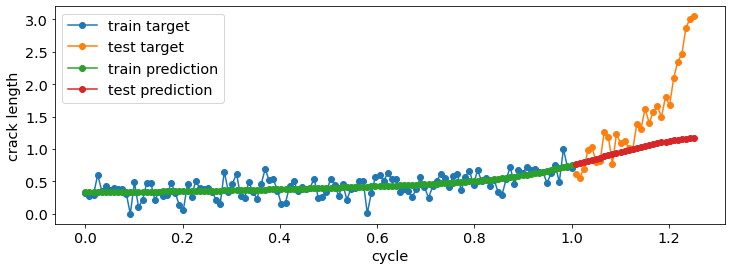

In [48]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 1000
physics_coeff = 1
# fig = plt.figure(1, figsize=(12,4))
losses = train_model_debug(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)


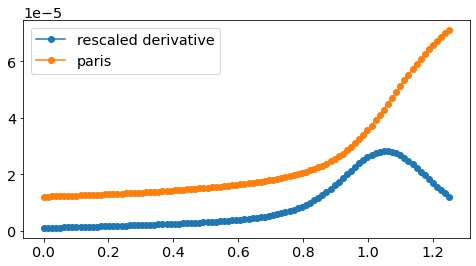

In [49]:
figs[-1]

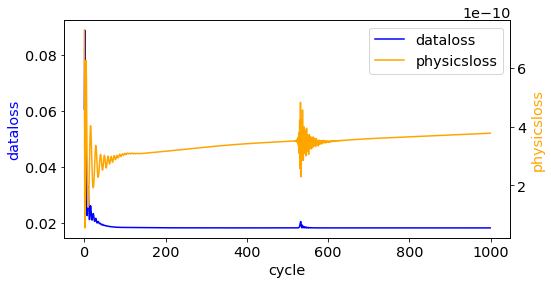

In [50]:
fig = plot_twinx(np.arange(epochs), losses["dataloss"], "dataloss", losses["physicsloss"], "physicsloss")

## All train data


 Epoch 1 loss = 2.583369016647339
data loss = dataloss=tensor(2.5834, grad_fn=<MseLossBackward0>) ; physics loss = 2.606519999837076e-10

 Epoch 11 loss = 0.30245402455329895
data loss = dataloss=tensor(0.3025, grad_fn=<MseLossBackward0>) ; physics loss = 1.1618581097216918e-10

 Epoch 21 loss = 0.20029714703559875
data loss = dataloss=tensor(0.2003, grad_fn=<MseLossBackward0>) ; physics loss = 8.95690410729344e-10

 Epoch 31 loss = 0.16997332870960236
data loss = dataloss=tensor(0.1700, grad_fn=<MseLossBackward0>) ; physics loss = 7.668453649856133e-10

 Epoch 41 loss = 0.148151695728302
data loss = dataloss=tensor(0.1482, grad_fn=<MseLossBackward0>) ; physics loss = 6.481200021113409e-10

 Epoch 51 loss = 0.13549330830574036
data loss = dataloss=tensor(0.1355, grad_fn=<MseLossBackward0>) ; physics loss = 5.873052599802975e-10

 Epoch 61 loss = 0.11676178127527237
data loss = dataloss=tensor(0.1168, grad_fn=<MseLossBackward0>) ; physics loss = 6.75577260800253e-10

 Epoch 71 loss = 0

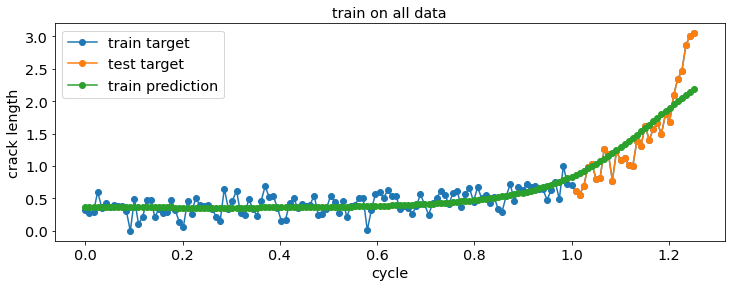

In [51]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 100
physics_coeff = 1
# fig = plt.figure(1, figsize=(12,4))
losses = train_model_debug(model, torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model, torch.cat([train_xtensor, test_xtensor]))
# test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), train_predictions, 
                       test_xtensor, test_ytensor, title="train on all data")


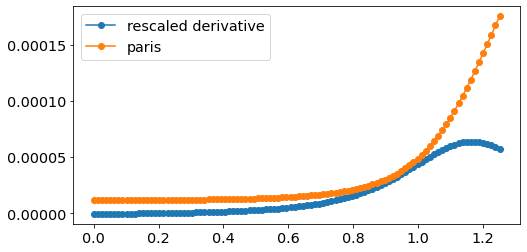

In [52]:
figs[-1]

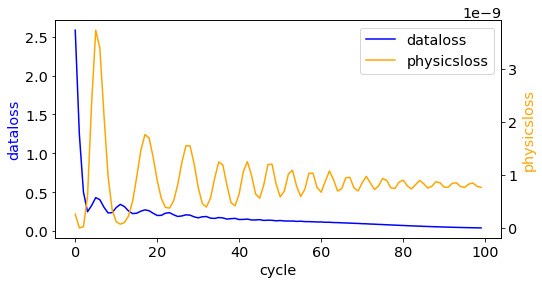

In [53]:
fig = plot_twinx(np.arange(epochs), losses["dataloss"], "dataloss", losses["physicsloss"], "physicsloss")


 Epoch 1 loss = 0.28447282314300537
data loss = dataloss=tensor(0.2845, grad_fn=<MseLossBackward0>) ; physics loss = 1.1182311743240803e-09

 Epoch 11 loss = 0.1337597817182541
data loss = dataloss=tensor(0.1338, grad_fn=<MseLossBackward0>) ; physics loss = 2.2090761164772488e-10

 Epoch 21 loss = 0.07916920632123947
data loss = dataloss=tensor(0.0792, grad_fn=<MseLossBackward0>) ; physics loss = 7.804622503826408e-10

 Epoch 31 loss = 0.07285108417272568
data loss = dataloss=tensor(0.0729, grad_fn=<MseLossBackward0>) ; physics loss = 1.0533163230519449e-09

 Epoch 41 loss = 0.06308106333017349
data loss = dataloss=tensor(0.0631, grad_fn=<MseLossBackward0>) ; physics loss = 5.222809407179341e-10

 Epoch 51 loss = 0.049353405833244324
data loss = dataloss=tensor(0.0494, grad_fn=<MseLossBackward0>) ; physics loss = 5.042978812319632e-10

 Epoch 61 loss = 0.036543261259794235
data loss = dataloss=tensor(0.0365, grad_fn=<MseLossBackward0>) ; physics loss = 5.690216076104093e-10

 Epoch 71

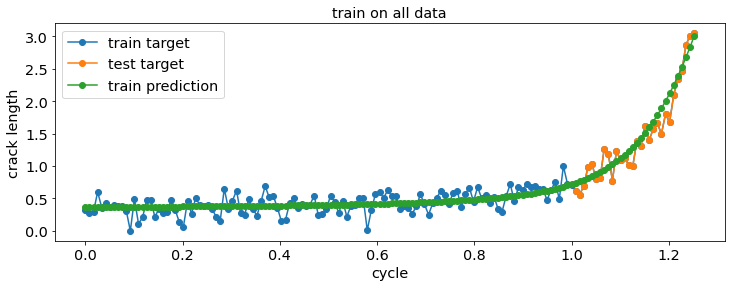

In [54]:
model = FullyConnectedExp([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 100
physics_coeff = 1
# fig = plt.figure(1, figsize=(12,4))
losses = train_model_debug(model, torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model, torch.cat([train_xtensor, test_xtensor]))
# test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), train_predictions, 
                       test_xtensor, test_ytensor, title="train on all data")


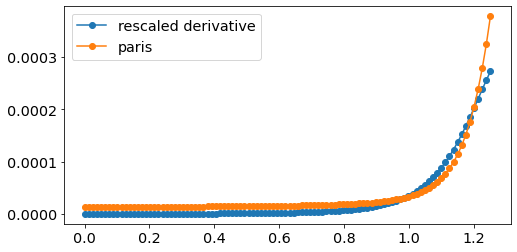

In [55]:
figs[-1]

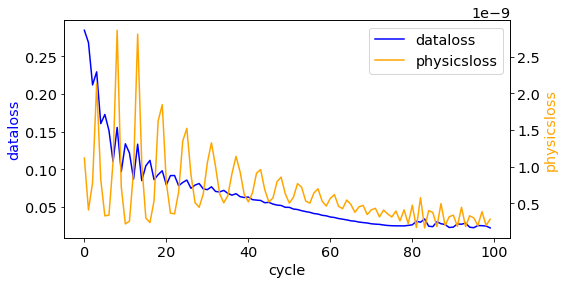

In [56]:
fig = plot_twinx(np.arange(epochs), losses["dataloss"], "dataloss", losses["physicsloss"], "physicsloss")

## Only physics loss


 Epoch 1 loss = 33176072192.0
data loss = dataloss=tensor(0.3318, grad_fn=<MseLossBackward0>) ; physics loss = 3.3176071643829346

 Epoch 201 loss = 50737.00390625
data loss = dataloss=tensor(0.9582, grad_fn=<MseLossBackward0>) ; physics loss = 5.073700322100194e-06

 Epoch 401 loss = 28243.25
data loss = dataloss=tensor(0.9669, grad_fn=<MseLossBackward0>) ; physics loss = 2.824325065375888e-06

 Epoch 601 loss = 14736.3916015625
data loss = dataloss=tensor(0.9765, grad_fn=<MseLossBackward0>) ; physics loss = 1.4736391449332586e-06

 Epoch 801 loss = 7551.392578125
data loss = dataloss=tensor(0.9849, grad_fn=<MseLossBackward0>) ; physics loss = 7.551392400273471e-07

 Epoch 1001 loss = 3936.833740234375
data loss = dataloss=tensor(0.9918, grad_fn=<MseLossBackward0>) ; physics loss = 3.9368336501865997e-07

 Epoch 1201 loss = 2164.012451171875
data loss = dataloss=tensor(0.9974, grad_fn=<MseLossBackward0>) ; physics loss = 2.1640124714394915e-07

 Epoch 1401 loss = 1308.98486328125
dat

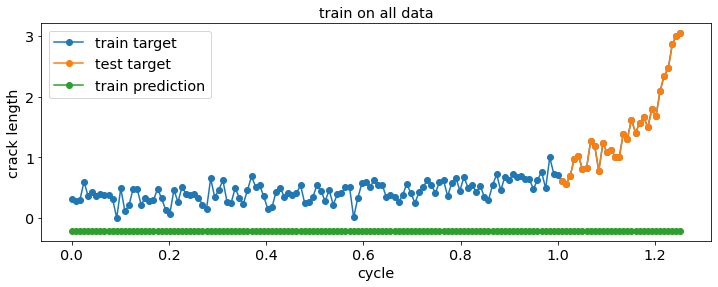

In [57]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 2000

# fig = plt.figure(1, figsize=(12,4))
losses = train_model_debug(model, torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, 
    data_coeff=0, physics_coeff=1e10)

train_predictions, _ = predict_model(model, torch.cat([train_xtensor, test_xtensor]))
# test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), train_predictions, 
                       test_xtensor, test_ytensor, title="train on all data")


In [58]:

def train_model_physics(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    losses = dict(dataloss=[], physicsloss=[])
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
               
        dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
           model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)
        
        loss = dataloss + physicsloss
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())
        
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f"data loss = {dataloss.detach().item()} ; physics loss = {physicsloss.detach().item()}")
#             print(f"physic loss 2 = {physicsloss2.detach().item()}")
#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

            fig = plt.figure(figsize=(8,4))
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
            plt.legend()
            figs.append(fig)
            
            plt.close()            
    return losses

In [59]:
minparam = 10
maxparam = -10

for param in model.parameters():
#     print(param)
    minparam = min(minparam, torch.min(param.data))
    maxparam = max(maxparam, torch.max(param.data))
    
minparam, maxparam

(tensor(-0.6677), tensor(1.2795))


 Epoch 1 loss = 0.43831324577331543
data loss = 0.43831324577331543 ; physics loss = 1.2485758954516868e-13

 Epoch 11 loss = 0.16030442714691162
data loss = 0.16030442714691162 ; physics loss = 6.512075492563774e-13

 Epoch 21 loss = 0.1263335645198822
data loss = 0.1263335645198822 ; physics loss = 5.212428795878243e-13

 Epoch 31 loss = 0.07811260223388672
data loss = 0.07811260223388672 ; physics loss = 6.10722518563922e-13

 Epoch 41 loss = 0.0469733364880085
data loss = 0.0469733364880085 ; physics loss = 8.729565464590805e-13

 Epoch 51 loss = 0.03198813274502754
data loss = 0.03198813274502754 ; physics loss = 8.007550243542549e-13

 Epoch 61 loss = 0.026739705353975296
data loss = 0.026739705353975296 ; physics loss = 6.058222500049393e-13

 Epoch 71 loss = 0.02707725763320923
data loss = 0.02707725763320923 ; physics loss = 3.071553428268814e-13

 Epoch 81 loss = 0.023502616211771965
data loss = 0.023502616211771965 ; physics loss = 5.812528735237021e-13

 Epoch 91 loss = 0.

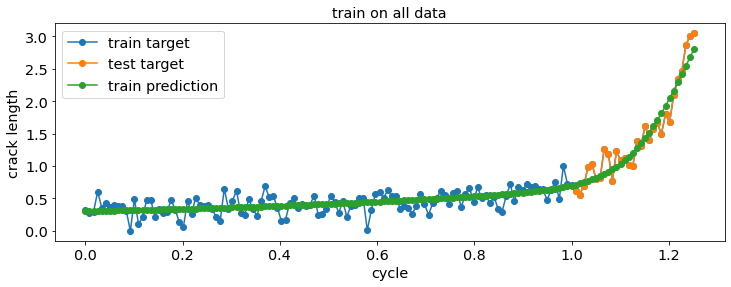

In [60]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 100
physics_coeff = 1e-3

losses = train_model_physics(model, torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model, torch.cat([train_xtensor, test_xtensor]))
# test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), train_predictions, 
                       test_xtensor, test_ytensor, title="train on all data")

# print(f"{test_loss = }")

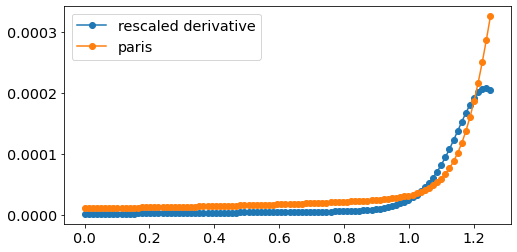

In [61]:
figs[-1]

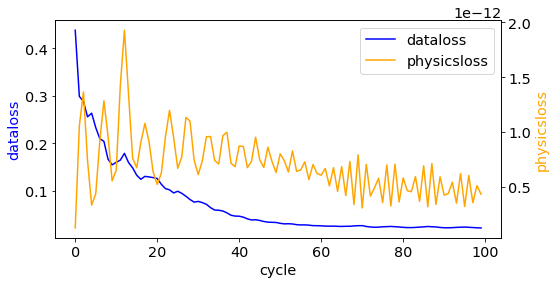

In [62]:
fig = plot_twinx(np.arange(epochs), losses["dataloss"], "dataloss", losses["physicsloss"], "physicsloss")


 Epoch 1 loss = 0.03766131401062012
data loss = 0.03766131401062012 ; physics loss = 3.024349000402271e-12

 Epoch 11 loss = 0.03470717370510101
data loss = 0.03470717370510101 ; physics loss = 1.9234939162282583e-12

 Epoch 21 loss = 0.026834987103939056
data loss = 0.026834987103939056 ; physics loss = 3.253196106597911e-12

 Epoch 31 loss = 0.02203591912984848
data loss = 0.02203591912984848 ; physics loss = 2.35025215435114e-12

 Epoch 41 loss = 0.021010275930166245
data loss = 0.021010275930166245 ; physics loss = 2.7810796200677945e-12

 Epoch 51 loss = 0.020355839282274246
data loss = 0.020355839282274246 ; physics loss = 2.8687054901693765e-12

 Epoch 61 loss = 0.019944502040743828
data loss = 0.019944502040743828 ; physics loss = 2.7038716318011913e-12

 Epoch 71 loss = 0.019617360085248947
data loss = 0.019617360085248947 ; physics loss = 2.577864354272319e-12

 Epoch 81 loss = 0.01938503421843052
data loss = 0.01938503421843052 ; physics loss = 2.6206010018264836e-12

 Epoc

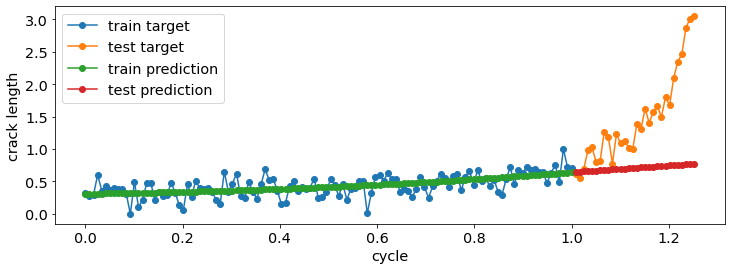

In [63]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 100
physics_coeff = 1e-2
# fig = plt.figure(1, figsize=(12,4))
# losses = train_model_physics(model, train_xtensor, train_ytensor, physics_xtensor, 
#     train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

losses = train_model_physics(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

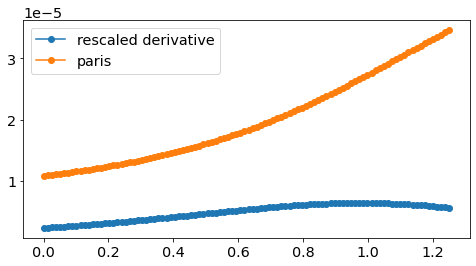

In [64]:
figs[-1]

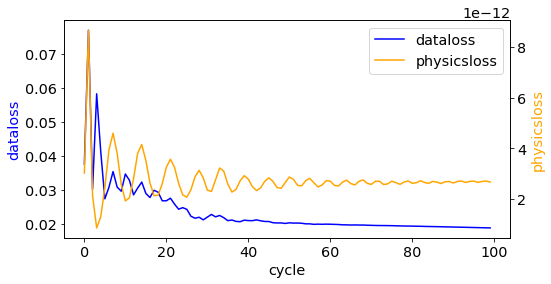

In [65]:
fig = plot_twinx(np.arange(epochs), losses["dataloss"], "dataloss", losses["physicsloss"], "physicsloss")

## Long training with physics


 Epoch 1 loss = 0.2979409992694855
data loss = 0.2979409992694855 ; physics loss = 2.6817053022654136e-09

 Epoch 2001 loss = 0.018167752772569656
data loss = 0.018167752772569656 ; physics loss = 2.792097664183757e-10

 Epoch 4001 loss = 0.018115459010004997
data loss = 0.018115459010004997 ; physics loss = 3.1644295517274657e-10

 Epoch 6001 loss = 0.01811365596950054
data loss = 0.01811365596950054 ; physics loss = 3.399131254244736e-10

 Epoch 8001 loss = 0.018110670149326324
data loss = 0.018110670149326324 ; physics loss = 3.3355562756298696e-10

 Epoch 10001 loss = 0.01725897192955017
data loss = 0.01725897192955017 ; physics loss = 4.66413019317713e-10

 Epoch 12001 loss = 0.01626032590866089
data loss = 0.01626032032072544 ; physics loss = 5.341080910881146e-09

 Epoch 14001 loss = 0.01607268489897251
data loss = 0.016072681173682213 ; physics loss = 4.26216439919358e-09

 Epoch 16001 loss = 0.016005950048565865
data loss = 0.016005946323275566 ; physics loss = 4.318527757618

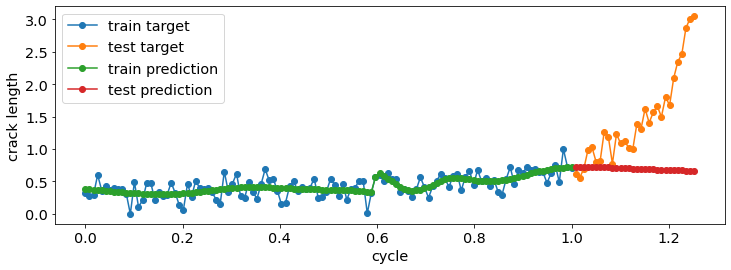

In [66]:
model = FullyConnectedExp([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 20000
physics_coeff = 1
# fig = plt.figure(1, figsize=(12,4))
# losses = train_model_physics(model, train_xtensor, train_ytensor, physics_xtensor, 
#     train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

losses = train_model_physics(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0))

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

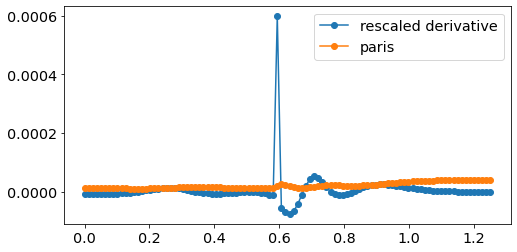

In [67]:
figs[-1]

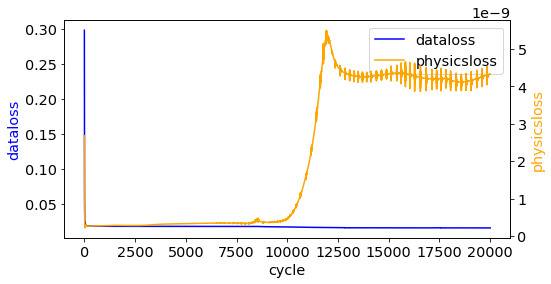

In [68]:
# # plt.figure(figsize=(8, 4))
# fig, ax1 = plt.subplots(figsize=(8,4))
# ax2 = ax1.twinx()

# plot1 = ax1.plot(np.arange(epochs), losses["dataloss"], marker="o", label="data loss", color="blue")
# ax1.set_ylabel("dataloss", color="blue")

# plot2 = ax2.plot(np.arange(epochs), losses["physicsloss"], marker="o", label="physics loss", color="orange")
# ax2.set_ylabel("physics loss", color="orange")

# # hack for legend
# ax1.plot([], [], color="orange", label="physicsloss")
# ax1.legend()

fig = plot_twinx(np.arange(epochs), losses["dataloss"], "dataloss", losses["physicsloss"], "physicsloss")


 Epoch 1 loss = 0.46691808104515076
data loss = 0.46691808104515076 ; physics loss = 7.860512506738596e-14

 Epoch 2001 loss = 0.018162716180086136
data loss = 0.018162716180086136 ; physics loss = 2.9457189465453837e-10

 Epoch 4001 loss = 0.018123647198081017
data loss = 0.018123647198081017 ; physics loss = 3.246012070245996e-10

 Epoch 6001 loss = 0.01811429113149643
data loss = 0.01811429113149643 ; physics loss = 3.899093270476328e-10

 Epoch 8001 loss = 0.018112601712346077
data loss = 0.018112601712346077 ; physics loss = 4.183894342091321e-10

 Epoch 10001 loss = 0.018110355362296104
data loss = 0.018110355362296104 ; physics loss = 4.1455375243693027e-10

 Epoch 12001 loss = 0.018104607239365578
data loss = 0.018104607239365578 ; physics loss = 3.9338413082568024e-10

 Epoch 14001 loss = 0.01808958500623703
data loss = 0.01808958500623703 ; physics loss = 3.5782327101330225e-10

 Epoch 16001 loss = 0.01803264208137989
data loss = 0.01803264208137989 ; physics loss = 3.213186

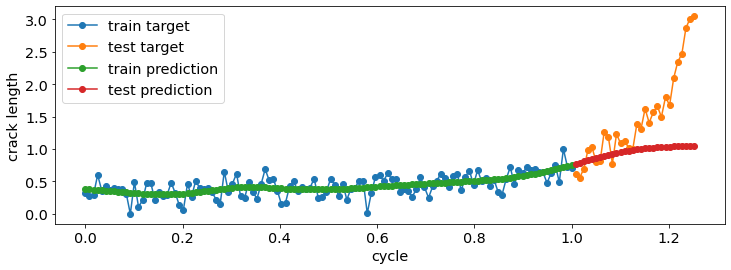

In [69]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 20000
physics_coeff = 1
# fig = plt.figure(1, figsize=(12,4))
# losses = train_model_physics(model, train_xtensor, train_ytensor, physics_xtensor, 
#     train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

losses = train_model_physics(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0))

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

## gradient magnitude

observation data: $\{x[i], y[i]\}, i = 1...n[obs]$ \
model prediction with paramater w: $\hat y = h(x; w)$ \
physics constraint: $$\frac {d h(x; w)} {dx} = f(x)$$

static scalarization of multi task loss:

\begin{align}
L = L_{obs} + \lambda_{phy} L_{phy}
= \sum_{i=1}^{n[obs]}(h(x[i]; w) - y[i])^2 + \lambda_{phy} \sum_{j=1}^{n[phy]} (\frac {d h(x[j]; w)} {dx} - f(x_j))^2
\end{align}

Gradient magnitude scalarization according to "Optimally weighted loss functions for solving PDEs with Neural Networks"
(https://arxiv.org/pdf/2002.06269.pdf)

\begin{align}
L = \frac {L_{obs}} {||\nabla_x L_{obs}||^2} + \frac {L_{phy}} {||f(x)||^2} \\
= \frac {\sum_{i=1}^{n[obs]}(h(x[i]; w) - y[i])^2} {\sum_{i=1}^{n[obs]} y[i]^2}
+ \frac {\sum_{j=1}^{n[phy]} (\frac {d h(x[j]; w)} {dx} - f(x_j)^2} {\sum_{i=1}^{n[phy]} (|\frac {d h(x[j]; w)} {dx}| + |f(x_j)|)^2}
\end{align}


In [70]:

def train_model_physics_magnitude_norm(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = dict(dataloss=[], physicsloss=[], normalized_dataloss=[], normalized_physicsloss=[])
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
               
        dataloss, physicsloss, rescaled_derivative, physics_constraint, physics_prediction = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
           model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)
        
        # # detach ???
        # differential_norm = torch.abs(rescaled_erivative.detach()) + torch.abs(physics_constraint.detach())
        differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(trainlabel**2)

#         differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
#         differential_norm = torch.sum(differential_norm)
#         data_norm = torch.sum(trainlabel)

        loss = dataloss / data_norm + physicsloss / differential_norm
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
        metric["dataloss"].append(dataloss.detach().item())
        metric["physicsloss"].append(physicsloss.detach().item())
        metric["normalized_dataloss"].append((dataloss / data_norm).detach().item())
        metric["normalized_physicsloss"].append((physicsloss / differential_norm).detach().item())
        
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
#             print(f"normalized data loss = {(dataloss / data_norm).detach().item()} ; normalized physics loss = {(physicsloss / differential_norm).detach().item()}")
            print(f"normalized data loss = {metric['normalized_dataloss'][-1]} ; normalized physics loss = {metric['normalized_physicsloss'][-1]}")
            print(f"{data_norm = } {differential_norm = }")

#             print(f"physic loss 2 = {physicsloss2.detach().item()}")
#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

            fig = plt.figure(figsize=(8,4))
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
            plt.legend()
            figs.append(fig)
            
            plt.close()            
            
    
    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)
    
    return metric


 Epoch 1 loss = 0.011818754486739635
normalized data loss = 0.003656812710687518 ; normalized physics loss = 0.008161941543221474
data_norm = tensor(26.2073) differential_norm = tensor(4.7792e-09, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 0.0007906495593488216
normalized data loss = 0.0006969746318645775 ; normalized physics loss = 9.36749202082865e-05
data_norm = tensor(26.2073) differential_norm = tensor(1.1831e-06, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 0.0007405666401609778
normalized data loss = 0.0006944768247194588 ; normalized physics loss = 4.608978997566737e-05
data_norm = tensor(26.2073) differential_norm = tensor(2.2808e-06, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 0.0007303997408598661
normalized data loss = 0.0006940557505004108 ; normalized physics loss = 3.6343993997434154e-05
data_norm = tensor(26.2073) differential_norm = tensor(3.0669e-06, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 0.0007267251494340599
normalized data loss = 0.0006942764739505947 ; norma

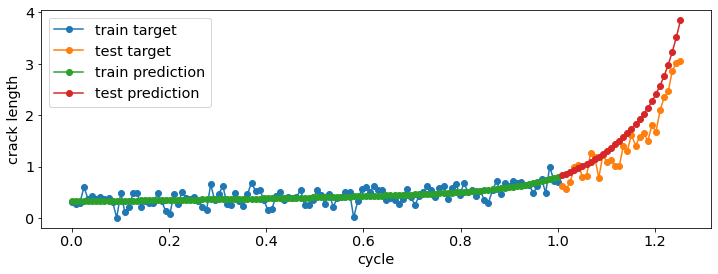

In [572]:
%%time 
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

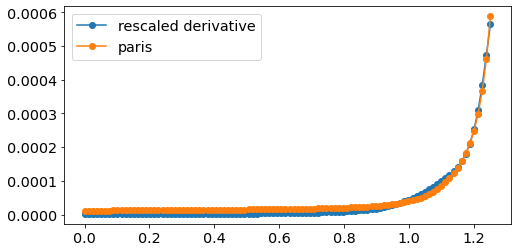

In [573]:
figs[-1]

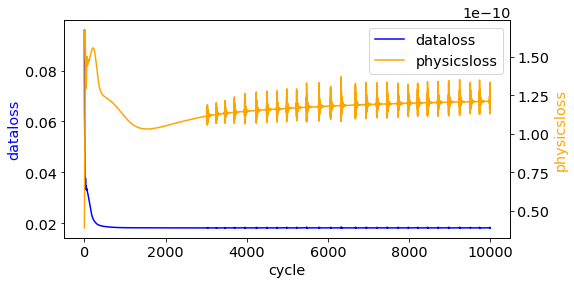

In [574]:
fig = plot_twinx(np.arange(epochs), metric["dataloss"], "dataloss", metric["physicsloss"], "physicsloss")

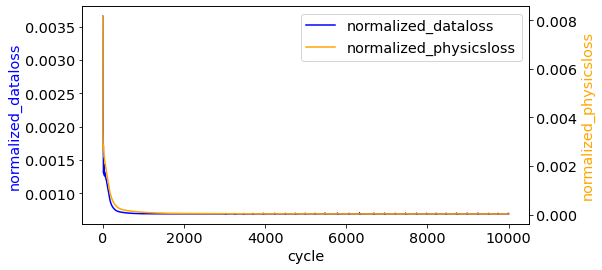

In [575]:
fig = plot_twinx(np.arange(epochs), metric["normalized_dataloss"], "normalized_dataloss", metric["normalized_physicsloss"], "normalized_physicsloss",)

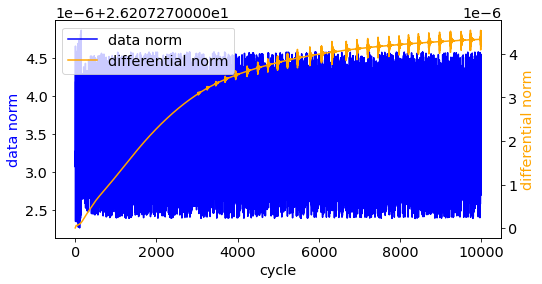

In [576]:
fig = plot_twinx(np.arange(epochs), metric["dataloss"] / metric["normalized_dataloss"], "data norm",
    metric["physicsloss"] / metric["normalized_physicsloss"], "differential norm",)


 Epoch 1 loss = 0.06006145477294922
normalized data loss = 0.050068244338035583 ; normalized physics loss = 0.009993208572268486
data_norm = tensor(26.2073) differential_norm = tensor(1.3964e-06, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 0.0007982372771948576
normalized data loss = 0.0007011835114099085 ; normalized physics loss = 9.705378761282191e-05
data_norm = tensor(26.2073) differential_norm = tensor(1.2691e-06, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 0.0007329756626859307
normalized data loss = 0.0006960091996006668 ; normalized physics loss = 3.6966492189094424e-05
data_norm = tensor(26.2073) differential_norm = tensor(3.0472e-06, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 0.0007186218863353133
normalized data loss = 0.0006945976056158543 ; normalized physics loss = 2.4024284357437864e-05
data_norm = tensor(26.2073) differential_norm = tensor(5.3919e-06, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 0.0007140240631997585
normalized data loss = 0.0006943292100913823 ; norm

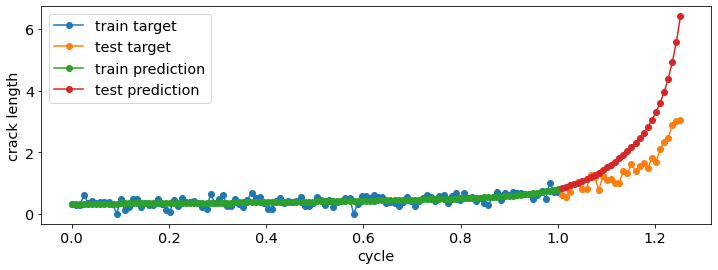

In [577]:
%%time

model = FullyConnectedExp([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

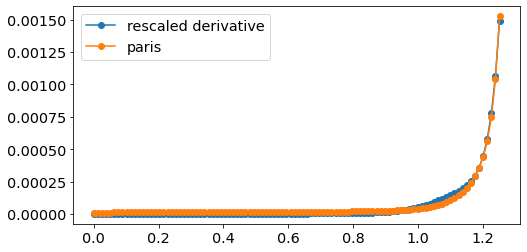

In [578]:
figs[-1]

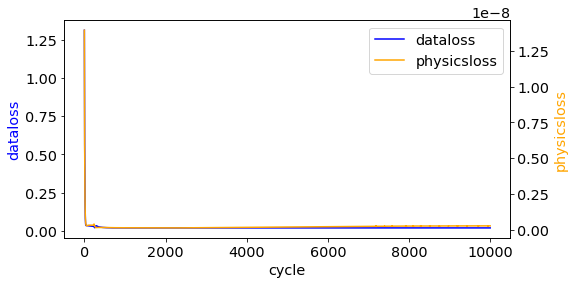

In [579]:
fig = plot_twinx(np.arange(epochs), metric["dataloss"], "dataloss", metric["physicsloss"], "physicsloss")

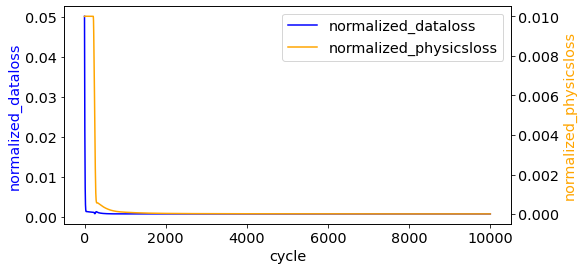

In [580]:
fig = plot_twinx(np.arange(epochs), metric["normalized_dataloss"], "normalized_dataloss", metric["normalized_physicsloss"], "normalized_physicsloss",)

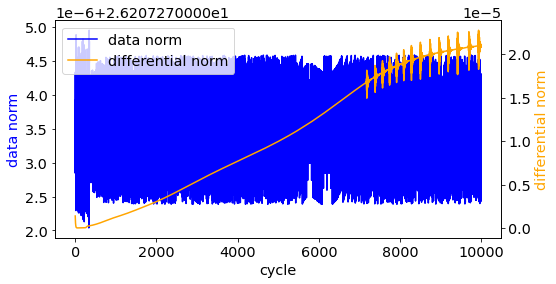

In [581]:
fig = plot_twinx(np.arange(epochs), metric["dataloss"] / metric["normalized_dataloss"], "data norm",
    metric["physicsloss"] / metric["normalized_physicsloss"], "differential norm",)

## Uncertainty calibration metric

https://uncertainty-toolbox.github.io/tutorial/

Miscalibration area: for a varying confidence level from 0 to 1, what proportion of true value lies within the prediction interval

Sharpness: average width of prediction interval

## Monte Carlo Dropout

https://stackoverflow.com/questions/63285197/measuring-uncertainty-using-mc-dropout-on-pytorch


In [402]:
dropout_test_model = nn.Sequential(nn.Linear(2, 4), nn.Dropout(0.5))
dropout_test_model(torch.rand(3, 2))

tensor([[-0.8367, -0.9980, -0.6842, -0.0000],
        [-0.6160, -0.0000, -0.0000, -0.0000],
        [-0.0516, -1.8487, -0.0000, -0.0000]], grad_fn=<MulBackward0>)

In [285]:
def plot_target_prediction_sample(traininput, traintarget, trainprediction, testinput, testtarget, testprediction=None,
    title=None, figsize=(12, 4), marker="o"):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(traininput, traintarget, label="train target", marker=marker, alpha=0.6)
    plt.plot(testinput, testtarget, label="test target", marker=marker, alpha=0.6)
    plt.plot(traininput, trainprediction.mean(0), label="train prediction mean", marker=marker, linestyle="--", linewidth=3)
    
    high_quantile = np.quantile(trainprediction, 0.975, axis=0)
    low_quantile = np.quantile(trainprediction, 0.025, axis=0)
    #         print(testinput.shape, high_quantile.shape, low_quantile.shape)
    plt.fill_between(traininput.squeeze(), low_quantile.squeeze(), high_quantile.squeeze(), color="green", alpha=0.2, label="train CI 0.95")
    
    if testprediction is not None:
        plt.plot(testinput, testprediction.mean(0), marker=marker, label="test prediction mean", linestyle="--", linewidth=3)
        high_quantile = np.quantile(testprediction, 0.975, axis=0)
        low_quantile = np.quantile(testprediction, 0.025, axis=0)
        #         print(testinput.shape, high_quantile.shape, low_quantile.shape)
        plt.fill_between(testinput.squeeze(), low_quantile.squeeze(), high_quantile.squeeze(), color="red", alpha=0.2, label="test CI 0.95")
        # plt.ylim(-0.01, 0.02)
    
    plt.legend(loc='upper left')
    plt.xlabel("cycle")
    plt.ylabel("crack length")
    
    if title: plt.title(title)

    return fig

# fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_dropout_predictions, 
#                        test_xtensor, test_ytensor, test_dropout_predictions, marker="")


In [286]:
# train_xtensor, train_ytensor, test_xtensor, test_ytensor, fig = generate_data_tensor()

In [287]:
class FullyConnectedDropout(nn.Module):
    def __init__(self, layer_size, drop_proba=0.05, activation=nn.Tanh, need_output_exp=True):
        super().__init__()
        self.need_output_exp = need_output_exp
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(activation())
            layers.append(nn.Dropout(drop_proba))
        
        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-2], layer_size[-1])
        )
        
    def forward(self, inpt):
        # outpt = inpt
        # for layer in self.layers:
        #     outpt = layer(outpt)
        outpt = self.layers(inpt)
        if self.need_output_exp: outpt = torch.exp(outpt)
        return outpt



 Epoch 1 loss = 0.03163183107972145
normalized data loss = 0.022882916033267975 ; normalized physics loss = 0.008748915046453476
data_norm = tensor(26.2073) differential_norm = tensor(6.9467e-07, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 0.0010354958940297365
normalized data loss = 0.0008605103939771652 ; normalized physics loss = 0.0001749854563968256
data_norm = tensor(26.2073) differential_norm = tensor(7.3207e-07, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 0.001024983124807477
normalized data loss = 0.0008584855822846293 ; normalized physics loss = 0.00016649754252284765
data_norm = tensor(26.2073) differential_norm = tensor(7.7505e-07, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 0.0009091523825190961
normalized data loss = 0.0007811632240191102 ; normalized physics loss = 0.00012798917305190116
data_norm = tensor(26.2073) differential_norm = tensor(1.2362e-06, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 0.0009499536827206612
normalized data loss = 0.0008357587503269315 ; norma

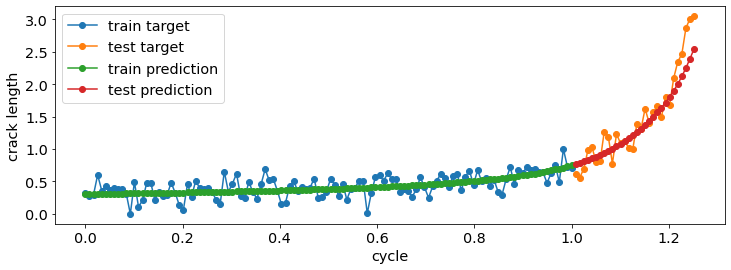

In [1001]:
model_dropout = FullyConnectedDropout([1, 4, 4, 1], drop_proba=0.05, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model_dropout.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm(model_dropout, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions, _ = predict_model(model_dropout, train_xtensor)
test_predictions, test_loss = predict_model(model_dropout, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

In [288]:
def enable_dropout(model):
    """ Enable dropout during test time """
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()
    
    return model

def predict_dropout(model, sample_size, inputdata, targetdata=None):
    model.eval()
    model = enable_dropout(model)
    loss = None
    all_predictions = []
    
    with torch.no_grad():
        for iteration in range(sample_size):
            outputdata = model(inputdata.to(device))
    #         predictions = outputdata
            if targetdata is not None:
                loss = tnf.mse_loss(outputdata, targetdata.to(device)).detach().item()
                
            all_predictions.append(outputdata.detach().cpu().numpy())
        
    return np.stack(all_predictions, 0)

In [289]:
def plot_multiple_target_prediction(traininput, traintarget, trainprediction, testinput, testtarget, testprediction=None,
    title=None, figsize=(12, 4), marker="o"):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(traininput, traintarget, label="train target", marker=marker, linestyle="--")
    plt.plot(testinput, testtarget, label="test target", marker=marker, linestyle="--") 
    plt.plot(traininput, trainprediction, label="train prediction", marker=marker)
            
    plt.plot([], [], label="test prediction", color="black")
    
    if testprediction is not None:
#         for sample_testprediction in testprediction:
# #             print(sample_testprediction.shape)
#             plt.plot(testinput, sample_testprediction, marker=marker, color="black", alpha=0.6)
        
        plt.plot(testinput, np.mean(testprediction, axis=0), marker=marker, color="black")
        high_quantile = np.quantile(testprediction, 0.975, axis=0)
        low_quantile = np.quantile(testprediction, 0.025, axis=0)
#         print(testinput.shape, high_quantile.shape, low_quantile.shape)
        plt.fill_between(testinput.squeeze(), low_quantile.squeeze(), high_quantile.squeeze(), color="black", alpha=0.3)
    
    plt.legend()    
    if title: plt.title(title)

    return fig

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

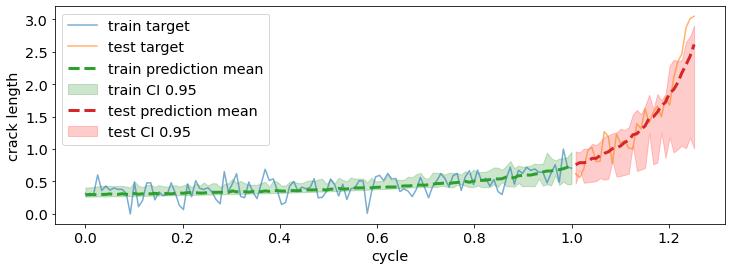

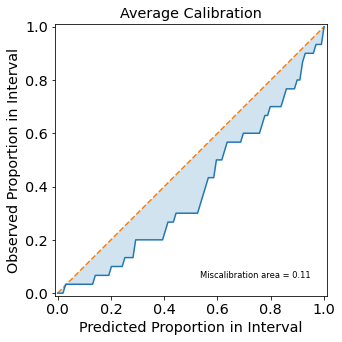

In [593]:
train_dropout_predictions = predict_dropout(model_dropout, 100, train_xtensor, train_ytensor) 
test_dropout_predictions = predict_dropout(model_dropout, 100, test_xtensor, test_ytensor)
# print(dropout_predictions.shape)

# fig = plot_multiple_target_prediction(train_xtensor, train_ytensor, train_predictions, 
#                        test_xtensor, test_ytensor, dropout_predictions, marker="")

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_dropout_predictions, 
                       test_xtensor, test_ytensor, test_dropout_predictions, marker="")
# fig.savefig("probabilistic_prediction.png", bbox_inches="tight")

test_mean, test_std = np.mean(test_dropout_predictions.squeeze(), 0), np.std(test_dropout_predictions.squeeze(), 0)
uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())


<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

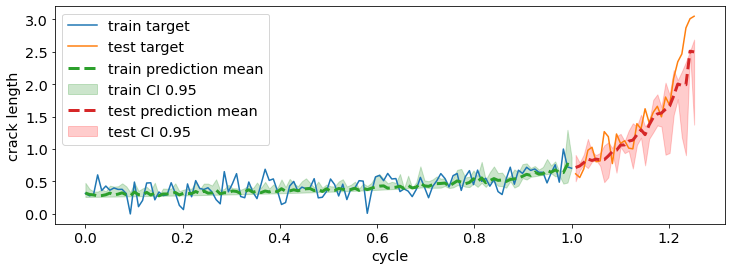

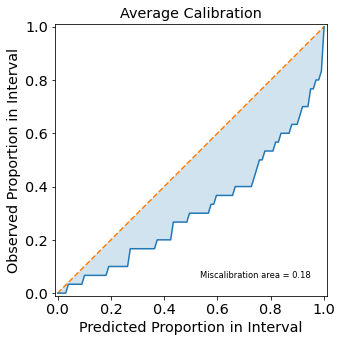

In [473]:
train_dropout_predictions = predict_dropout(model_dropout, 10, train_xtensor, train_ytensor) 
test_dropout_predictions = predict_dropout(model_dropout, 10, test_xtensor, test_ytensor)
# print(dropout_predictions.shape)

# fig = plot_multiple_target_prediction(train_xtensor, train_ytensor, train_predictions, 
#                        test_xtensor, test_ytensor, dropout_predictions, marker="")

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_dropout_predictions, 
                       test_xtensor, test_ytensor, test_dropout_predictions, marker="")
# fig.savefig("probabilistic_prediction.png", bbox_inches="tight")

test_mean, test_std = np.mean(test_dropout_predictions.squeeze(), 0), np.std(test_dropout_predictions.squeeze(), 0)
uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())


In [474]:
metrics = uct.metrics.get_all_metrics(test_mean, test_std, test_ytensor.numpy().squeeze())

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 12.28it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 12.22it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.212
  RMSE          0.290
  MDAE          0.154
  MARPD         14.727
  R2            0.820
  Correlation   0.959
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.202
  Mean-absolute Calibration Error       0.183
  Miscalibration Area                   0.185
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.419
     Group Size: 0.56 -- Calibration Error: 0.252
     Group Size: 1.00 -- Calibration Error: 0.183
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.471
     Group Size: 0.56 -- Calibration Error: 0.293
     Group Size: 1.00 -- Calibration Error: 0.202
===============

## Monte Carlo Dropout same mask

In [290]:
class DropoutSameMask(nn.Module):
    def __init__(self, drop_proba):
        super().__init__()
        self.drop_proba = drop_proba
        self.mask = None
    
    def forward(self, indata):
        
        if self.mask == None:
            self.mask = torch.empty(indata.shape[1:]).bernoulli_(1 - self.drop_proba)
        # print(indata, self.mask)
        return indata * self.mask
    
    def reset_mask(self):
        self.mask = None

class FullyConnectedDropoutSameMask(nn.Module):
    def __init__(self, layer_size, drop_proba=0.05, activation=nn.Tanh, need_output_exp=True):
        super().__init__()
        self.need_output_exp = need_output_exp
        self.drop_proba = drop_proba
        layers = []
        self.need_new_mask = True
        
        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(activation())            
            layers.append(DropoutSameMask(drop_proba))
        
        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-2], layer_size[-1])
        )
        # self.masks.append(self.bernoulli.sample((layer_size[-1], layer_size[-2])))
        
    def forward(self, inpt):
        outpt = inpt
        for layer in self.layers:
            if self.need_new_mask and isinstance(layer, DropoutSameMask):
                layer.reset_mask()
            outpt = layer(outpt)
                    
        # enforce positive value by model the ln and take exp
        if self.need_output_exp: outpt = torch.exp(outpt)
        return outpt
    
    def reset_mask(self):
        self.need_new_mask = True
        
    def keep_mask(self):
        self.need_new_mask = False


In [291]:
model_dropout_same_mask = FullyConnectedDropoutSameMask([1, 4, 8, 1], drop_proba=0.5, activation=nn.Tanh).to(device)
model_dropout_same_mask(torch.rand(3, 1))

tensor([[1.1204],
        [1.1325],
        [1.1280]], grad_fn=<ExpBackward0>)

In [292]:
def train_model_physics_magnitude_norm_dropout_same_mask(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = dict(dataloss=[], physicsloss=[], normalized_dataloss=[], normalized_physicsloss=[])
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
        model.reset_mask()
               
        dataloss, physicsloss, rescaled_derivative, physics_constraint, physics_prediction = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
           model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)
        
        differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(trainlabel**2)

        loss = dataloss / data_norm + physicsloss / differential_norm
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
        metric["dataloss"].append(dataloss.detach().item())
        metric["physicsloss"].append(physicsloss.detach().item())
        metric["normalized_dataloss"].append((dataloss / data_norm).detach().item())
        metric["normalized_physicsloss"].append((physicsloss / differential_norm).detach().item())
        
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
#             print(f"normalized data loss = {(dataloss / data_norm).detach().item()} ; normalized physics loss = {(physicsloss / differential_norm).detach().item()}")
            print(f"normalized data loss = {metric['normalized_dataloss'][-1]} ; normalized physics loss = {metric['normalized_physicsloss'][-1]}")
            print(f"{data_norm = } {differential_norm = }")

#             print(f"physic loss 2 = {physicsloss2.detach().item()}")
#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

            fig = plt.figure(figsize=(8,4))
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
            plt.legend()
            figs.append(fig)
            
            plt.close()            
            
    
    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)
    
    return metric

In [293]:
def predict_dropout_same_mask(model, sample_size, inputdata, targetdata=None):
    model.eval()
    model = enable_dropout(model)
    loss = None
    all_predictions = []
    
    with torch.no_grad():
        for iteration in range(sample_size):
            model.reset_mask()
            outputdata = model(inputdata.to(device))
    #         predictions = outputdata
            if targetdata is not None:
                loss = tnf.mse_loss(outputdata, targetdata.to(device)).detach().item()
                
            all_predictions.append(outputdata.detach().cpu().numpy())
        
    return np.stack(all_predictions, 0)


 Epoch 1 loss = 0.015161990188062191
normalized data loss = 0.005161990411579609 ; normalized physics loss = 0.009999999776482582
data_norm = tensor(26.2073) differential_norm = tensor(1.7718e-07, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 0.001014541951008141
normalized data loss = 0.0008716202573850751 ; normalized physics loss = 0.00014292169362306595
data_norm = tensor(26.2073) differential_norm = tensor(8.0714e-07, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 0.0011645474005490541
normalized data loss = 0.0007597972871735692 ; normalized physics loss = 0.00040475017158314586
data_norm = tensor(26.2073) differential_norm = tensor(6.2006e-07, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 0.0008563280571252108
normalized data loss = 0.0007709112833254039 ; normalized physics loss = 8.541675197193399e-05
data_norm = tensor(26.2073) differential_norm = tensor(1.1975e-06, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 0.0013446331722661853
normalized data loss = 0.000937109172809869 ; norma

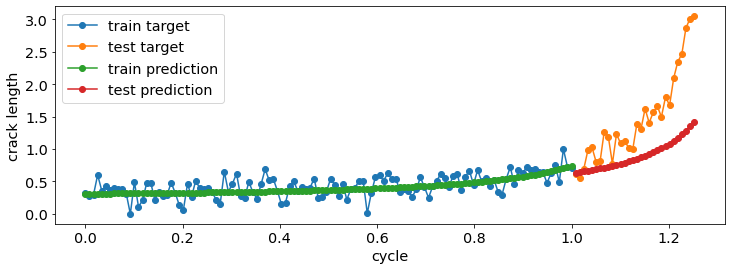

In [294]:
model_dropout = FullyConnectedDropoutSameMask([1, 4, 4, 1], drop_proba=0.05, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model_dropout.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_dropout_same_mask(model_dropout, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions, _ = predict_model(model_dropout, train_xtensor)
test_predictions, test_loss = predict_model(model_dropout, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

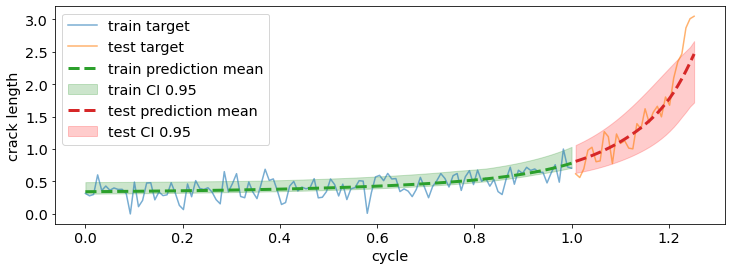

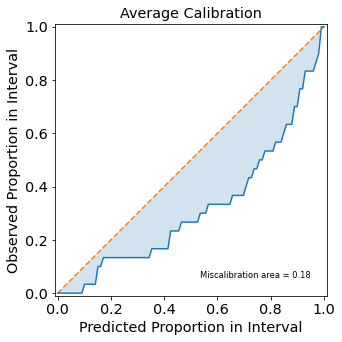

In [295]:
train_dropout_predictions = predict_dropout_same_mask(model_dropout, 100, train_xtensor, train_ytensor) 
test_dropout_predictions = predict_dropout_same_mask(model_dropout, 100, test_xtensor, test_ytensor)
# print(dropout_predictions.shape)

# fig = plot_multiple_target_prediction(train_xtensor, train_ytensor, train_predictions, 
#                        test_xtensor, test_ytensor, dropout_predictions, marker="")

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_dropout_predictions, 
                       test_xtensor, test_ytensor, test_dropout_predictions, marker="")
# fig.savefig("probabilistic_prediction.png", bbox_inches="tight")

test_mean, test_std = np.mean(test_dropout_predictions.squeeze(), 0), np.std(test_dropout_predictions.squeeze(), 0)
uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())


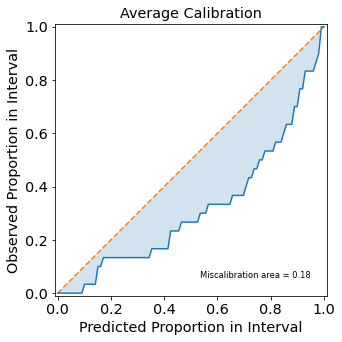

In [299]:
ax = uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())
ax.figure.savefig("../fig/calibration-plot.pdf")


## Bayes by backprop model

Plot evolution of parameters' Gaussian variance. More data and less noise should lead to smaller variance.

https://arxiv.org/pdf/1505.05424.pdf

Weights are drawn from Gaussian with learned mean and variance

\begin{align}
w \sim \mathcal N (\mu, \sigma^2) \\
ln\ \mathcal N (x; \mu, \sigma^2) = ln\ (\frac {1} {\sqrt(2 \pi) \sigma} exp(\frac {-(x - \mu)^2} {2 \sigma^2}))
= - \frac 1 2 ln\ 2 \pi - ln\ \sigma - \frac {(x-\mu)^2} {2 \sigma^2}
\end{align}

Variational inference and ELBO: approximate posterior $p(w|D)$ with proposal $q(w; \theta)$
\begin{align}
\theta^* = argmin_\theta\ KL [q(w; \theta) | p(w | D) ] = argmin_\theta\ \int q(w; \theta)\ ln\ \frac {q(w; \theta)} {p(D|w) p(w)} dw
= argmin_\theta\ \int q(w; \theta)\ ln\ \frac {q(w; \theta)} {p(w)} dw - \int q(w; \theta)\ ln\ p(D|w) dw \\
=> argmin_\theta\ \beta KL[ q(w; \theta) | p(w)] - E_{q(w; \theta)} [p(D|w)]
\end{align}


In [73]:
def mse_to_log_gaussian(mse, sigma):
    return float(-0.5 * np.log(2 * np.pi) - torch.log(torch.abs(sigma))) - mse / (2 * sigma**2)

def log_gaussian(x, mu, sigma):
    return float(-0.5 * np.log(2 * np.pi) - torch.log(torch.abs(sigma))) - (x - mu)**2 / (2 * sigma**2)

def log_gaussian_logsigma(x, mu, logsigma):
    return float(-0.5 * np.log(2 * np.pi)) - logsigma - (x - mu)**2 / (2 * torch.exp(logsigma)**2)

def sample_prediction(model, inputdata, targetdata=None, sample_size=10):
    model.eval()
    predictions = []

    with torch.no_grad():
        for sample_count in range(sample_size):
            outdata = model(inputdata.to(device), need_sample=True)
            predictions.append(outdata[0].detach().cpu())
    return torch.stack(predictions, dim=0)

def reparameterize_std(reparam_std):
    return torch.log1p(torch.exp(reparam_std))

In [74]:
def plot_metric(ax, metric, metrickey):
    return ax.plot(metric[metrickey], label=metrickey)
    
def plot_variational_training_metrics(metric, title=None, figsize=(20, 6)):

    fig, axes = plt.subplots(1, 2, figsize=(figsize))
    axes = axes.flatten()
    
    axes[0].set_xlabel("epoch")
    plot_metric(axes[0], metric, "logprior")
    plot_metric(axes[0], metric, "logproposal")
    axes[0].plot(metric["logproposal"] - metric["logprior"], label="KL divergence")
    axes[0].legend()

    plot_metric(axes[1], metric, "data_loglikelihood")
    plot_metric(axes[1], metric, "physics_loglikelihood")
    axes[1].plot(metric["data_loglikelihood"] + metric["physics_loglikelihood"], label="loglikelihood")
    axes[1].set_xlabel("epoch")
    axes[1].legend()  
        
    if title: plt.title(title)

    return fig    


In [75]:
# https://gist.github.com/vvanirudh/9e30b2f908e801da1bd789f4ce3e7aac
# https://github.com/cpark321/uncertainty-deep-learning/blob/master/01.%20Bayes-by-Backprop.ipynb

class GaussianLinear(nn.Module):
    def __init__(self, inputsize, outputsize, prior_std):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.prior_std = torch.tensor(prior_std)
        
        self.weight_mean = nn.Parameter(torch.Tensor(inputsize, outputsize).normal_(0, prior_std))
        self.weight_logstd = nn.Parameter(torch.Tensor(inputsize, outputsize).normal_(0, prior_std))
        
        self.bias_mean = nn.Parameter(torch.Tensor(1, outputsize).uniform_(-1, 1))
        self.bias_logstd = nn.Parameter(torch.Tensor(1, outputsize).uniform_(-1, 1))
        
        self.logprior = 0
        self.logproposal = 0
        self.normal01 = td.Normal(0,1)

    def forward(self, inputdata, need_sample=True):
        if not need_sample:
            output = torch.mm(inputdata, self.weight_mean) + self.bias_mean.expand(inputdata.size()[0], self.outputsize)
            return output, self.logprior, self.logproposal
        
        epsilon_weight = self.normal01.sample(self.weight_mean.shape).to(device)
        epsilon_bias = self.normal01.sample(self.bias_mean.shape).to(device)        
        weight = self.weight_mean + torch.log(1 + torch.exp(self.weight_logstd)) * epsilon_weight
        bias = self.bias_mean + torch.log(1 + torch.exp(self.bias_logstd)) * epsilon_bias
        
        output = torch.mm(inputdata, weight) + bias.expand(inputdata.size()[0], self.outputsize)
        self.logprior = log_gaussian(weight, torch.zeros(1), self.prior_std).sum() + log_gaussian(bias, torch.zeros(1), self.prior_std).sum()
        self.logproposal = log_gaussian_logsigma(weight, self.weight_mean, self.weight_logstd).sum() + log_gaussian_logsigma(bias, self.bias_mean, self.bias_logstd).sum()
        
        return output, self.logprior, self.logproposal

class GaussianMLP(nn.Module):
    def __init__(self, layer_size, likelihood_std=0.1, prior_std=1., activation=nn.Tanh, need_output_exp=False):
        super().__init__()
        self.prior_std = torch.tensor(prior_std)
        self.likelihood_std = torch.tensor(likelihood_std)
        self.need_output_exp = need_output_exp
        self.logprior_layers = 0
        self.logproposal_layers = 0
        
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(GaussianLinear(layer_size[i], layer_size[i+1], prior_std))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            GaussianLinear(layer_size[-2], layer_size[-1], prior_std)
        )
    
    def forward(self, indata, need_sample=True):        
        outdata = indata
        self.logprior_layers = 0
        self.logproposal_layers = 0

        for layer in self.layers:
            if isinstance(layer, GaussianLinear):
                outdata, logprior, logproposal = layer(outdata, need_sample)
                self.logprior_layers += logprior
                self.logproposal_layers += logproposal
            else:
                outdata = layer(outdata)
        
        if self.need_output_exp: outdata = torch.exp(outdata)
        
        return outdata, self.logprior_layers, self.logproposal_layers

    def forward_sample(inputdata, targetdata, sample_size=10):
                          
        samples_logprior, samples_logproposal, samples_loglikelihood = 0., 0., 0.

        for samplecount in range(sample_size):
            prediction, logprior_layers, logproposal_layers = self.forward(inputdata)

            samples_logprior += logprior_layers
            samples_logproposal += logproposal_layers
            samples_loglikelihood += log_gaussian(prediction, targetdata, self.likelihood_std).sum()

        return samples_logprior/sample_size, samples_logproposal/sample_size, samples_loglikelihood/sample_size


In [76]:
model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
model(torch.randn(2, 1))

(tensor([[-0.9814],
         [-0.8084]], grad_fn=<AddBackward0>),
 tensor(-654.1041, grad_fn=<AddBackward0>),
 tensor(-35.5134, grad_fn=<AddBackward0>))

In [77]:
# https://gist.github.com/vvanirudh/9e30b2f908e801da1bd789f4ce3e7aac
# https://github.com/cpark321/uncertainty-deep-learning/blob/master/01.%20Bayes-by-Backprop.ipynb

class GaussianLinear0(nn.Module):
    def __init__(self, inputsize, outputsize, prior_std):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.prior_std = torch.tensor(prior_std)
        
        self.weight_mean = nn.Parameter(torch.Tensor(inputsize, outputsize).normal_(0, prior_std))
        self.weight_logstd = nn.Parameter(torch.Tensor(inputsize, outputsize).normal_(0, prior_std))
        
        self.bias_mean = nn.Parameter(torch.Tensor(1, outputsize).uniform_(-1, 1))
        self.bias_logstd = nn.Parameter(torch.Tensor(1, outputsize).uniform_(-1, 1))
        
        self.logprior = 0
        self.logproposal = 0
        self.normal01 = td.Normal(0,1)

    def forward(self, inputdata, need_sample=True):
        if not need_sample:
            output = torch.mm(inputdata, self.weight_mean) + self.bias_mean.expand(inputdata.size()[0], self.outputsize)
            return output
        
#         epsilon_W, epsilon_b = self.get_random()
        epsilon_weight = self.normal01.sample(self.weight_mean.shape).to(device)
        epsilon_bias = self.normal01.sample(self.bias_mean.shape).to(device)        
        weight = self.weight_mean + torch.log(1 + torch.exp(self.weight_logstd)) * epsilon_weight
        bias = self.bias_mean + torch.log(1 + torch.exp(self.bias_logstd)) * epsilon_bias
        
        output = torch.mm(inputdata, weight) + bias.expand(inputdata.size()[0], self.outputsize)
        self.logprior = log_gaussian(weight, torch.zeros(1), self.prior_std).sum() + log_gaussian(bias, torch.zeros(1), self.prior_std).sum()
        self.logproposal = log_gaussian_logsigma(weight, self.weight_mean, self.weight_logstd).sum() + log_gaussian_logsigma(bias, self.bias_mean, self.bias_logstd).sum()
        
        return output

#     def get_random(self):
#         return Variable(torch.Tensor(self.n_input, self.n_output).normal_(0, self.sigma_prior).cuda()), 
#             Variable(torch.Tensor(self.n_output).normal_(0, self.sigma_prior).cuda())


class GaussianMLP0(nn.Module):
    def __init__(self, layer_size, likelihood_std=0.1, prior_std=1., activation=nn.Tanh, need_output_exp=False):
        super().__init__()
        self.prior_std = torch.tensor(prior_std)
        self.likelihood_std = torch.tensor(likelihood_std)
        self.need_output_exp = need_output_exp
        
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(GaussianLinear(layer_size[i], layer_size[i+1], prior_std))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            GaussianLinear(layer_size[-2], layer_size[-1], prior_std)
        )
    
    def forward(self, indata, need_sample=True):        
        outdata = indata
        for layer in self.layers:
            if isinstance(layer, GaussianLinear):
                outdata = layer(outdata, need_sample)
            else:
                outdata = layer(outdata)
        
        if self.need_output_exp: outdata = torch.exp(outdata)
        
        return outdata

#     def get_lpw_lqw(self):
#         lpw = self.l1.lpw + self.l2.lpw + self.l3.lpw
#         lqw = self.l1.lqw + self.l2.lqw + self.l3.lqw
#         return lpw, lqw

    def get_log_prior(self):
#         logprior = 0
#         for layer in self.layers:
#             if isinstance(layer, GaussianLinear):
#                 logprior += layer.logprior
        logprior = sum([layer.logprior for layer in self.layers if isinstance(layer, GaussianLinear)])
        return logprior

    def get_log_proposal(self):
        logproposal = sum([layer.logproposal for layer in self.layers if isinstance(layer, GaussianLinear)])
        return logproposal

    def forward_sample(inputdata, targetdata, sample_size=10):
                          
        samples_logprior, samples_logproposal, samples_loglikelihood = 0., 0., 0.

        for samplecount in range(sample_size):
            prediction = self.forward(inputdata)
    #         sample_log_pw, sample_log_qw = net.get_lpw_lqw()
    #         sample_log_likelihood = log_gaussian(y, output, sigma_prior).sum()

            samples_logprior += model.get_log_prior()
            samples_logproposal += model.get_log_proposal()
            samples_loglikelihood += log_gaussian(prediction, targetdata, self.likelihood_std).sum()

        return samples_logprior/sample_size, samples_logproposal/sample_size, samples_loglikelihood/sample_size


def elbo(l_pw, l_qw, l_likelihood):
    return ((1./n_batches) * (l_qw - l_pw) - l_likelihood).sum() / float(batch_size)

In [791]:
model = GaussianMLP([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1
# fig = plt.figure(1, figsize=(12,4))
losses = train_model_debug(model, torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions = sample_prediction(model, torch.cat([train_xtensor, test_xtensor]))
# test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), train_predictions, 
                       test_xtensor, test_ytensor, title="train on all data", marker="")


AttributeError: 'tuple' object has no attribute 'size'


 Epoch 1 loss = 0.02481156960129738
normalized data loss = 0.017646443098783493 ; normalized physics loss = 0.00716512743383646
data_norm = tensor(26.2073) differential_norm = tensor(9.1816e-09, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 0.011668818071484566
normalized data loss = 0.0016688185278326273 ; normalized physics loss = 0.009999999776482582
data_norm = tensor(26.2073) differential_norm = tensor(7.5593e-08, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 0.0074612959288060665
normalized data loss = 0.0029288441874086857 ; normalized physics loss = 0.004532451741397381
data_norm = tensor(26.2073) differential_norm = tensor(1.1606e-07, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 0.003892194712534547
normalized data loss = 0.002740902593359351 ; normalized physics loss = 0.0011512921191751957
data_norm = tensor(26.2073) differential_norm = tensor(4.9148e-08, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 0.003191404277458787
normalized data loss = 0.0018232199363410473 ; normalized ph

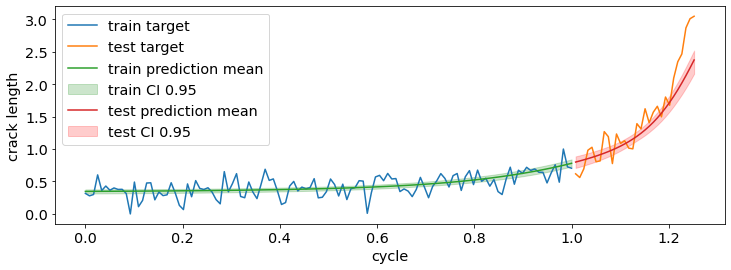

In [122]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric_mse = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


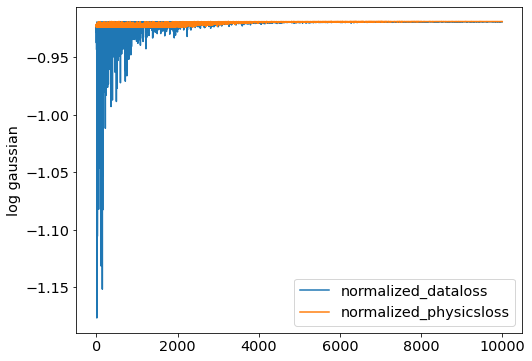

In [124]:

plt.figure(figsize=(8, 6))
plt.plot(mse_to_log_gaussian(metric_mse["normalized_dataloss"], torch.ones(1)), label="normalized_dataloss")
plt.plot(mse_to_log_gaussian(metric_mse["normalized_physicsloss"], torch.ones(1)), label="normalized_physicsloss")
plt.ylabel("log gaussian")
plt.legend()


 Epoch 1 loss = 0.030502423644065857
normalized data loss = 0.022273465991020203 ; normalized physics loss = 0.008228958584368229
data_norm = tensor(26.2073) differential_norm = tensor(6.5460e-06, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 0.010318266227841377
normalized data loss = 0.0009907850762829185 ; normalized physics loss = 0.009327481500804424
data_norm = tensor(26.2073) differential_norm = tensor(5.2304e-08, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 0.006010395009070635
normalized data loss = 0.0021019908599555492 ; normalized physics loss = 0.003908404149115086
data_norm = tensor(26.2073) differential_norm = tensor(1.4009e-08, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 0.0022339532151818275
normalized data loss = 0.000729198451153934 ; normalized physics loss = 0.0015047546476125717
data_norm = tensor(26.2073) differential_norm = tensor(1.1099e-07, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 0.0014944139402359724
normalized data loss = 0.000798839726485312 ; normalized 

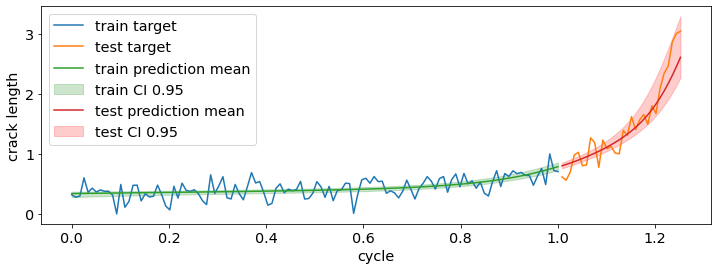

In [94]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=1, prior_std=1, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric_mse = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


## Bayes by backprop training

In [78]:
def compute_data_physics_loss_gaussian_nn(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler, physics_coeff, sample_size=10):
    
    samples_logprior, samples_logproposal, data_samples_loglikelihood, physics_samples_loglikelihood = 0., 0., 0., 0.
    inputphysics.requires_grad_(True)
    
    for samplecount in range(sample_size):
        # same sample for data and physics ?
        data_output = model.forward(inputdata)
        physics_output = model.forward(inputphysics)
        physics_constraint = 1 * paris_law(outputscaler.inverse(physics_output[0]), paris_C, paris_m, paris_dsigma)    
        # print(f"{data_prediction = } \n {physics_prediction = } \n {physics_constraint = }")
        
        samples_logprior += data_output[1] + physics_output[1]
        samples_logproposal += data_output[2] + physics_output[2] 
#         print(f"{samples_logprior = } {samples_logproposal = }")

        derivative = torch.autograd.grad(outputs=physics_output[0], inputs=inputphysics, 
            grad_outputs=torch.ones_like(inputphysics), retain_graph=True, create_graph=True)[0]
        rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)
        
        differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(targetdata**2)
        #         print(f"{data_norm = } {differential_norm = }")
        
        # print(f"{log_gaussian(targetdata, data_prediction, model.likelihood_std) = }")
        # data_samples_loglikelihood += log_gaussian(data_prediction, targetdata, model.likelihood_std).mean()
        # physics_samples_loglikelihood += log_gaussian(rescaled_derivative, physics_constraint, model.likelihood_std).mean()
        
        data_samples_loglikelihood += log_gaussian(data_output[0]/torch.sqrt(data_norm), targetdata/torch.sqrt(data_norm), model.likelihood_std).mean()
        physics_samples_loglikelihood += log_gaussian(rescaled_derivative/torch.sqrt(differential_norm), physics_constraint/torch.sqrt(differential_norm), model.likelihood_std).mean()
#         print(f"{data_samples_loglikelihood = } {physics_samples_loglikelihood = }")
        
        # data_samples_loglikelihood += mse_to_log_gaussian(tnf.mse_loss(data_prediction, targetdata)/data_norm, model.likelihood_std)
        # physics_samples_loglikelihood += mse_to_log_gaussian(tnf.mse_loss(physics_prediction, physics_constraint)/differential_norm, model.likelihood_std)
        
    return samples_logprior/sample_size, samples_logproposal/sample_size, \
        data_samples_loglikelihood/sample_size, physics_samples_loglikelihood/sample_size

In [79]:
def train_model_physics_magnitude_norm_gaussian_nn(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True, sample_size=10, kldiv_coeff=1):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = {key: np.empty(epochs) for key in "data_loglikelihood physics_loglikelihood logprior logproposal".split()}
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
        loss = torch.zeros(1)
        
        logprior, logproposal, data_loglikelihood, physics_loglikelihood = compute_data_physics_loss_gaussian_nn(
            paris_C, paris_m, paris_dsigma, model, traininput, trainlabel, physicsinput, 
            xscaler, yscaler, physics_coeff=physics_coeff, sample_size=sample_size)
#             dataloss, physicsloss, rescaled_derivative, physics_constraint, physics_prediction = compute_data_physics_loss_gaussian_nn(paris_C, paris_m, paris_dsigma, 
#                model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff, sample_size=sample_size)

#             differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
#             differential_norm = torch.sum(differential_norm**2)
#             data_norm = torch.sum(trainlabel**2)

#         elbo_datafit = data_loglikelihood + physics_loglikelihood
#         elbo_divergence = logproposal - logprior
#         elbo_loss = elbo_divergence - elbo_datafit
#         loss += elbo_loss
        loss = kldiv_coeff * (logproposal - logprior) - (data_loglikelihood + physics_loglikelihood)

        metric["data_loglikelihood"][epoch] = data_loglikelihood
        metric["physics_loglikelihood"][epoch] = physics_loglikelihood
        metric["logprior"][epoch] = logprior
        metric["logproposal"][epoch] = logproposal

#         metric["data_loglikelihood"][epoch][sample_count] = data_loglikelihood.detach().item()
#         metric["physics_loglikelihood"][epoch][sample_count] = physics_loglikelihood.detach().item()
#             metric["normalized_data_loglikelihood"][epoch][sample_count] = (data_loglikelihood / data_norm).detach().item()
#             metric["normalized_physics_loglikelihood"][epoch][sample_count] = (physics_loglikelihood / differential_norm).detach().item()
        
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
                
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f"{logprior = } ; {logproposal = } \n kl = {logproposal - logprior} ; log likelihood = {data_loglikelihood + physics_loglikelihood}")
            print(f"{data_loglikelihood = } {physics_loglikelihood = }")

#             print(f"normalized data loss = {(dataloss / data_norm).detach().item()} ; normalized physics loss = {(physicsloss / differential_norm).detach().item()}")
#             print(f"normalized data loss = {metric['normalized_data_loglikelihood'][epoch].mean()} ; normalized physics loss = {metric['normalized_physics_loglikelihood'][epoch].mean()}")
#             print(f"{data_norm = } {differential_norm = }")

#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

#             fig = plt.figure(figsize=(8,4))
#             plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
#             plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
#             plt.legend()
#             figs.append(fig)
            
#             plt.close()            
            
    # metric["data_loglikelihood"] = metric["data_loglikelihood"].mean(1)
    # metric["physics_loglikelihood"] = metric["physics_loglikelihood"].mean(1)
#     metric["normalized_data_loglikelihood"] = metric["normalized_data_loglikelihood"].mean(1)
#     metric["normalized_physics_loglikelihood"] = metric["normalized_physics_loglikelihood"].mean(1)
    
    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)
    
    return metric


 Epoch 1 loss = 1.7470629215240479
logprior = tensor(-1752.9359, grad_fn=<DivBackward0>) ; logproposal = tensor(-73.8537, grad_fn=<DivBackward0>) 
 kl = 1679.082275390625 ; log likelihood = -1.745383858680725
data_loglikelihood = tensor(-2.6892, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(0.9438, grad_fn=<DivBackward0>)

 Epoch 1001 loss = -2.481472969055176
logprior = tensor(-697.5342, grad_fn=<DivBackward0>) ; logproposal = tensor(-8.8033, grad_fn=<DivBackward0>) 
 kl = 688.7308959960938 ; log likelihood = 2.4821617603302
data_loglikelihood = tensor(1.2539, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.2283, grad_fn=<DivBackward0>)

 Epoch 2001 loss = -2.6450541019439697
logprior = tensor(-1651.6455, grad_fn=<DivBackward0>) ; logproposal = tensor(21.9657, grad_fn=<DivBackward0>) 
 kl = 1673.6112060546875 ; log likelihood = 2.6467278003692627
data_loglikelihood = tensor(1.3093, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.3374, grad_fn=<DivBackward0>

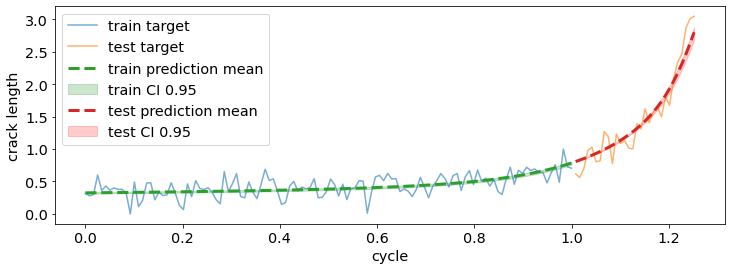

In [814]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
# figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_gaussian_nn(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, kldiv_coeff=1e-6)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


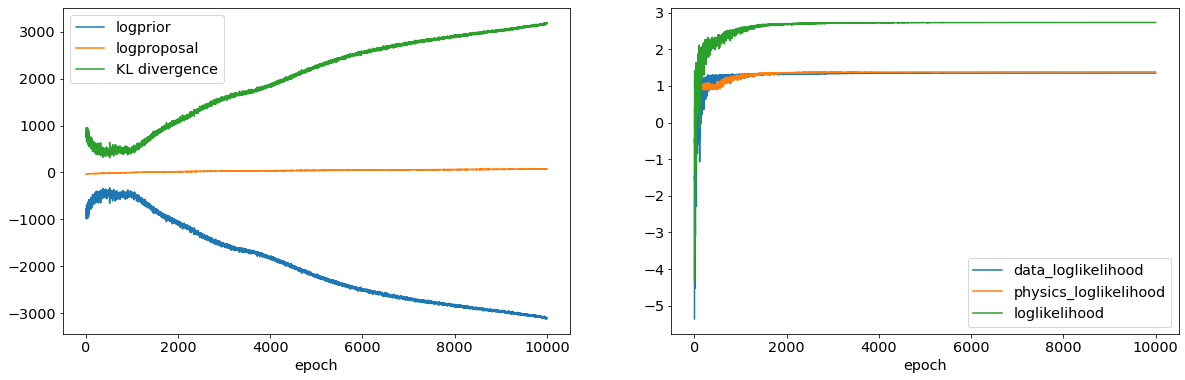

In [601]:
fig = plot_variational_training_metrics(metric)

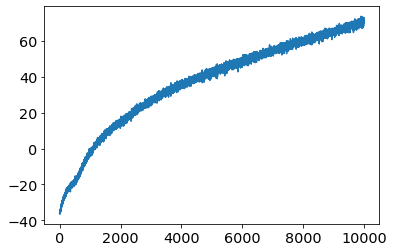

In [602]:
plt.plot(metric["logproposal"])

In [78]:
# torch.save(model.state_dict(), os.path.join(saved_model_path, "gaussian_mlp_1.pt"))
           
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()


 Epoch 1 loss = 1.9288904666900635
logprior = tensor(-106.5232, grad_fn=<DivBackward0>) ; logproposal = tensor(-72.1217, grad_fn=<DivBackward0>) 
 kl = 34.4014892578125 ; log likelihood = -1.9288560152053833
data_loglikelihood = tensor(-1.0063, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9225, grad_fn=<DivBackward0>)

 Epoch 1001 loss = 1.8412249088287354
logprior = tensor(-81.7423, grad_fn=<DivBackward0>) ; logproposal = tensor(-18.5293, grad_fn=<DivBackward0>) 
 kl = 63.21308135986328 ; log likelihood = -1.8411617279052734
data_loglikelihood = tensor(-0.9210, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9201, grad_fn=<DivBackward0>)

 Epoch 2001 loss = 1.8390260934829712
logprior = tensor(-83.7598, grad_fn=<DivBackward0>) ; logproposal = tensor(9.1183, grad_fn=<DivBackward0>) 
 kl = 92.8780517578125 ; log likelihood = -1.8389332294464111
data_loglikelihood = tensor(-0.9195, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9194, grad_fn=<DivBackwar

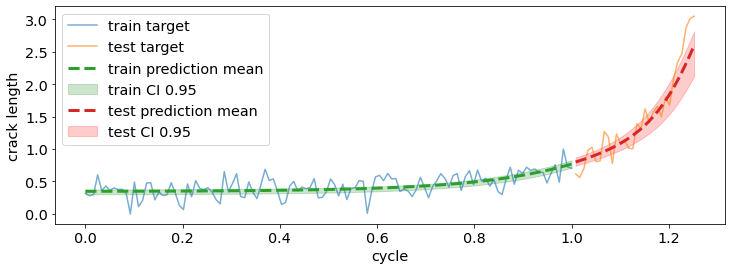

In [846]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=1, prior_std=1, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_gaussian_nn(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, kldiv_coeff=1e-6)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


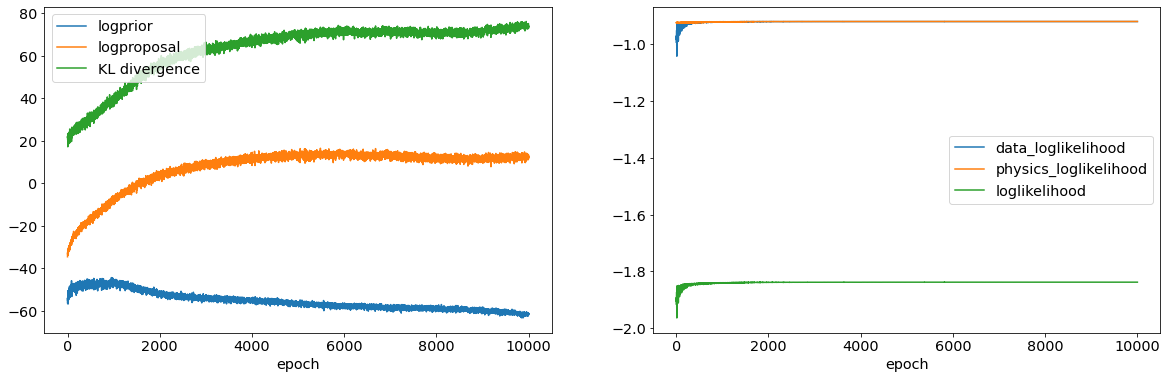

In [605]:
fig = plot_variational_training_metrics(metric)

In [606]:
# torch.save(model.state_dict(), os.path.join(saved_model_path, "gaussian_mlp_2.pt"))


<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

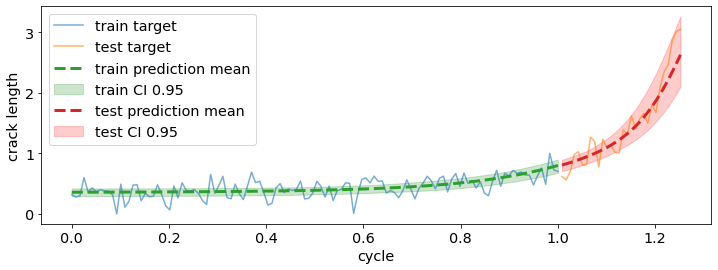

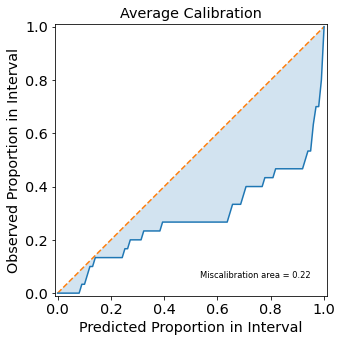

In [847]:
train_predictions = sample_prediction(model, train_xtensor, sample_size=100).squeeze().detach().numpy()
test_predictions = sample_prediction(model, test_xtensor, sample_size=100).squeeze().detach().numpy()
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")

test_mean, test_std = np.mean(test_predictions, 0), np.std(test_predictions, 0)
uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())


## Bayes by backprop experiment

In [808]:
def compute_data_physics_loss_debug(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler, physics_coeff, need_sample=True):
    
    data_output = model.forward(inputdata, need_sample)
    dataloss = tnf.mse_loss(data_output[0], targetdata)

    inputphysics.requires_grad_(True)
    physics_output = model.forward(inputphysics, need_sample)       

    derivative = torch.autograd.grad(outputs=physics_output[0], inputs=inputphysics, 
        grad_outputs=torch.ones_like(inputphysics), retain_graph=True, create_graph=True)[0]
    rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)
    
    physics_constraint = 1 * paris_law(outputscaler.inverse(physics_output[0]), paris_C, paris_m, paris_dsigma)
    physicsloss = physics_coeff * (rescaled_derivative - physics_constraint)**2
    
    return dataloss, torch.mean(physicsloss), rescaled_derivative, physics_constraint, physics_output[0]

def compute_data_physics_loss_gaussian_nn_debug(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler, physics_coeff, sample_size=10):
    
    samples_logprior, samples_logproposal, data_samples_loglikelihood, physics_samples_loglikelihood = 0., 0., 0., 0.
    inputphysics.requires_grad_(True)
    
    for samplecount in range(sample_size):
        data_output = model.forward(inputdata, need_sample=False)
        physics_output = model.forward(inputphysics, need_sample=False)
        physics_constraint = 1 * paris_law(outputscaler.inverse(physics_output[0]), paris_C, paris_m, paris_dsigma)    
        
        samples_logprior += data_output[1] + physics_output[1]
        samples_logproposal += data_output[2] + physics_output[2] 

        derivative = torch.autograd.grad(outputs=physics_output[0], inputs=inputphysics, 
            grad_outputs=torch.ones_like(inputphysics), retain_graph=True, create_graph=True)[0]
        rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)
        
        differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(targetdata**2)

        data_samples_loglikelihood += log_gaussian(data_output[0]/torch.sqrt(data_norm), targetdata/torch.sqrt(data_norm), model.likelihood_std).mean()
        physics_samples_loglikelihood += log_gaussian(rescaled_derivative/torch.sqrt(differential_norm), physics_constraint/torch.sqrt(differential_norm), model.likelihood_std).mean()
                    
    return samples_logprior/sample_size, samples_logproposal/sample_size, \
        data_samples_loglikelihood/sample_size, physics_samples_loglikelihood/sample_size

In [809]:
def train_model_physics_magnitude_norm_gaussian_nn_debug(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True, sample_size=10, kldiv_coeff=1):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = dict(dataloss=[], physicsloss=[], normalized_dataloss=[], normalized_physicsloss=[], 
        data_loglikelihood=np.empty(epochs), physics_loglikelihood=np.empty(epochs), logprior=np.empty(epochs), logproposal=np.empty(epochs))
    # metric = dict(data_loglikelihood=np.empty(epochs), physics_loglikelihood=np.empty(epochs), 
    #     logprior=np.empty(epochs), logproposal=np.empty(epochs))

    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
               
        dataloss, physicsloss, rescaled_derivative, physics_constraint, physics_prediction = compute_data_physics_loss_debug(paris_C, paris_m, paris_dsigma, 
           model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff, need_sample=sample_size > 1)
        
        differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(trainlabel**2)

        loss = dataloss / data_norm + physicsloss / differential_norm
        
        metric["dataloss"].append(dataloss.detach().item())
        metric["physicsloss"].append(physicsloss.detach().item())
        metric["normalized_dataloss"].append((dataloss / data_norm).detach().item())
        metric["normalized_physicsloss"].append((physicsloss / differential_norm).detach().item())
       
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
        
        logprior, logproposal, data_loglikelihood, physics_loglikelihood = compute_data_physics_loss_gaussian_nn_debug(
            paris_C, paris_m, paris_dsigma, model, traininput, trainlabel, physicsinput, 
            xscaler, yscaler, physics_coeff=physics_coeff, sample_size=sample_size)
                
        negative_elbo = kldiv_coeff * (logproposal - logprior) - (data_loglikelihood + physics_loglikelihood)
            
        metric["data_loglikelihood"][epoch] = data_loglikelihood
        metric["physics_loglikelihood"][epoch] = physics_loglikelihood
        metric["logprior"][epoch] = logprior
        metric["logproposal"][epoch] = logproposal

        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f"normalized data loss = {metric['normalized_dataloss'][-1]} ; normalized physics loss = {metric['normalized_physicsloss'][-1]}")
            print(f"{data_norm = } {differential_norm = }")

            print(f"{negative_elbo = }")
            print(f"{logprior = } ; {logproposal = } \n kl = {logproposal - logprior} ; log likelihood = {data_loglikelihood + physics_loglikelihood}")
            print(f"{data_loglikelihood = } {physics_loglikelihood = }")

#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

#             fig = plt.figure(figsize=(8,4))
#             plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
#             plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
#             plt.legend()
#             figs.append(fig)
            
#             plt.close()            
            
    
    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)
    
    return metric


 Epoch 1 loss = 0.03024439513683319
normalized data loss = 0.020396791398525238 ; normalized physics loss = 0.009847603738307953
data_norm = tensor(26.2073) differential_norm = tensor(1.5735e-05, grad_fn=<SumBackward0>)
negative_elbo = tensor(1462.2053, grad_fn=<SubBackward0>)
logprior = tensor(-1535.6874, grad_fn=<DivBackward0>) ; logproposal = tensor(-71.5525, grad_fn=<DivBackward0>) 
 kl = 1464.1348876953125 ; log likelihood = 1.9295766353607178
data_loglikelihood = tensor(1.0451, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(0.8845, grad_fn=<DivBackward0>)

 Epoch 1001 loss = 0.0012455775868147612
normalized data loss = 0.0009354000794701278 ; normalized physics loss = 0.00031017750734463334
data_norm = tensor(26.2073) differential_norm = tensor(5.8492e-07, grad_fn=<SumBackward0>)
negative_elbo = tensor(4470.1240, grad_fn=<SubBackward0>)
logprior = tensor(-4438.3232, grad_fn=<DivBackward0>) ; logproposal = tensor(34.5150, grad_fn=<DivBackward0>) 
 kl = 4472.83837890625 ; 

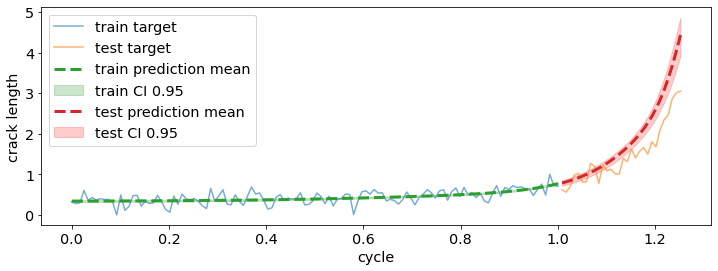

In [810]:
model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
metric_debug = train_model_physics_magnitude_norm_gaussian_nn_debug(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


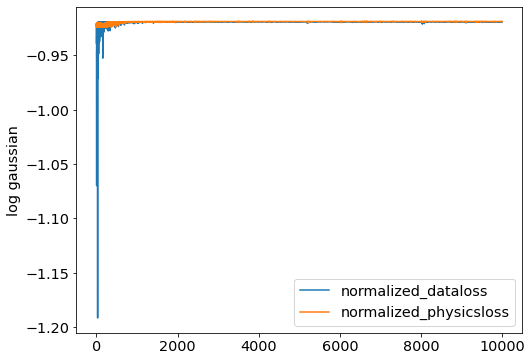

In [105]:
plt.figure(figsize=(8, 6))
plt.plot(mse_to_log_gaussian(metric_debug["normalized_dataloss"], 1), label="normalized_dataloss")
plt.plot(mse_to_log_gaussian(metric_debug["normalized_physicsloss"], 1), label="normalized_physicsloss")
plt.ylabel("log gaussian")
plt.legend()

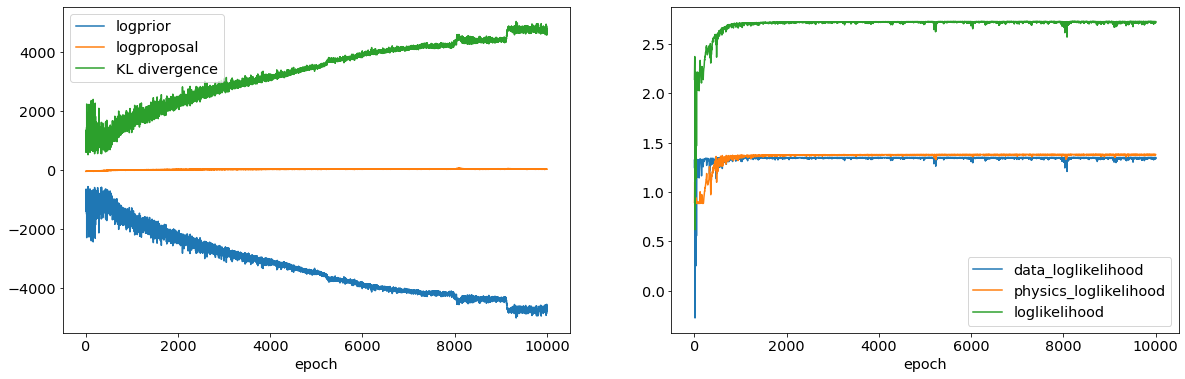

In [106]:
fig = plot_variational_training_metrics(metric_debug)


 Epoch 1 loss = 0.011202128604054451
normalized data loss = 0.0012021285947412252 ; normalized physics loss = 0.009999999776482582
data_norm = tensor(26.2073) differential_norm = tensor(2.0850e-08, grad_fn=<SumBackward0>)
negative_elbo = tensor(-2.0857, grad_fn=<RsubBackward1>)
logprior = 0.0 ; logproposal = 0.0 
 kl = 0.0 ; log likelihood = 2.0857419967651367
data_loglikelihood = tensor(1.2021, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(0.8836, grad_fn=<DivBackward0>)

 Epoch 101 loss = 0.0011692247353494167
normalized data loss = 0.0007443843060173094 ; normalized physics loss = 0.0004248404293321073
data_norm = tensor(26.2073) differential_norm = tensor(4.0304e-07, grad_fn=<SumBackward0>)
negative_elbo = tensor(-2.7094, grad_fn=<RsubBackward1>)
logprior = 0.0 ; logproposal = 0.0 
 kl = 0.0 ; log likelihood = 2.709378242492676
data_loglikelihood = tensor(1.3441, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.3652, grad_fn=<DivBackward0>)

 Epoch 201 loss = 0.00

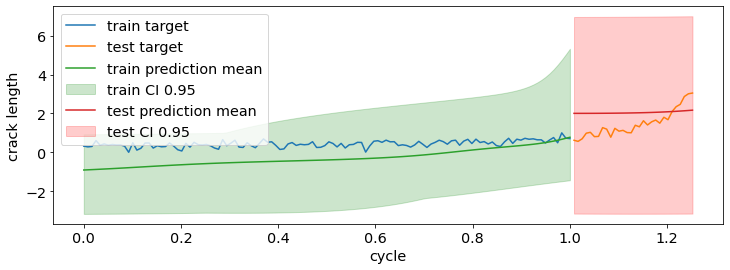

In [107]:
# no sampling, just the mean
model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
figs=[]
epochs = 1000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
metric_mse = train_model_physics_magnitude_norm_gaussian_nn_debug(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=1)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


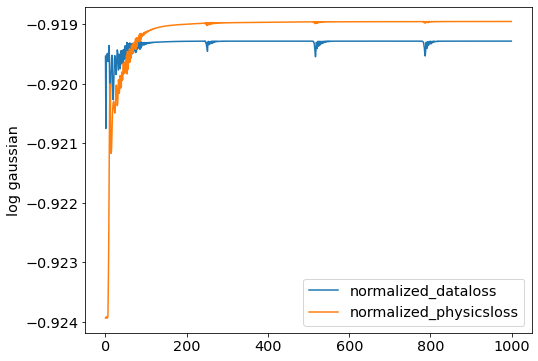

In [108]:
plt.figure(figsize=(8, 6))
plt.plot(mse_to_log_gaussian(metric_mse["normalized_dataloss"], 1), label="normalized_dataloss")
plt.plot(mse_to_log_gaussian(metric_mse["normalized_physicsloss"], 1), label="normalized_physicsloss")
plt.ylabel("log gaussian")
plt.legend()

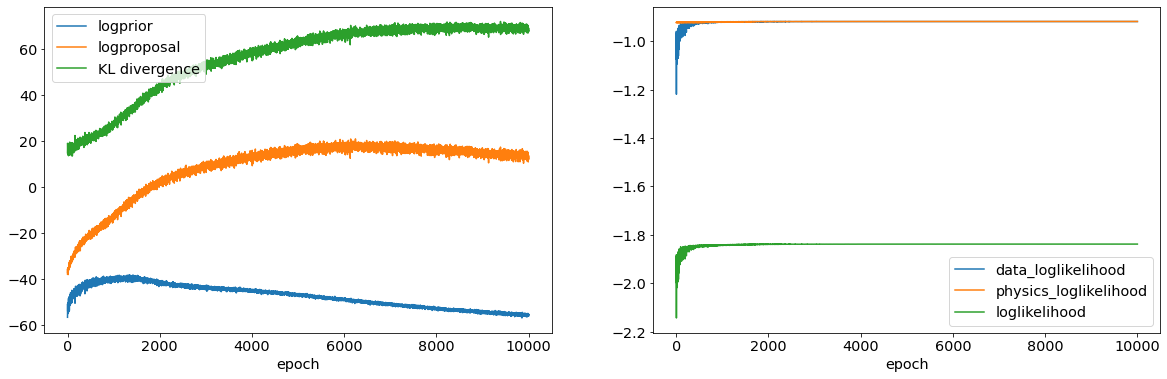

In [109]:
fig = plot_variational_training_metrics(metric)

In [811]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh, need_output_exp=True).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_gaussian_nn(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, kldiv_coeff=1e-6)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


TypeError: only integer tensors of a single element can be converted to an index

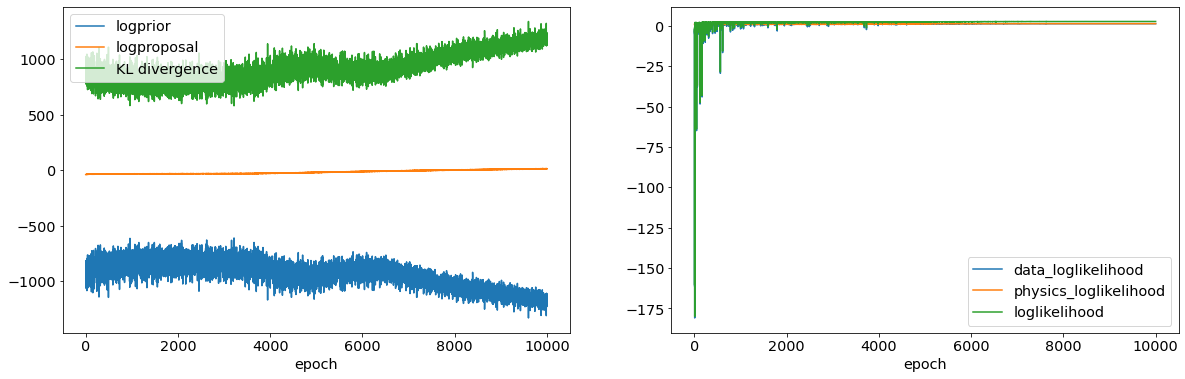

In [111]:
fig = plot_variational_training_metrics(metric)


 Epoch 1 loss = 0.6858266592025757
logprior = tensor(-1016.0873, grad_fn=<DivBackward0>) ; logproposal = tensor(-37.5478, grad_fn=<DivBackward0>) 
 kl = 978.5394897460938 ; log likelihood = -0.6760412454605103
data_loglikelihood = tensor(-1.6237, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(0.9477, grad_fn=<DivBackward0>)

 Epoch 1001 loss = -2.503217935562134
logprior = tensor(-437.2404, grad_fn=<DivBackward0>) ; logproposal = tensor(-4.0964, grad_fn=<DivBackward0>) 
 kl = 433.1440124511719 ; log likelihood = 2.507549285888672
data_loglikelihood = tensor(1.2849, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.2227, grad_fn=<DivBackward0>)

 Epoch 2001 loss = -2.6801598072052
logprior = tensor(-980.4032, grad_fn=<DivBackward0>) ; logproposal = tensor(11.3535, grad_fn=<DivBackward0>) 
 kl = 991.7567138671875 ; log likelihood = 2.690077304840088
data_loglikelihood = tensor(1.3374, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.3527, grad_fn=<DivBackward0>)



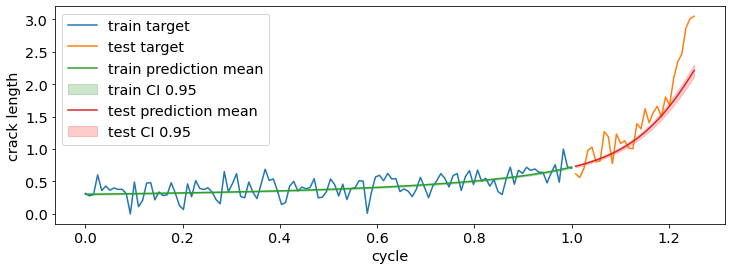

In [112]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_gaussian_nn(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, kldiv_coeff=1e-5)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


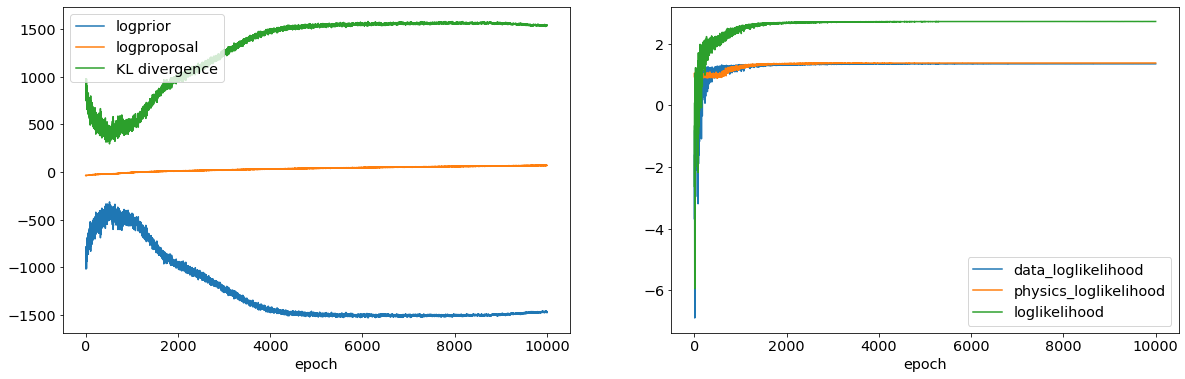

In [113]:
fig = plot_variational_training_metrics(metric)


 Epoch 1 loss = -1.7974351644515991
logprior = tensor(-903.6749, grad_fn=<DivBackward0>) ; logproposal = tensor(-36.6643, grad_fn=<DivBackward0>) 
 kl = 867.0106201171875 ; log likelihood = 1.7975218296051025
data_loglikelihood = tensor(0.7550, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.0425, grad_fn=<DivBackward0>)

 Epoch 1001 loss = -2.5757317543029785
logprior = tensor(-437.4589, grad_fn=<DivBackward0>) ; logproposal = tensor(0.1101, grad_fn=<DivBackward0>) 
 kl = 437.56903076171875 ; log likelihood = 2.575775623321533
data_loglikelihood = tensor(1.3018, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.2739, grad_fn=<DivBackward0>)

 Epoch 2001 loss = -2.6846470832824707
logprior = tensor(-1269.8998, grad_fn=<DivBackward0>) ; logproposal = tensor(17.5876, grad_fn=<DivBackward0>) 
 kl = 1287.4874267578125 ; log likelihood = 2.6847758293151855
data_loglikelihood = tensor(1.3364, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.3483, grad_fn=<DivBackward

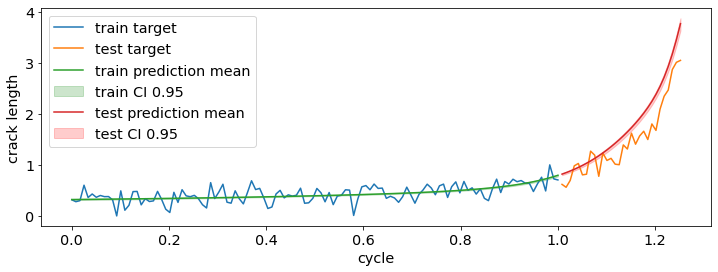

In [114]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_gaussian_nn(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, kldiv_coeff=1e-7)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


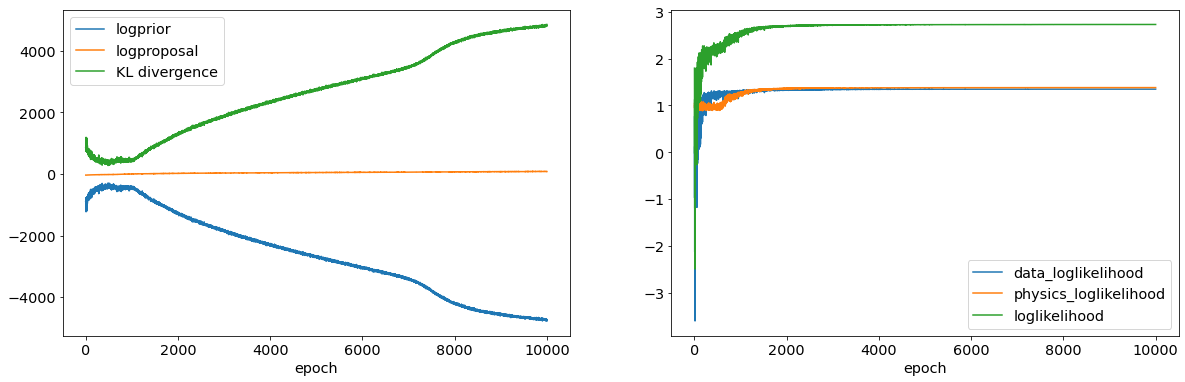

In [115]:
fig = plot_variational_training_metrics(metric)


 Epoch 1 loss = 4.763360500335693
logprior = tensor(-1076.5250, grad_fn=<DivBackward0>) ; logproposal = tensor(-40.1416, grad_fn=<DivBackward0>) 
 kl = 1036.3834228515625 ; log likelihood = -4.659722328186035
data_loglikelihood = tensor(-5.6101, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(0.9504, grad_fn=<DivBackward0>)

 Epoch 1001 loss = -2.496668577194214
logprior = tensor(-356.6952, grad_fn=<DivBackward0>) ; logproposal = tensor(-2.8871, grad_fn=<DivBackward0>) 
 kl = 353.80810546875 ; log likelihood = 2.5320494174957275
data_loglikelihood = tensor(1.3040, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.2281, grad_fn=<DivBackward0>)

 Epoch 2001 loss = -2.602379322052002
logprior = tensor(-553.5103, grad_fn=<DivBackward0>) ; logproposal = tensor(14.3182, grad_fn=<DivBackward0>) 
 kl = 567.8284301757812 ; log likelihood = 2.6591622829437256
data_loglikelihood = tensor(1.3337, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.3255, grad_fn=<DivBackward0>)


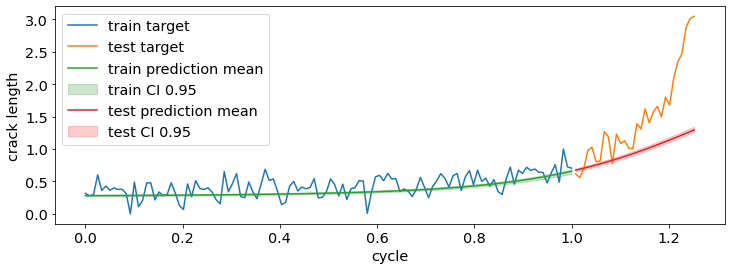

In [74]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_gaussian_nn(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, kldiv_coeff=1e-4)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")



 Epoch 1 loss = 2.044314384460449
logprior = tensor(-126.5734, grad_fn=<DivBackward0>) ; logproposal = tensor(-86.3284, grad_fn=<DivBackward0>) 
 kl = 40.244964599609375 ; log likelihood = -2.044314384460449
data_loglikelihood = tensor(-1.1216, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9227, grad_fn=<DivBackward0>)

 Epoch 1001 loss = 1.841874599456787
logprior = tensor(-99.7297, grad_fn=<DivBackward0>) ; logproposal = tensor(-50.6213, grad_fn=<DivBackward0>) 
 kl = 49.10839080810547 ; log likelihood = -1.841874599456787
data_loglikelihood = tensor(-0.9202, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9217, grad_fn=<DivBackward0>)

 Epoch 2001 loss = 1.8394343852996826
logprior = tensor(-101.9464, grad_fn=<DivBackward0>) ; logproposal = tensor(-20.8211, grad_fn=<DivBackward0>) 
 kl = 81.12522888183594 ; log likelihood = -1.8394343852996826
data_loglikelihood = tensor(-0.9198, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9196, grad_fn=<DivBackw

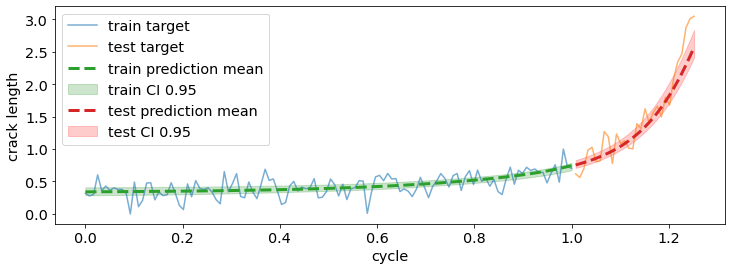

In [82]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=1, prior_std=1, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_gaussian_nn(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, kldiv_coeff=0)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")



 Epoch 1 loss = 1.935093879699707
logprior = tensor(-122.9924, grad_fn=<DivBackward0>) ; logproposal = tensor(-76.3059, grad_fn=<DivBackward0>) 
 kl = 46.686500549316406 ; log likelihood = -1.9350471496582031
data_loglikelihood = tensor(-1.0120, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9230, grad_fn=<DivBackward0>)

 Epoch 501 loss = 1.8434720039367676
logprior = tensor(-105.6963, grad_fn=<DivBackward0>) ; logproposal = tensor(-50.6665, grad_fn=<DivBackward0>) 
 kl = 55.02972412109375 ; log likelihood = -1.8434169292449951
data_loglikelihood = tensor(-0.9205, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9229, grad_fn=<DivBackward0>)

 Epoch 1001 loss = 1.8397682905197144
logprior = tensor(-101.9064, grad_fn=<DivBackward0>) ; logproposal = tensor(-31.1773, grad_fn=<DivBackward0>) 
 kl = 70.72907257080078 ; log likelihood = -1.8396975994110107
data_loglikelihood = tensor(-0.9199, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9198, grad_fn=<DivBa

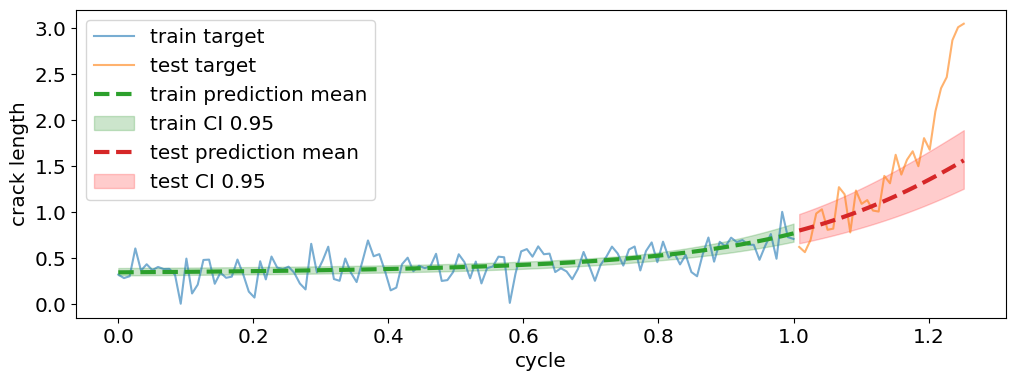

In [441]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=1, prior_std=1, activation=nn.Tanh).to(device)
figs=[]
epochs = 5000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_gaussian_nn(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, kldiv_coeff=1e-6)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


## Profile execution time

In [152]:
model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
figs=[]
epochs = 1
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)


In [154]:
%lprun -f train_model_physics_magnitude_norm_gaussian_nn train_model_physics_magnitude_norm_gaussian_nn(model, train_xtensor, train_ytensor, physics_xtensor, \
train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,\
optim=optim, sample_size=10, kldiv_coeff=1e-7)


 Epoch 1 loss = 0.5664030313491821
logprior = tensor(-937.9520, grad_fn=<DivBackward0>) ; logproposal = tensor(-35.7355, grad_fn=<DivBackward0>) 
 kl = 902.2164916992188 ; log likelihood = -0.5663127899169922
data_loglikelihood = tensor(-1.5989, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.0326, grad_fn=<DivBackward0>)


Timer unit: 1e-06 s

Total time: 0.05063 s
File: /tmp/ipykernel_15612/4170980669.py
Function: train_model_physics_magnitude_norm_gaussian_nn at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def train_model_physics_magnitude_norm_gaussian_nn(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
     2                                               paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True, sample_size=10, kldiv_coeff=1):
     3                                               
     4         1          5.0      5.0      0.0      if optim is None:
     5                                                   optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
     6                                               
     7         1         25.0     25.0      0.0      traininput = traininput.to(device)
     8         1          9.0      9.0      0.0      

In [160]:
%lprun -f compute_data_physics_loss_gaussian_nn compute_data_physics_loss_gaussian_nn(paris_C, paris_m, paris_dsigma, \
model, train_xtensor, train_ytensor, physics_xtensor, train_xscaler_torch, train_yscaler_torch, physics_coeff=1, sample_size=10)


Timer unit: 1e-06 s

Total time: 0.034435 s
File: /tmp/ipykernel_15612/131613924.py
Function: compute_data_physics_loss_gaussian_nn at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def compute_data_physics_loss_gaussian_nn(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
     2                                               inputscaler, outputscaler, physics_coeff, sample_size=10):
     3                                               
     4         1          4.0      4.0      0.0      samples_logprior, samples_logproposal, data_samples_loglikelihood, physics_samples_loglikelihood = 0., 0., 0., 0.
     5         1         11.0     11.0      0.0      inputphysics.requires_grad_(True)
     6                                               
     7        11         17.0      1.5      0.0      for samplecount in range(sample_size):
     8        10      15845.0   1584.5     46.0          dat

In [162]:
%lprun -f model.forward model.forward(train_xtensor)

Timer unit: 1e-06 s

Total time: 0.004651 s
File: /tmp/ipykernel_15612/3685460412.py
Function: forward at line 61

Line #      Hits         Time  Per Hit   % Time  Line Contents
    61                                               def forward(self, indata, need_sample=True):        
    62         1          3.0      3.0      0.1          outdata = indata
    63         6         40.0      6.7      0.9          for layer in self.layers:
    64         5         10.0      2.0      0.2              if isinstance(layer, GaussianLinear):
    65         3       4455.0   1485.0     95.8                  outdata = layer(outdata, need_sample)
    66                                                       else:
    67         2        140.0     70.0      3.0                  outdata = layer(outdata)
    68                                                   
    69         1          2.0      2.0      0.0          if self.need_output_exp: outdata = torch.exp(outdata)
    70                         

In [165]:
gaussian_layer = GaussianLinear(1, 4, 1).to(device)

In [166]:
%lprun -f gaussian_layer.forward gaussian_layer.forward(train_xtensor)

Timer unit: 1e-06 s

Total time: 0.002288 s
File: /tmp/ipykernel_15612/3685460412.py
Function: forward at line 21

Line #      Hits         Time  Per Hit   % Time  Line Contents
    21                                               def forward(self, inputdata, need_sample=True):
    22         1          3.0      3.0      0.1          if not need_sample:
    23                                                       output = torch.mm(inputdata, self.weight_mean) + self.bias_mean.expand(inputdata.size()[0], self.outputsize)
    24                                                       return output
    25                                                   
    26                                           #         epsilon_W, epsilon_b = self.get_random()
    27         1        799.0    799.0     34.9          epsilon_weight = self.normal01.sample(self.weight_mean.shape).to(device)
    28         1        496.0    496.0     21.7          epsilon_bias = self.normal01.sample(self.bias_mean.sha

## Inspect Gaussian MLP

In [228]:
loaded_model = GaussianMLP([1, 4, 4, 1], likelihood_std=1, prior_std=1, activation=nn.Tanh)

loaded_model.load_state_dict(torch.load(os.path.join(saved_model_path, "gaussian_mlp_2.pt")))
loaded_model.eval()

GaussianMLP(
  (layers): Sequential(
    (0): GaussianLinear()
    (1): Tanh()
    (2): GaussianLinear()
    (3): Tanh()
    (4): GaussianLinear()
  )
)

In [229]:
# for name, params in loaded_model.named_parameters():
#     print(name, "=", params)
loaded_model.state_dict()

OrderedDict([('layers.0.weight_mean',
              tensor([[ 0.0116, -1.2247, -2.2184, -0.0546]])),
             ('layers.0.weight_logstd',
              tensor([[-1.5764, -3.4394, -4.0681, -1.6140]])),
             ('layers.0.bias_mean',
              tensor([[-0.0374,  1.3839,  2.7647,  0.0204]])),
             ('layers.0.bias_logstd',
              tensor([[-1.5435, -3.3320, -3.9313, -1.7500]])),
             ('layers.2.weight_mean',
              tensor([[-1.0756e-01,  3.0579e-02,  2.2353e-02, -4.2608e-02],
                      [ 3.1735e-01,  9.3018e-03, -8.2449e-01, -1.6175e+00],
                      [-7.2592e-02, -6.4570e-02, -1.4871e+00, -3.9015e+00],
                      [ 1.8964e-02,  2.4528e-04, -3.8814e-02, -8.1190e-03]])),
             ('layers.2.weight_logstd',
              tensor([[-0.0581,  0.3013, -2.0760, -1.2987],
                      [-0.6297, -0.0204, -2.3553, -1.0474],
                      [-0.9125, -0.2468, -2.8952, -1.3940],
                      [-0.0299,

In [230]:
# OrderedDict({key:value for key, value in loaded_model.state_dict().items() if "weight_mean" in key})
for param in loaded_model.state_dict():
    print(param)

layers.0.weight_mean
layers.0.weight_logstd
layers.0.bias_mean
layers.0.bias_logstd
layers.2.weight_mean
layers.2.weight_logstd
layers.2.bias_mean
layers.2.bias_logstd
layers.4.weight_mean
layers.4.weight_logstd
layers.4.bias_mean
layers.4.bias_logstd


In [231]:
def plot_model_parameter(model, selected_key, figsize=(16, 4)):
    statedict = model.state_dict()
    selected_params = OrderedDict({key: param for key, param in statedict.items() if selected_key in key})
    
    fig, axes = plt.subplots(len(selected_params)//3, 3, figsize=(figsize))
    axes = axes.flatten()
    
    for ax, (key, param) in zip(axes, selected_params.items()):
        # print(key, param.shape, param.ndim)
        if "logstd" in selected_key: 
            param = reparameterize_std(param)
            key += " reparam"
        im = ax.imshow(param)
        ax.set_title(key)
        ax.figure.colorbar(im, ax=ax)
        
    return fig


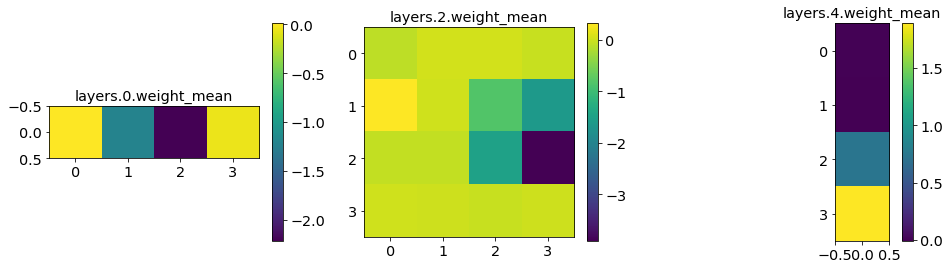

In [232]:
fig = plot_model_parameter(loaded_model, "weight_mean")

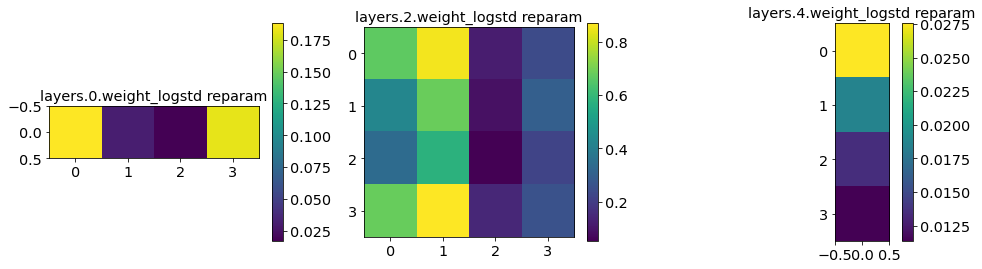

In [233]:
fig = plot_model_parameter(loaded_model, "weight_logstd")

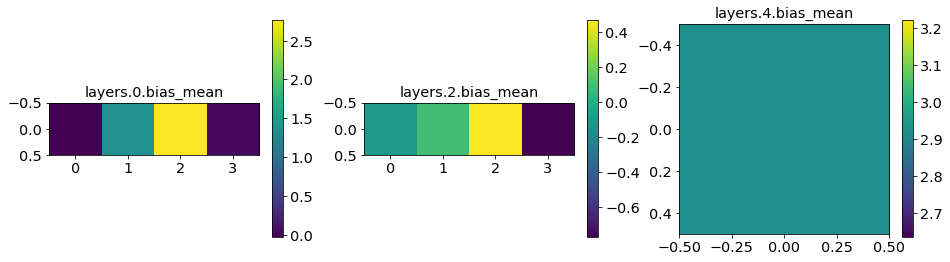

In [234]:
fig = plot_model_parameter(loaded_model, "bias_mean")

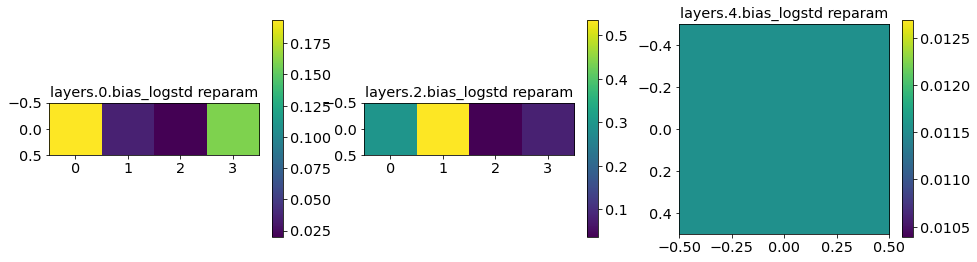

In [235]:
fig = plot_model_parameter(loaded_model, "bias_logstd")

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

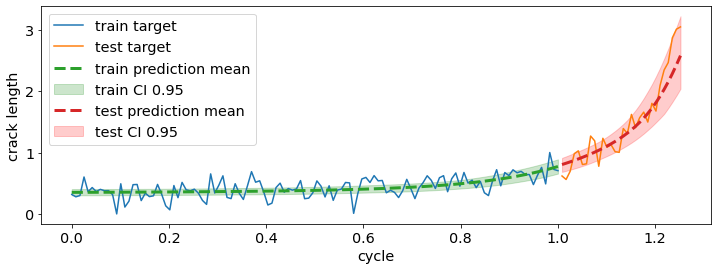

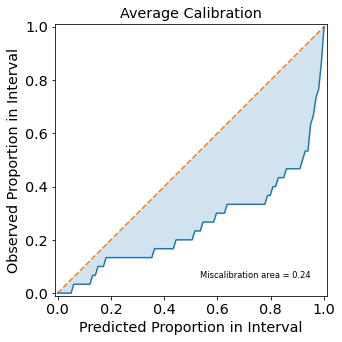

In [353]:
train_predictions = sample_prediction(loaded_model, train_xtensor, sample_size=100).squeeze().detach().numpy()
test_predictions = sample_prediction(loaded_model, test_xtensor, sample_size=100).squeeze().detach().numpy()
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")

test_mean, test_std = np.mean(test_predictions, 0), np.std(test_predictions, 0)
uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())


<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

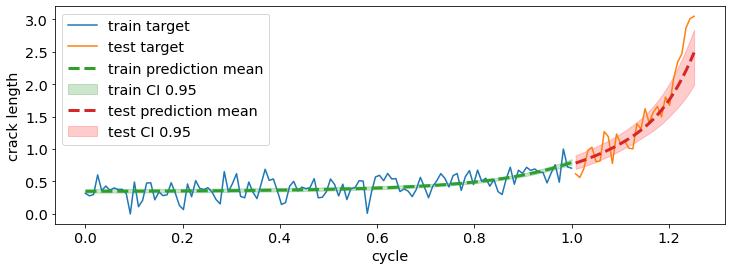

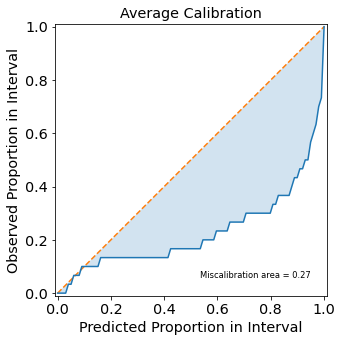

In [354]:
train_predictions = sample_prediction(loaded_model, train_xtensor, sample_size=10).squeeze().detach().numpy()
test_predictions = sample_prediction(loaded_model, test_xtensor, sample_size=10).squeeze().detach().numpy()
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")

test_mean, test_std = np.mean(test_predictions, 0), np.std(test_predictions, 0)
uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())


 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 12.38it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 12.38it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.203
  RMSE          0.262
  MDAE          0.148
  MARPD         14.386
  R2            0.854
  Correlation   0.969
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.293
  Mean-absolute Calibration Error       0.251
  Miscalibration Area                   0.253
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.469
     Group Size: 0.56 -- Calibration Error: 0.327
     Group Size: 1.00 -- Calibration Error: 0.251
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.547
     Group Size: 0.56 -- Calibration Error: 0.381
     Group Size: 1.00 -- Calibration Error: 0.293
===============

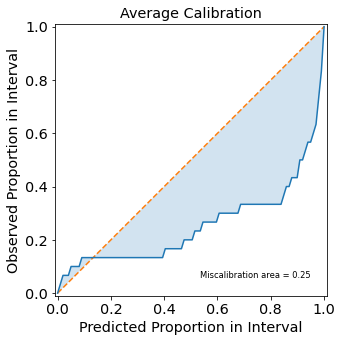

In [350]:
metrics = uct.metrics.get_all_metrics(test_mean, test_std, test_ytensor.numpy().squeeze())

## Gaussian Neural Network with Maximum Mean Discrepancy 

https://arxiv.org/pdf/2003.00952.pdf

https://github.com/Saswatm123/MMD-VAE/blob/master/MMD_VAE.ipynb

https://github.com/napsternxg/pytorch-practice/blob/master/Pytorch%20-%20MMD%20VAE.ipynb

https://chchannn.github.io/posts/maximum-mean-discrepancy-for-dummies/

https://stats.stackexchange.com/questions/276497/maximum-mean-discrepancy-distance-distribution

https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/


RBF kernel:
$$k(x,y) = exp \left(- \frac {||x-y||^2} {2l^2} \right)$$

\begin{align}
X \sim p(X), Y \sim q(Y) \\
MMD^2[p,q] = E_{p} [k(X, X)] + E_{q} [k(Y, Y)] - 2 E_{p, q} [k(X,Y)]
\end{align}

In [343]:
def rbf_kernel(x, y, lengthscale=1):
    distance2 = torch.linalg.norm(x-y)**2
    # print(x, y, x-y, distance2, sep='\n')
    return torch.exp(-1/2 * distance2 / lengthscale**2)
    
    # dim1_1, dim1_2 = a.shape[0], b.shape[0]
    # depth = a.shape[1]
    # a = a.view(dim1_1, 1, depth)
    # b = b.view(1, dim1_2, depth)
    # a_core = a.expand(dim1_1, dim1_2, depth)
    # b_core = b.expand(dim1_1, dim1_2, depth)
    # numerator = (a_core - b_core).pow(2).mean(2)/depth
    # return torch.exp(-numerator)

def MMD(x, y):
    return rbf_kernel(x, x).mean() + rbf_kernel(y, y).mean() - 2*rbf_kernel(x, y).mean()

Distance matrix:
\begin{align}
X = \begin{bmatrix} x_{11} & x_{12} & x_{13} \\ x_{21} & x_{22} & x_{23} \\ x_{31} & x_{32} & x_{33} 
\end{bmatrix} ;
X^T = \begin{bmatrix} x_{11} & x_{21} & x_{31} \\ x_{12} & x_{22} & x_{32} \\ x_{13} & x_{23} & x_{33} 
\end{bmatrix}
\\
x_i^T = \begin{bmatrix} x_{i1} & x_{i2} & x_{i3} \end{bmatrix} = \text{row i of matrix X as row} ; x_i = \text{row i of matrix x as column}
\\
XX^T = \begin{bmatrix} 
x_1^T x_1 & x_1^T x_2 & x_1^T x_3 \\ 
x_2^T x_1 & x_2^T x_2 & x_2^T x_3 \\ 
x_3^T x_1 & x_3^T x_2 & x_3^T x_3 \end{bmatrix}
\\\\
D\_E = diag-expand (XX^T) = \begin{bmatrix} 
x_1^T x_1 & x_2^T x_2 & x_3^T x_3 \\
x_1^T x_1 & x_2^T x_2 & x_3^T x_3 \\
x_1^T x_1 & x_2^T x_2 & x_3^T x_3 \end{bmatrix}
;
D\_E^T = \begin{bmatrix} 
x_1^T x_1 & x_1^T x_1 & x_1^T x_1 \\
x_2^T x_2 & x_2^T x_2 & x_2^T x_2 \\
x_3^T x_3 & x_3^T x_3 & x_3^T x_3 \end{bmatrix}
\\\\
D\_E + D\_E^T - 2 XX^T = \begin{bmatrix}
||x_1 - x_1||^2 & ||x_1 - x_2||^2 & ||x_1 - x_3||^2 \\
||x_2 - x_1||^2 & ||x_2 - x_2||^2 & ||x_2 - x_3||^2 \\
||x_3 - x_1||^2 & ||x_3 - x_2||^2 & ||x_3 - x_3||^2 \\
\end{bmatrix}
\end{align}

Similarly, for
\begin{align}
Y = \begin{bmatrix} y_{11} & y_{12} & y_{13} \\ y_{21} & y_{22} & y_{23} \\ y_{31} & y_{32} & y_{33} \end{bmatrix}
\\
D\_E(XX^T) + D\_E^T(YY^T) - 2 XY^T = \begin{bmatrix}
||x_1 - y_1||^2 & ||x_1 - y_2||^2 & ||x_1 - y_3||^2 \\
||x_2 - y_1||^2 & ||x_2 - y_2||^2 & ||x_2 - y_3||^2 \\
||x_3 - y_1||^2 & ||x_3 - y_2||^2 & ||x_3 - y_3||^2 \\
\end{bmatrix}
\end{align}


In [87]:
# https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy/notebook

def similarity_matrix(mat):
    # (x - y)^2 = x^2 - 2*x*y + y^2
    # get the product x * y
    # here, y = x.t()
    r = torch.mm(mat, mat.t())
    print(r)
    # get the diagonal elements
    diag = r.diag().unsqueeze(0)
    print(diag)
    diag = diag.expand_as(r)
    print(diag)
    # compute the distance matrix
    D = diag + diag.t() - 2*r
    return D.sqrt()

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, xy = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * xy # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
    return torch.mean(XX + YY - 2. * XY)

In [88]:
# https://github.com/ispamm/MMD-Bayesian-Neural-Network/blob/master/bayesian_utils.py

def pdist(p, q):
    pdim, qdim = p.size(0), q.size(0)
    pnorm = torch.sum(p ** 2, dim=1, keepdim=True)
    qnorm = torch.sum(q ** 2, dim=1, keepdim=True)
    norms = (pnorm.expand(pdim, qdim) +
             qnorm.transpose(0, 1).expand(pdim, qdim))
    distances_squared = norms - 2 * p.mm(q.t())
    return torch.sqrt(1e-5 + torch.abs(distances_squared))


def pairwise_distances(x, y):
    x_norm = (x ** 2).sum(1).view(-1, 1)
    y_norm = (y ** 2).sum(1).view(1, -1)

    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))
    return torch.clamp(dist, 0.0, np.inf)


def compute_mmd(x, y, type='inverse', biased=True, space=None, max=False):
    d = x.device

    xs = x.shape[0]
    XX, YY, XY = torch.zeros([xs, xs]).to(d), torch.zeros([xs, xs]).to(d), torch.zeros([xs, xs]).to(d)
    xxd = pdist(x, x) ** 2
    yyd = pdist(y, y) ** 2
    xyd = pdist(x, y) ** 2

    if type == 'rbf':

        if space is None:
            # space = [0.5, 1, 2, 4, 8, 16]
            space = [10, 15, 20, 50]


        for gamma in space:
            gamma = 1.0 / (2 * gamma ** 2)

            xx = torch.exp(-xxd * gamma)
            yy = torch.exp(-yyd * gamma)
            xy = torch.exp(-xyd * gamma)

            XX += xx
            YY += yy
            XY += xy

    elif type == 'inverse':

        if space is None:
            space = [0.05, 0.2, 0.6, 0.9, 1]

        for a in space:
            a = a ** 2
            xxk = torch.div(1, torch.sqrt(a + xxd))
            yyk = torch.div(1, torch.sqrt(a + yyd))
            xyk = torch.div(1, torch.sqrt(a + xyd))

            XX += xxk
            YY += yyk
            XY += xyk
    else:
        return None

    if biased:
        mmd = XX.mean() + YY.mean() - 2 * XY.mean()
    else:
        XX = XX.sum() - XX.trace()
        YY = YY.sum() - YY.trace()
        XY = XY.sum()
        mmd = (1 / (xs ** 2)) * XX + (1 / (xs ** 2)) * YY - (2 / (xs * xs)) * XY

    return tnf.relu(mmd)

In [89]:
m = 100 # sample size
x_mean = torch.zeros(2)+1
y_mean = torch.zeros(2)
x_cov = 2*torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
y_cov = 3*torch.eye(2) - 1

px = torch.distributions.MultivariateNormal(x_mean, x_cov)
qy = torch.distributions.MultivariateNormal(y_mean, y_cov)
x = px.sample([m])
y = qy.sample([m])

print(x.shape, y.shape)
print(MMD(x, y, kernel="rbf"), compute_mmd(x,y, type="rbf"))

torch.Size([100, 2]) torch.Size([100, 2])
tensor(0.3026) tensor(0.0345)


In [90]:
m = 100 # sample size
x_mean = torch.zeros(2)
y_mean = torch.zeros(2)
x_cov = 2*torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
y_cov = 2*torch.eye(2)

px = torch.distributions.MultivariateNormal(x_mean, x_cov)
qy = torch.distributions.MultivariateNormal(y_mean, y_cov)
x = px.sample([m])
y = qy.sample([m])

print(x.shape, y.shape)
print(MMD(x, y, kernel="rbf"), compute_mmd(x,y, type="rbf"))

torch.Size([100, 2]) torch.Size([100, 2])
tensor(0.0091) tensor(0.0009)


In [228]:
class GaussianLinearMMD(nn.Module):
    def __init__(self, inputsize, outputsize, weight_prior, bias_prior):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.weight_prior = weight_prior
        self.bias_prior = bias_prior
        
        self.weight_mean = nn.Parameter(weight_prior.sample((inputsize, outputsize)))
        self.weight_logstd = nn.Parameter(weight_prior.sample((inputsize, outputsize)))
        
        self.bias_mean = nn.Parameter(bias_prior.sample((1, outputsize)))
        self.bias_logstd = nn.Parameter(bias_prior.sample((1, outputsize)))

        self.normal01 = td.Normal(0,1)

    def forward(self, inputdata, need_sample=True):
        if not need_sample:
            output = torch.mm(inputdata, self.weight_mean) + self.bias_mean.expand(inputdata.size()[0], self.outputsize)
            return output
        
        epsilon_weight = self.normal01.sample(self.weight_mean.shape).to(device)
        epsilon_bias = self.normal01.sample(self.bias_mean.shape).to(device)        
        weight = self.weight_mean + torch.log(1 + torch.exp(self.weight_logstd)) * epsilon_weight
        bias = self.bias_mean + torch.log(1 + torch.exp(self.bias_logstd)) * epsilon_bias
        
        output = torch.mm(inputdata, weight) + bias.expand(inputdata.size()[0], self.outputsize)
        # mmd_weight = MMD(weight, self.weight_prior.sample(weight.shape), kernel="rbf")
        # mmd_bias = MMD(bias, self.bias_prior.sample(bias.shape), kernel="rbf")
        mmd_weight = compute_mmd(weight, self.weight_prior.sample(weight.shape), type="rbf")
        mmd_bias = compute_mmd(bias, self.bias_prior.sample(bias.shape), type="rbf")
        return output, mmd_weight + mmd_bias

class GaussianNetworkMMD(nn.Module):
    def __init__(self, layer_size, weight_prior, bias_prior, likelihood_std=0.1, activation=nn.Tanh, need_output_exp=False):
        super().__init__()
        self.weight_prior = weight_prior
        self.bias_prior = bias_prior
        self.likelihood_std = torch.tensor(likelihood_std)
        self.need_output_exp = need_output_exp
        
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(GaussianLinearMMD(layer_size[i], layer_size[i+1], weight_prior, bias_prior))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            GaussianLinearMMD(layer_size[-2], layer_size[-1], weight_prior, bias_prior)
        )
        self.mmd = 0
    
    def forward(self, indata, need_sample=True):        
        outdata = indata
        self.mmd = 0
        for layer in self.layers:
            if isinstance(layer, GaussianLinearMMD):
                outdata, mmd = layer(outdata, need_sample)
                self.mmd += mmd
            else:
                outdata = layer(outdata)
        
        if self.need_output_exp: outdata = torch.exp(outdata)
        
        return outdata, self.mmd

    def forward_sample(inputdata, targetdata, sample_size=10):
        predictions = []
        for samplecount in range(sample_size):
            prediction, mmd = self.forward(inputdata)
            predictions.append(prediction)
            
        return torch.stack(predictions, dim=0)

model_mmd = GaussianNetworkMMD([1, 4, 4, 1], weight_prior=td.Normal(0,1), bias_prior=td.Uniform(-10, 10), 
    likelihood_std=1, activation=nn.Tanh)
model_mmd(torch.randn(2, 1))

(tensor([[0.5953],
         [1.4538]], grad_fn=<AddBackward0>),
 tensor(7.4269, grad_fn=<AddBackward0>))

In [229]:
def compute_data_physics_loss_gaussian_nn_mmd(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler, physics_coeff, sample_size=10):
    
    data_mmd, physics_mmd, data_samples_loglikelihood, physics_samples_loglikelihood = 0., 0., 0., 0.
    inputphysics.requires_grad_(True)
    
    for samplecount in range(sample_size):
        # same sample for data and physics ?
        data_output = model.forward(inputdata)
        physics_output = model.forward(inputphysics)
        physics_constraint = 1 * paris_law(outputscaler.inverse(physics_output[0]), paris_C, paris_m, paris_dsigma)    
        # print(f"{data_prediction = } \n {physics_prediction = } \n {physics_constraint = }")
        
        data_mmd += data_output[1]
        physics_mmd += physics_output[1]

        derivative = torch.autograd.grad(outputs=physics_output[0], inputs=inputphysics, 
            grad_outputs=torch.ones_like(inputphysics), retain_graph=True, create_graph=True)[0]
        rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)
        
        differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(targetdata**2)
        #         print(f"{data_norm = } {differential_norm = }")
        
        # print(f"{log_gaussian(targetdata, data_prediction, model.likelihood_std) = }")
        # data_samples_loglikelihood += log_gaussian(data_prediction, targetdata, model.likelihood_std).mean()
        # physics_samples_loglikelihood += log_gaussian(rescaled_derivative, physics_constraint, model.likelihood_std).mean()
        
        data_samples_loglikelihood += log_gaussian(data_output[0]/torch.sqrt(data_norm), targetdata/torch.sqrt(data_norm), model.likelihood_std).mean()
        physics_samples_loglikelihood += log_gaussian(rescaled_derivative/torch.sqrt(differential_norm), physics_constraint/torch.sqrt(differential_norm), model.likelihood_std).mean()
#         print(f"{data_samples_loglikelihood = } {physics_samples_loglikelihood = }")
        
        # data_samples_loglikelihood += mse_to_log_gaussian(tnf.mse_loss(data_prediction, targetdata)/data_norm, model.likelihood_std)
        # physics_samples_loglikelihood += mse_to_log_gaussian(tnf.mse_loss(physics_prediction, physics_constraint)/differential_norm, model.likelihood_std)
        
    return data_mmd/sample_size, physics_mmd/sample_size, data_samples_loglikelihood/sample_size, physics_samples_loglikelihood/sample_size

In [237]:
def train_model_physics_magnitude_norm_gaussian_nn_mmd(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True, sample_size=10, divergence_coeff=1):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = {key: np.empty(epochs) for key in "data_loglikelihood physics_loglikelihood data_mmd physics_mmd".split()}
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
        loss = torch.zeros(1)
        
        data_mmd, physics_mmd, data_loglikelihood, physics_loglikelihood = compute_data_physics_loss_gaussian_nn_mmd(
            paris_C, paris_m, paris_dsigma, model, traininput, trainlabel, physicsinput, 
            xscaler, yscaler, physics_coeff=physics_coeff, sample_size=sample_size)
#             dataloss, physicsloss, rescaled_derivative, physics_constraint, physics_prediction = compute_data_physics_loss_gaussian_nn(paris_C, paris_m, paris_dsigma, 
#                model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff, sample_size=sample_size)

#             differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
#             differential_norm = torch.sum(differential_norm**2)
#             data_norm = torch.sum(trainlabel**2)

#         elbo_datafit = data_loglikelihood + physics_loglikelihood
#         elbo_divergence = logproposal - logprior
#         elbo_loss = elbo_divergence - elbo_datafit
#         loss += elbo_loss
        loss = divergence_coeff * (data_mmd + physics_mmd) - (data_loglikelihood + physics_loglikelihood)

        metric["data_loglikelihood"][epoch] = data_loglikelihood.item()
        metric["physics_loglikelihood"][epoch] = physics_loglikelihood.item()
        metric["data_mmd"][epoch] = data_mmd.item()
        metric["physics_mmd"][epoch] = physics_mmd.item()

#         metric["data_loglikelihood"][epoch][sample_count] = data_loglikelihood.detach().item()
#         metric["physics_loglikelihood"][epoch][sample_count] = physics_loglikelihood.detach().item()
#             metric["normalized_data_loglikelihood"][epoch][sample_count] = (data_loglikelihood / data_norm).detach().item()
#             metric["normalized_physics_loglikelihood"][epoch][sample_count] = (physics_loglikelihood / differential_norm).detach().item()
        
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
                
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f" scaled mmd = {divergence_coeff * (data_mmd + physics_mmd)} ; {divergence_coeff * data_mmd = } ; {divergence_coeff * physics_mmd = }")
            print(f"log likelihood = {data_loglikelihood + physics_loglikelihood} ; {data_loglikelihood = } {physics_loglikelihood = }")

#             print(f"normalized data loss = {(dataloss / data_norm).detach().item()} ; normalized physics loss = {(physicsloss / differential_norm).detach().item()}")
#             print(f"normalized data loss = {metric['normalized_data_loglikelihood'][epoch].mean()} ; normalized physics loss = {metric['normalized_physics_loglikelihood'][epoch].mean()}")
#             print(f"{data_norm = } {differential_norm = }")

#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

#             fig = plt.figure(figsize=(8,4))
#             plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
#             plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
#             plt.legend()
#             figs.append(fig)
            
#             plt.close()            
            
    # metric["data_loglikelihood"] = metric["data_loglikelihood"].mean(1)
    # metric["physics_loglikelihood"] = metric["physics_loglikelihood"].mean(1)
#     metric["normalized_data_loglikelihood"] = metric["normalized_data_loglikelihood"].mean(1)
#     metric["normalized_physics_loglikelihood"] = metric["normalized_physics_loglikelihood"].mean(1)
    
    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)
    
    return metric


 Epoch 1 loss = 3.9244964122772217
 scaled mmd = 1.7663725884631276e-05 ; divergence_coeff * data_mmd = tensor(8.8153e-06, grad_fn=<MulBackward0>) ; divergence_coeff * physics_mmd = tensor(8.8484e-06, grad_fn=<MulBackward0>)
log likelihood = -3.924478769302368 ; data_loglikelihood = tensor(-3.0006, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9239, grad_fn=<DivBackward0>)

 Epoch 101 loss = 2.4885060787200928
 scaled mmd = 1.56578953465214e-05 ; divergence_coeff * data_mmd = tensor(7.1461e-06, grad_fn=<MulBackward0>) ; divergence_coeff * physics_mmd = tensor(8.5118e-06, grad_fn=<MulBackward0>)
log likelihood = -2.488490343093872 ; data_loglikelihood = tensor(-1.5647, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9238, grad_fn=<DivBackward0>)

 Epoch 201 loss = 1.9055782556533813
 scaled mmd = 1.405203602189431e-05 ; divergence_coeff * data_mmd = tensor(6.8465e-06, grad_fn=<MulBackward0>) ; divergence_coeff * physics_mmd = tensor(7.2055e-06, grad_fn=<MulBackwar

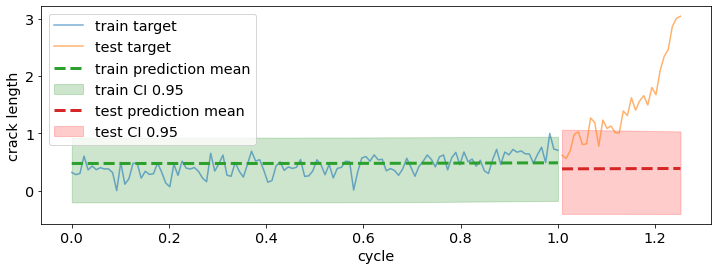

In [231]:
%%time

model_mmd = GaussianNetworkMMD([1, 4, 4, 1], weight_prior=td.Normal(0,1), bias_prior=td.Uniform(-10, 10), 
    likelihood_std=1, activation=nn.Tanh)

epochs = 1000
physics_coeff = 1

optim = torch.optim.Adam(model_mmd.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_gaussian_nn_mmd(model_mmd, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, divergence_coeff=1e-6)

train_predictions = sample_prediction(model_mmd, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model_mmd, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")

# test_mean, test_std = np.mean(test_predictions, 0), np.std(test_predictions, 0)
# uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())

## Sinkhorn distance

https://dfdazac.github.io/sinkhorn.html

https://simonensemble.github.io/pluto_nbs/emd.jl.html


In [208]:
# https://github.com/dfdazac/wassdistance/blob/master/layers.py
# Adapted from https://github.com/gpeyre/SinkhornAutoDiff
class SinkhornDistance(nn.Module):
    r"""
    Given two empirical measures each with :math:`P_1` locations
    :math:`x\in\mathbb{R}^{D_1}` and :math:`P_2` locations :math:`y\in\mathbb{R}^{D_2}`,
    outputs an approximation of the regularized OT cost for point clouds.
    Args:
        eps (float): regularization coefficient
        max_iter (int): maximum number of Sinkhorn iterations
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Default: 'none'
    Shape:
        - Input: :math:`(N, P_1, D_1)`, :math:`(N, P_2, D_2)`
        - Output: :math:`(N)` or :math:`()`, depending on `reduction`
    """
    def __init__(self, eps, max_iter, reduction='none'):
        super(SinkhornDistance, self).__init__()
        self.eps = eps
        self.max_iter = max_iter
        self.reduction = reduction

    def forward(self, x, y):
        # The Sinkhorn algorithm takes as input three variables :
        C = self._cost_matrix(x, y)  # Wasserstein cost function
        x_points = x.shape[-2]
        y_points = y.shape[-2]
        if x.dim() == 2:
            batch_size = 1
        else:
            batch_size = x.shape[0]

        # both marginals are fixed with equal weights
        # mu = torch.empty(batch_size, x_points, dtype=torch.float,
        #                  requires_grad=False).fill_(1.0 / x_points).squeeze()
        # nu = torch.empty(batch_size, y_points, dtype=torch.float,
        #                  requires_grad=False).fill_(1.0 / y_points).squeeze()
        mu = torch.empty(batch_size, x_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / x_points)
        nu = torch.empty(batch_size, y_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / y_points)

        u = torch.zeros_like(mu)
        v = torch.zeros_like(nu)
        # To check if algorithm terminates because of threshold
        # or max iterations reached
        actual_nits = 0
        # Stopping criterion
        thresh = 1e-1
        # print(f"{x.shape=}, {y.shape=}")
        # print(f"{C.shape=}, {u.shape=}, {v.shape=}")

        # Sinkhorn iterations
        for i in range(self.max_iter):
            u1 = u  # useful to check the update
            u = self.eps * (torch.log(mu+1e-8) - torch.logsumexp(self.M(C, u, v), dim=-1)) + u
            v = self.eps * (torch.log(nu+1e-8) - torch.logsumexp(self.M(C, u, v).transpose(-2, -1), dim=-1)) + v
            err = (u - u1).abs().sum(-1).mean()

            actual_nits += 1
            if err.item() < thresh:
                break

        U, V = u, v
        # Transport plan pi = diag(a)*K*diag(b)
        pi = torch.exp(self.M(C, U, V))
        # Sinkhorn distance
        cost = torch.sum(pi * C, dim=(-2, -1))

        if self.reduction == 'mean':
            cost = cost.mean()
        elif self.reduction == 'sum':
            cost = cost.sum()

        return cost, pi, C

    def M(self, C, u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / self.eps

    @staticmethod
    def _cost_matrix(x, y, p=2):
        "Returns the matrix of $|x_i-y_j|^p$."
        x_col = x.unsqueeze(-2)
        y_lin = y.unsqueeze(-3)
        C = torch.sum((torch.abs(x_col - y_lin)) ** p, -1)
        return C

    @staticmethod
    def ave(u, u1, tau):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

In [215]:
m = 10 # sample size
x_mean = torch.zeros(2)+1
y_mean = torch.zeros(2)
x_cov = 2*torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
y_cov = 3*torch.eye(2) - 1

px = torch.distributions.MultivariateNormal(x_mean, x_cov)
qy = torch.distributions.MultivariateNormal(y_mean, y_cov)
x = px.sample([m])
y = qy.sample([m])

print(x.shape, y.shape)
sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction="mean")
print(sinkhorn(x, y)[0])

torch.Size([10, 2]) torch.Size([10, 2])
tensor(2.5216)


In [222]:
m = 10 # sample size
x_mean = torch.zeros(2)
y_mean = torch.zeros(2)
x_cov = 2*torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
y_cov = 2*torch.eye(2)

px = torch.distributions.MultivariateNormal(x_mean, x_cov)
qy = torch.distributions.MultivariateNormal(y_mean, y_cov)
x = px.sample([m])
y = qy.sample([m])

print(x.shape, y.shape)
sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction="mean")
print(sinkhorn(x, y)[0])

torch.Size([10, 2]) torch.Size([10, 2])
tensor(1.9936)


In [251]:
class GaussianLinearSinkhorn(nn.Module):
    def __init__(self, inputsize, outputsize, weight_prior, bias_prior, sinkhorn):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.weight_prior = weight_prior
        self.bias_prior = bias_prior
        self.sinkhorn = sinkhorn
        
        self.weight_mean = nn.Parameter(weight_prior.sample((inputsize, outputsize)))
        self.weight_logstd = nn.Parameter(weight_prior.sample((inputsize, outputsize)))
        
        self.bias_mean = nn.Parameter(bias_prior.sample((1, outputsize)))
        self.bias_logstd = nn.Parameter(bias_prior.sample((1, outputsize)))

        self.normal01 = td.Normal(0,1)

    def forward(self, inputdata, need_sample=True):
        if not need_sample:
            output = torch.mm(inputdata, self.weight_mean) + self.bias_mean.expand(inputdata.size()[0], self.outputsize)
            return output
        
        epsilon_weight = self.normal01.sample(self.weight_mean.shape).to(device)
        epsilon_bias = self.normal01.sample(self.bias_mean.shape).to(device)        
        weight = self.weight_mean + torch.log(1 + torch.exp(self.weight_logstd)) * epsilon_weight
        bias = self.bias_mean + torch.log(1 + torch.exp(self.bias_logstd)) * epsilon_bias
        
        output = torch.mm(inputdata, weight) + bias.expand(inputdata.size()[0], self.outputsize)
        # print((1, weight.shape[1], 1))
        # print(weight.shape, bias.shape)
        # distance_weight = self.sinkhorn(weight, self.weight_prior.sample(weight.shape))[0]
        # distance_bias = self.sinkhorn(bias, self.bias_prior.sample(bias.shape))[0]
        reshaped_weight = weight.reshape(-1, 1)
        reshaped_bias = bias.reshape(-1, 1)
        distance_weight = self.sinkhorn(reshaped_weight, self.weight_prior.sample(reshaped_weight.shape))[0]
        distance_bias = self.sinkhorn(reshaped_bias, self.bias_prior.sample(reshaped_bias.shape))[0]
        return output, distance_weight + distance_bias

class GaussianNetworkSinkhorn(nn.Module):
    def __init__(self, layer_size, weight_prior, bias_prior, sinkhorn, likelihood_std=0.1, activation=nn.Tanh, need_output_exp=False):
        super().__init__()
        self.weight_prior = weight_prior
        self.bias_prior = bias_prior
        self.likelihood_std = torch.tensor(likelihood_std)
        self.need_output_exp = need_output_exp
        self.sinkhorn = sinkhorn
        
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(GaussianLinearSinkhorn(layer_size[i], layer_size[i+1], weight_prior, bias_prior, sinkhorn))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            GaussianLinearSinkhorn(layer_size[-2], layer_size[-1], weight_prior, bias_prior, sinkhorn)
        )
        self.distance = 0
    
    def forward(self, indata, need_sample=True):        
        outdata = indata
        self.distance = 0
        for layer in self.layers:
            if isinstance(layer, GaussianLinearSinkhorn):
                outdata, distance = layer(outdata, need_sample)
                self.distance += distance
            else:
                outdata = layer(outdata)
        
        if self.need_output_exp: outdata = torch.exp(outdata)
        
        return outdata, self.distance

    def forward_sample(inputdata, targetdata, sample_size=10):
        predictions = []
        for samplecount in range(sample_size):
            prediction, distance = self.forward(inputdata)
            predictions.append(prediction)
            
        return torch.stack(predictions, dim=0)

model_sinkhorn = GaussianNetworkSinkhorn([1, 4, 4, 1], weight_prior=td.Normal(0,1), bias_prior=td.Uniform(-10, 10), 
    sinkhorn=SinkhornDistance(eps=0.1, max_iter=100, reduction="mean"), likelihood_std=1, activation=nn.Tanh)
model_sinkhorn(torch.randn(2, 1))

(tensor([[5.1921],
         [5.1921]], grad_fn=<AddBackward0>),
 tensor(48.8538, grad_fn=<AddBackward0>))

In [252]:
def compute_data_physics_loss_gaussian_nn_sinkhorn(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler, physics_coeff, sample_size=10):
    
    data_distance, physics_distance, data_samples_loglikelihood, physics_samples_loglikelihood = 0., 0., 0., 0.
    inputphysics.requires_grad_(True)
    
    for samplecount in range(sample_size):
        # same sample for data and physics ?
        data_output = model.forward(inputdata)
        physics_output = model.forward(inputphysics)
        physics_constraint = 1 * paris_law(outputscaler.inverse(physics_output[0]), paris_C, paris_m, paris_dsigma)    
        # print(f"{data_prediction = } \n {physics_prediction = } \n {physics_constraint = }")
        
        data_distance += data_output[1]
        physics_distance += physics_output[1]

        derivative = torch.autograd.grad(outputs=physics_output[0], inputs=inputphysics, 
            grad_outputs=torch.ones_like(inputphysics), retain_graph=True, create_graph=True)[0]
        rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)
        
        differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(targetdata**2)
        #         print(f"{data_norm = } {differential_norm = }")
        
        # print(f"{log_gaussian(targetdata, data_prediction, model.likelihood_std) = }")
        # data_samples_loglikelihood += log_gaussian(data_prediction, targetdata, model.likelihood_std).mean()
        # physics_samples_loglikelihood += log_gaussian(rescaled_derivative, physics_constraint, model.likelihood_std).mean()
        
        data_samples_loglikelihood += log_gaussian(data_output[0]/torch.sqrt(data_norm), targetdata/torch.sqrt(data_norm), model.likelihood_std).mean()
        physics_samples_loglikelihood += log_gaussian(rescaled_derivative/torch.sqrt(differential_norm), physics_constraint/torch.sqrt(differential_norm), model.likelihood_std).mean()
#         print(f"{data_samples_loglikelihood = } {physics_samples_loglikelihood = }")
        
        # data_samples_loglikelihood += mse_to_log_gaussian(tnf.mse_loss(data_prediction, targetdata)/data_norm, model.likelihood_std)
        # physics_samples_loglikelihood += mse_to_log_gaussian(tnf.mse_loss(physics_prediction, physics_constraint)/differential_norm, model.likelihood_std)
        
    return data_distance/sample_size, physics_distance/sample_size, data_samples_loglikelihood/sample_size, physics_samples_loglikelihood/sample_size

In [255]:
def train_model_physics_magnitude_norm_gaussian_nn_sinkhorn(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True, sample_size=10, divergence_coeff=1):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = {key: np.empty(epochs) for key in "data_loglikelihood physics_loglikelihood data_distance physics_distance".split()}
    model.train()
    
    for epoch in range(epochs):
        loss = torch.zeros(1)
        
        data_distance, physics_distance, data_loglikelihood, physics_loglikelihood = compute_data_physics_loss_gaussian_nn_sinkhorn(
            paris_C, paris_m, paris_dsigma, model, traininput, trainlabel, physicsinput, 
            xscaler, yscaler, physics_coeff=physics_coeff, sample_size=sample_size)

        loss = divergence_coeff * (data_distance + physics_distance) - (data_loglikelihood + physics_loglikelihood)

        optim.zero_grad()
        loss.backward()
        optim.step()        
#         scheduler.step(loss)

        metric["data_loglikelihood"][epoch] = data_loglikelihood.item()
        metric["physics_loglikelihood"][epoch] = physics_loglikelihood.item()
        metric["data_distance"][epoch] = data_distance.item()
        metric["physics_distance"][epoch] = physics_distance.item()

        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f" scaled distance = {divergence_coeff * (data_distance + physics_distance)} ; {divergence_coeff * data_distance = } ; {divergence_coeff * physics_distance = }")
            print(f"log likelihood = {data_loglikelihood + physics_loglikelihood} ; {data_loglikelihood = } {physics_loglikelihood = }")
    
    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)
    
    return metric


 Epoch 1 loss = 7.507185935974121
 scaled distance = 0.419712096452713 ; divergence_coeff * data_distance = tensor(0.3281, grad_fn=<MulBackward0>) ; divergence_coeff * physics_distance = tensor(0.0916, grad_fn=<MulBackward0>)
log likelihood = -7.0874738693237305 ; data_loglikelihood = tensor(-6.1635, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9239, grad_fn=<DivBackward0>)

 Epoch 101 loss = 3.922855854034424
 scaled distance = 0.27987000346183777 ; divergence_coeff * data_distance = tensor(0.1867, grad_fn=<MulBackward0>) ; divergence_coeff * physics_distance = tensor(0.0932, grad_fn=<MulBackward0>)
log likelihood = -3.6429858207702637 ; data_loglikelihood = tensor(-2.7191, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9239, grad_fn=<DivBackward0>)

 Epoch 201 loss = 2.5506439208984375
 scaled distance = 0.23733410239219666 ; divergence_coeff * data_distance = tensor(0.0870, grad_fn=<MulBackward0>) ; divergence_coeff * physics_distance = tensor(0.1503, grad_f

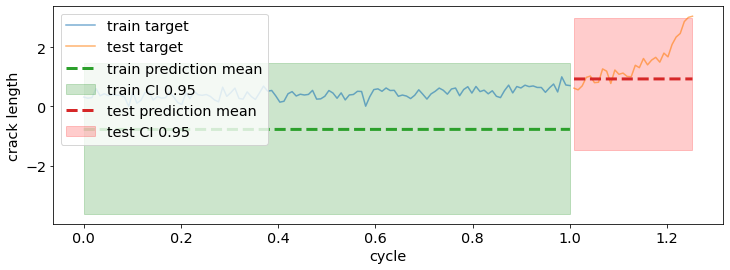

In [258]:
%%time

model_sinkhorn = GaussianNetworkSinkhorn([1, 4, 4, 1], weight_prior=td.Normal(0,1), bias_prior=td.Uniform(-10, 10), 
    sinkhorn=SinkhornDistance(eps=0.1, max_iter=10, reduction="mean"), likelihood_std=1, activation=nn.Tanh)

epochs = 1000
physics_coeff = 1

optim = torch.optim.Adam(model_sinkhorn.parameters(), lr=1e-2, weight_decay=1e-6)
metric_sinkhorn = train_model_physics_magnitude_norm_gaussian_nn_sinkhorn(model_sinkhorn, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, divergence_coeff=1e-3)

train_predictions = sample_prediction(model_sinkhorn, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model_sinkhorn, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")

# test_mean, test_std = np.mean(test_predictions, 0), np.std(test_predictions, 0)
# uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())

## Deep ensemble basic

In [598]:
def plot_target_prediction_ensemble(traininput, traintarget, testinput, testtarget, ensemble,
    title=None, figsize=(12, 4), marker=None):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(traininput, traintarget, label="train target", marker=marker, linestyle="-")
    plt.plot(testinput, testtarget, label="test target", marker=marker, linestyle="-")
    
    for index, model in enumerate(ensemble):
        trainprediction, _ = predict_model(model, traininput, traintarget)
        testprediction, testloss = predict_model(model, testinput, testtarget)
        # print(trainprediction.shape, testprediction.shape)
         # label=f"train prediction {index}"
        plt.plot(traininput, trainprediction, marker=marker, alpha=0.6, linestyle="--", linewidth=3)
        plt.plot(testinput, testprediction, marker=marker, alpha=0.6, linestyle="--", linewidth=3)
    # plt.ylim(-0.01, 0.02)
        
    if title: plt.title(title)    
    
    plt.legend()
    plt.xlabel("cycle")
    plt.ylabel("crack length")

    return fig

In [384]:
# train_xtensor, train_ytensor, test_xtensor, test_ytensor, fig = generate_data_tensor()

CPU times: user 45.1 s, sys: 3.71 ms, total: 45.1 s
Wall time: 45.1 s


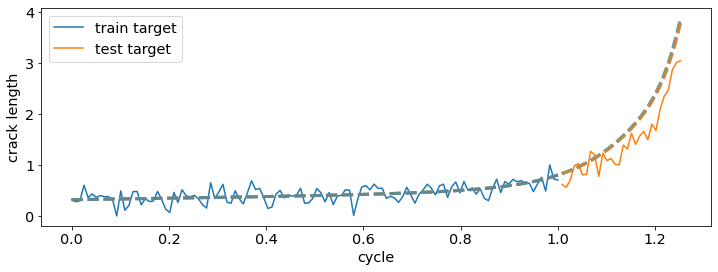

In [599]:
%%time

ensemble_size = 5
ensemble_model = []
ensemble_metric = []

for member_id in range(ensemble_size):
    # print(f"\n{member_id = }")
    model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
    figs=[]
    epochs = 10000
    physics_coeff = 1

    optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    metric = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
        train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
        optim=optim, verbose=False)
    
    ensemble_model.append(model)
    ensemble_metric.append(metric)
    
fig = plot_target_prediction_ensemble(train_xtensor, train_ytensor, 
    test_xtensor, test_ytensor, ensemble_model)


## Deep Ensemble Gaussian Mixture

https://arxiv.org/pdf/1612.01474.pdf

https://github.com/mpritzkoleit/deep-ensembles/blob/master/Deep%20Ensembles.ipynb

Each model in the ensemble receives the input, then produces a predictive mean $\mu(x)$ and variance $\sigma^2(x)$

\begin{align}
-ln\ p(y|x) = -ln\ \mathcal N (y; \mu(x), \sigma^2(x)) = \frac 1 2 ln\ 2 \pi + ln\ \sigma(x) + \frac {(y-\mu(x))^2} {2 \sigma^2(x)}
\end{align}

The prediction of the ensemble is a Gaussian mixture with uniform contribution

\begin{align}
\mu(x) = \frac 1 M \sum_{i=1}^M \mu_i(x) \\
\sigma^2(x) = \frac 1 M \sum_{i=1}^M [\sigma^2_i(x) + \mu_i^2(x)] - \mu^2(x)
\end{align}

In [198]:
class GaussianFullyConnected0(nn.Module):
    "Defines a fully connected neural network  with output mean and variance of a Gaussian"
    def __init__(self, layer_size, activation=nn.ReLU, need_mean_exp=False):
        super().__init__()
        self.need_mean_exp = need_mean_exp
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-2], layer_size[-1])
        )
        
    def forward(self, inpt):
        outpt = inpt
        for layer in self.layers:
            outpt = layer(outpt)
        # print(f"{outpt.shape=}")
        mean, logvar = torch.chunk(outpt, 2, dim=-1)
        var = tnf.softplus(logvar) + 1e-6
        # var = torch.exp(logvar)
        
        if self.need_mean_exp: mean =  torch.exp(mean)
        
        return mean, var


In [199]:
def create_mlp(layersize, activation):
    layers = []
    for i in range(len(layersize) - 2):
        layers.append(nn.Linear(layersize[i], layersize[i+1]))
        layers.append(activation())            

    mlp = nn.Sequential(
        *layers,
        nn.Linear(layersize[-2], layersize[-1]))
    
    return mlp

class GaussianFullyConnected(nn.Module):
    "Defines a fully connected neural network  with output mean and variance of a Gaussian"
    def __init__(self, body_size, mean_head_size, logvar_head_size, activation=nn.ReLU, need_mean_exp=False):
        super().__init__()
        self.need_mean_exp = need_mean_exp
        self.body = create_mlp(body_size, activation)
        self.mean_head = create_mlp(mean_head_size, activation)
        self.logvar_head = create_mlp(logvar_head_size, activation)
        
    def forward(self, indata):
        outdata = self.body(indata)
        mean, logvar = self.mean_head(outdata), self.logvar_head(outdata)
        
        # var = tnf.softplus(logvar) + 1e-6
        # var = torch.exp(logvar)
        
        if self.need_mean_exp: mean =  torch.exp(mean)
        
        return mean, logvar

model = GaussianFullyConnected(body_size=[1, 4, 4], mean_head_size=[4, 1], logvar_head_size=[4, 1])
mean, logvar = model(torch.rand(4, 1))
mean.shape, logvar.shape

(torch.Size([4, 1]), torch.Size([4, 1]))

In [200]:
# https://github.com/mpritzkoleit/deep-ensembles/blob/master/Deep%20Ensembles.ipynb
def gaussian_mixture_ensemble_forward(ensemble_models, inputtensor):
    means = []; logvariances = []
    for index, model in enumerate(ensemble_models):
        mean, logvariance = model(inputtensor)
        means.append(mean)
        logvariances.append(logvariance)
    
    means = torch.stack(means)
    logvariances = torch.stack(logvariances)
    mixture_mean = means.mean(0)
    mixture_var = (torch.exp(logvariances) + means**2).mean(0) - mixture_mean**2
    
    return mixture_mean, mixture_var
        
def negative_gaussian_loglikelihood(mean, logvariance, target, mse_coeff=1):
    return torch.mean(logvariance/2 + mse_coeff * (target - mean)**2 / torch.exp(logvariance))

In [371]:
def compute_data_physics_loss_gaussian_mixture_ensemble(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler):
    
    inputphysics.requires_grad_(True)    
    data_mean, data_logvar = model(inputdata)
    physics_mean, physics_logvar = model(inputphysics)
    physics_constraint = 1 * paris_law(outputscaler.inverse(physics_mean), paris_C, paris_m, paris_dsigma)    
    
    derivative = torch.autograd.grad(outputs=physics_mean, inputs=inputphysics, 
        grad_outputs=torch.ones_like(inputphysics), retain_graph=True, create_graph=True)[0]
    rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)
        
    differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
    differential_norm = torch.sum(differential_norm**2)
    data_norm = torch.sum(targetdata**2)

    data_loss = negative_gaussian_loglikelihood(data_mean, data_logvar, targetdata, 1/data_norm)
    physics_loss = negative_gaussian_loglikelihood(rescaled_derivative, physics_logvar, physics_constraint, 1/differential_norm)

    # data_loss = negative_gaussian_loglikelihood(data_mean, data_logvar, targetdata)
    # physics_loss = negative_gaussian_loglikelihood(rescaled_derivative, physics_logvar, physics_constraint)

    # data_loss = negative_gaussian_loglikelihood(data_mean / torch.sqrt(data_norm), data_logvar, targetdata / torch.sqrt(data_norm))
    # physics_loss = negative_gaussian_loglikelihood(rescaled_derivative / torch.sqrt(differential_norm), physics_logvar, physics_constraint / torch.sqrt(differential_norm))

    return data_loss, data_norm, physics_loss, differential_norm

In [372]:
def train_model_physics_magnitude_norm_ensemble(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True, sample_size=10, kldiv_coeff=1):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)
    metric = {key: np.empty(epochs) for key in "data_loss physics_loss data_norm differential_norm".split()}
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()

        data_loss, data_norm, physics_loss, differential_norm = compute_data_physics_loss_gaussian_mixture_ensemble(paris_C, paris_m, paris_dsigma, 
               model, traininput, trainlabel, physicsinput, xscaler, yscaler)

        metric["data_loss"][epoch] = data_loss
        metric["physics_loss"][epoch] = physics_loss
        metric["data_norm"][epoch] = data_norm
        metric["differential_norm"][epoch] = differential_norm
        
        # loss = data_loss * torch.abs(torch.log(data_norm)) + physics_loss * torch.abs(torch.log(differential_norm))
        loss = data_loss + physics_loss
        # loss = data_loss - torch.log(data_norm) + physics_loss - torch.log(differential_norm)
        loss.backward()
        optim.step()        
#         scheduler.step(loss)

        if verbose and (epochs < 10 or epoch % (epochs//5) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f"{data_loss = } {physics_loss = } \n {data_norm = } {differential_norm = }")
            print(f"{torch.log(data_norm) = } {torch.log(differential_norm) = }")
    
    # for metricname, metricvalue in metric.items():
    #     metric[metricname] = np.array(metricvalue)
    
    return metric

In [584]:
%%time

ensemble_size = 5
ensemble_model = []
ensemble_metric = []

for member_id in range(ensemble_size):
    # print(f"\n{member_id = }")
    model = GaussianFullyConnected(body_size=[1, 4, 4], mean_head_size=[4, 1], logvar_head_size=[4, 1],
        activation=nn.Tanh, need_mean_exp=False).to(device)
    # figs=[]
    epochs = 10000
    physics_coeff = 1

    optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    metric = train_model_physics_magnitude_norm_ensemble(model, train_xtensor, train_ytensor, physics_xtensor, 
        train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, optim=optim, verbose=False)
    
    ensemble_model.append(model)
    ensemble_metric.append(metric)
    
# fig = plot_target_prediction_ensemble(train_xtensor, train_ytensor, 
#     test_xtensor, test_ytensor, ensemble_model)


CPU times: user 53.8 s, sys: 0 ns, total: 53.8 s
Wall time: 53.8 s


In [585]:
def predict_gaussian_ensemble_model(model, inputtensor):
    with torch.no_grad():
        mean, logvar = model(inputtensor)
    return mean.detach().cpu().numpy(), logvar.exp().detach().cpu().numpy()

def plot_target_prediction_ensemble_gaussian(traininput, traintarget, testinput, testtarget, ensemble,
    title=None, figsize=(12, 4), marker=None):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(traininput, traintarget, label="train target", marker=marker, linestyle="-")
    plt.plot(testinput, testtarget, label="test target", marker=marker, linestyle="-")
    
    for index, model in enumerate(ensemble):
        train_mean, train_var = predict_gaussian_ensemble_model(model, traininput)
        test_mean, test_var = predict_gaussian_ensemble_model(model, testinput)

        plt.plot(traininput, train_mean, marker=marker, alpha=0.6, linestyle="--", linewidth=3)
        plt.plot(testinput, test_mean, marker=marker, alpha=0.6, linestyle="--", linewidth=3)
        plt.fill_between(traininput.squeeze(), (train_mean - 2 * np.sqrt(train_var)).squeeze(), (train_mean + 2 * np.sqrt(train_var)).squeeze(),
            color="gray", alpha=0.2)
        plt.fill_between(testinput.squeeze(), (test_mean - 2 * np.sqrt(test_var)).squeeze(), (test_mean + 2 * np.sqrt(test_var)).squeeze(),
            color="gray", alpha=0.2)
        
    if title: plt.title(title)    
    plt.legend()
    plt.xlabel("cycle")
    plt.ylabel("crack length")

    return fig

def plot_target_prediction_ensemble_gaussian_mixture(traininput, traintarget, testinput, testtarget, ensemble,
    title=None, figsize=(12, 4), marker=None):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(traininput, traintarget, label="train target", marker=marker, linestyle="-")
    plt.plot(testinput, testtarget, label="test target", marker=marker, linestyle="-")
    
    train_mean, train_var = gaussian_mixture_ensemble_forward(ensemble, traininput)
    test_mean, test_var = gaussian_mixture_ensemble_forward(ensemble, testinput)
    train_mean, train_var = train_mean.detach().numpy(), train_var.detach().numpy()
    test_mean, test_var = test_mean.detach().numpy(), test_var.detach().numpy()

    plt.plot(traininput, train_mean, marker=marker, alpha=0.6, linestyle="--", linewidth=3)
    plt.plot(testinput, test_mean, marker=marker, alpha=0.6, linestyle="--", linewidth=3)
    plt.fill_between(traininput.squeeze(), (train_mean - 2 * np.sqrt(train_var)).squeeze(), (train_mean + 2 * np.sqrt(train_var)).squeeze(),
        color="gray", alpha=0.4)
    plt.fill_between(testinput.squeeze(), (test_mean - 2 * np.sqrt(test_var)).squeeze(), (test_mean + 2 * np.sqrt(test_var)).squeeze(),
        color="gray", alpha=0.4)
        
    if title: plt.title(title)    
    plt.legend()
    plt.xlabel("cycle")
    plt.ylabel("crack length")

    return fig

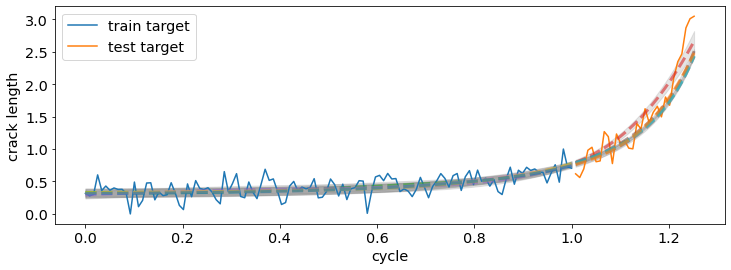

In [586]:
fig = plot_target_prediction_ensemble_gaussian(train_xtensor, train_ytensor, test_xtensor, test_ytensor, ensemble_model)

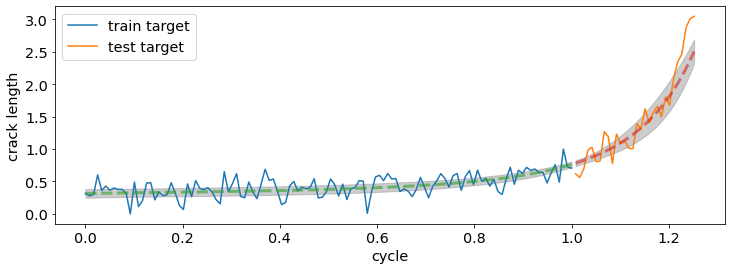

In [587]:
fig = plot_target_prediction_ensemble_gaussian_mixture(train_xtensor, train_ytensor, test_xtensor, test_ytensor, ensemble_model)

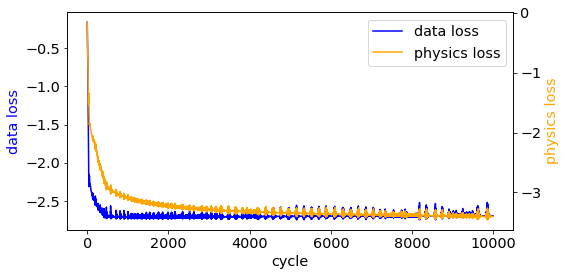

In [589]:
fig = plot_twinx(np.arange(epochs), ensemble_metric[0]["data_loss"], "data loss", ensemble_metric[0]["physics_loss"], "physics loss")

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 12.36it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 12.47it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.202
  RMSE          0.262
  MDAE          0.156
  MARPD         14.255
  R2            0.853
  Correlation   0.964
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.538
  Mean-absolute Calibration Error       0.468
  Miscalibration Area                   0.472
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.490
     Group Size: 0.56 -- Calibration Error: 0.484
     Group Size: 1.00 -- Calibration Error: 0.468
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.570
     Group Size: 0.56 -- Calibration Error: 0.567
     Group Size: 1.00 -- Calibration Error: 0.538
===============

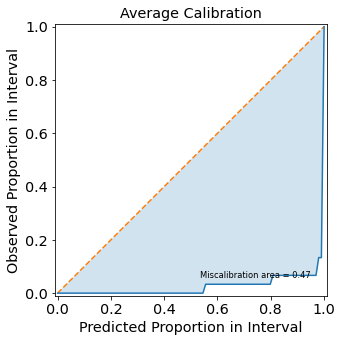

In [588]:
test_mean, test_var = predict_gaussian_ensemble_model(model, test_xtensor)
test_mean, test_std = test_mean.squeeze(), np.sqrt(test_var.squeeze())
uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())
metrics = uct.metrics.get_all_metrics(test_mean, test_std, test_ytensor.numpy().squeeze())

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  9.58it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  9.44it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.088
  RMSE          0.110
  MDAE          0.075
  MARPD         23.316
  R2            0.401
  Correlation   0.647
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.517
  Mean-absolute Calibration Error       0.445
  Miscalibration Area                   0.449
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.465
     Group Size: 0.56 -- Calibration Error: 0.453
     Group Size: 1.00 -- Calibration Error: 0.445
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.538
     Group Size: 0.56 -- Calibration Error: 0.524
     Group Size: 1.00 -- Calibration Error: 0.517
===============

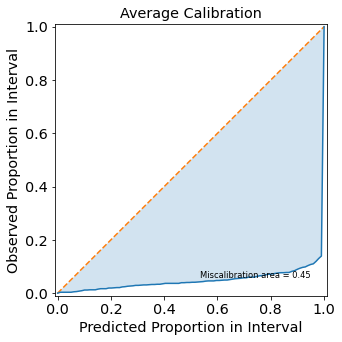

In [558]:
train_mean, train_var = predict_gaussian_ensemble_model(model, train_xtensor)
train_mean, train_std = train_mean.squeeze(), np.sqrt(train_var.squeeze())
uct.viz.plot_calibration(train_mean, train_std, train_ytensor.numpy().squeeze())
metrics = uct.metrics.get_all_metrics(train_mean, train_std, train_ytensor.numpy().squeeze())

In [390]:
%%time

ensemble_size = 10
ensemble_model = []
ensemble_metric = []

for member_id in range(ensemble_size):
    # print(f"\n{member_id = }")
    model = GaussianFullyConnected(body_size=[1, 4, 4], mean_head_size=[4, 1], logvar_head_size=[4, 1],
        activation=nn.Tanh, need_mean_exp=False).to(device)
    # figs=[]
    epochs = 10000
    physics_coeff = 1

    optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    metric = train_model_physics_magnitude_norm_ensemble(model, train_xtensor, train_ytensor, physics_xtensor, 
        train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, optim=optim, verbose=False)
    
    ensemble_model.append(model)
    ensemble_metric.append(metric)
    
# fig = plot_target_prediction_ensemble(train_xtensor, train_ytensor, 
#     test_xtensor, test_ytensor, ensemble_model)


CPU times: user 1min 47s, sys: 3.68 ms, total: 1min 47s
Wall time: 1min 47s


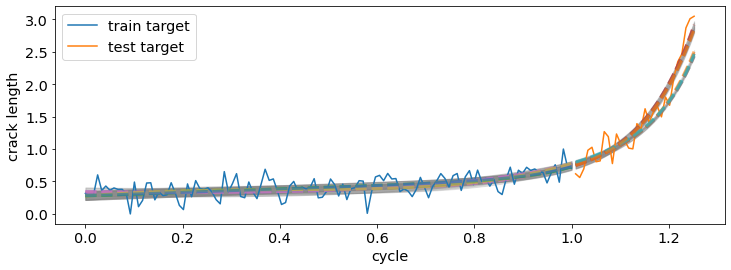

In [391]:
fig = plot_target_prediction_ensemble_gaussian(train_xtensor, train_ytensor, test_xtensor, test_ytensor, ensemble_model)

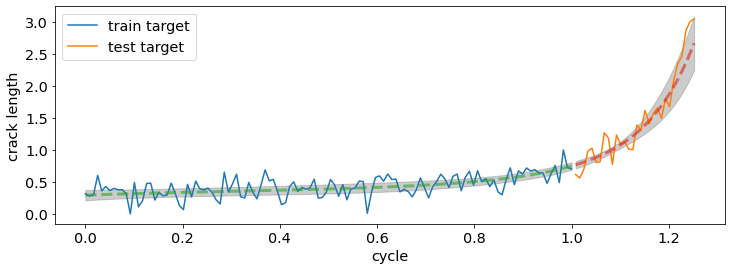

In [392]:
fig = plot_target_prediction_ensemble_gaussian_mixture(train_xtensor, train_ytensor, test_xtensor, test_ytensor, ensemble_model)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 12.46it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 12.27it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.155
  RMSE          0.185
  MDAE          0.148
  MARPD         12.200
  R2            0.927
  Correlation   0.965
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.478
  Mean-absolute Calibration Error       0.414
  Miscalibration Area                   0.418
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.490
     Group Size: 0.56 -- Calibration Error: 0.464
     Group Size: 1.00 -- Calibration Error: 0.414
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.570
     Group Size: 0.56 -- Calibration Error: 0.541
     Group Size: 1.00 -- Calibration Error: 0.478
===============

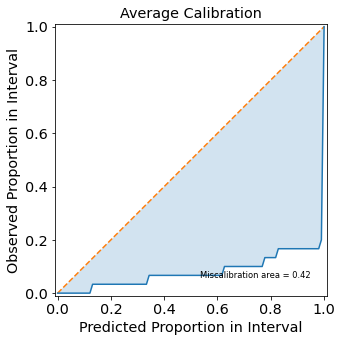

In [393]:
test_mean, test_var = predict_gaussian_ensemble_model(model, test_xtensor)
test_mean, test_std = test_mean.squeeze(), np.sqrt(test_var.squeeze())
uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())
metrics = uct.metrics.get_all_metrics(test_mean, test_std, test_ytensor.numpy().squeeze())

## Evididential Regression

\begin{align}
y_1, ..., y_n \sim \mathcal N (\mu, \sigma^2) \\
\mu \sim \mathcal N (\gamma, \sigma^2 / v) \\
\sigma^2 \sim \Gamma^{-1} (\alpha, \beta) \\
p(\mu, \sigma^2) \approx p(\mu | \gamma, v) p(\sigma^2 | \alpha, \beta) \\
\theta = (\mu, \sigma^2) ; m = (\gamma, v, \alpha, \beta) 
\\
p(y_i | m ) = \frac {p(y_i | \theta, m) p(\theta | m)} {p(\theta | y_i, m)} = \int_\mu \int_{\sigma^2} p(y_i | \mu, \sigma^2) p(\mu, \sigma^2 | m)\ d\mu\ d\sigma^2 \\
p(y_i | m ) = \text{Student-t}(y_i; \gamma, \frac {\beta (1+v)}{v \alpha}, 2\alpha) 
\\
L^{NLL}_i = ln\ p(y_i | m) = \log (\text{Student-t}(y_i; \gamma, \frac {\beta (1+v)}{v \alpha}, 2\alpha)) \\
L^{R}_i = \underbrace{|y_i - E[\mu_i]|}_{\text{prediction error}} \overbrace{(2v + \alpha)}^{\text{evidence or confidence}} \\
L_i = L^{NLL}_i + \lambda L^R_i
\end{align}

https://www.mit.edu/~amini/pubs/pdf/deep-evidential-regression.pdf

https://github.com/deebuls/deep_evidential_regression_loss_pytorch


In [264]:
class FullyConnectedEvidential(nn.Module):
    "Defines a fully connected neural network"
    def __init__(self, layer_size, activation=nn.Tanh):
        super().__init__()
        layers = []
        
        for i in range(len(layer_size)-1):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(activation())            
        
        self.body = nn.Sequential(
            *layers,
        )
        self.head1 = nn.Linear(layer_size[-1], 1)
        self.head3 = nn.Linear(layer_size[-1], 3)
        
    def forward(self, indata):
        # for layer in self.layers:
        body_outdata = self.body(indata)
        head1_outdata = self.head1(body_outdata)
        head3_outdata = torch.exp(self.head3(body_outdata))
        
        return torch.hstack((head1_outdata, head3_outdata))

model_evidential = FullyConnectedEvidential([1, 4, 4], activation=nn.Tanh).to(device)
model_evidential(torch.randn(2, 1))

tensor([[-0.5126,  0.8419,  1.6238,  0.4933],
        [-0.5092,  0.9599,  1.7661,  0.5224]], grad_fn=<CatBackward0>)

In [316]:
class EvidentialLossSumOfSquares(nn.Module):
  """The evidential loss function on a matrix.
  This class is implemented with slight modifications from the paper. The major
  change is in the regularizer parameter mentioned in the paper. The regularizer
  mentioned in the paper didnot give the required results, so we modified it 
  with the KL divergence regularizer from the paper. In orderto overcome the problem
  that KL divergence are missing near zero so we add the minimum values to alpha,
  beta and lambda and compare distance with NIG(alpha=1.0, beta=0.1, lambda=1.0)
  This class only allows for rank-4 inputs for the output `targets`, and expectes
  `inputs` be of the form [mu, alpha, beta, lambda] 
  alpha, beta and lambda needs to be positive values.
  """

  def __init__(self, regularize_coeff=1e-3, debug=False, return_all=False):
    """Sets up loss function.
    Args:
      debug: When set to 'true' prints all the intermittent values
      return_all: When set to 'true' returns all loss values without taking average
    """
    super(EvidentialLossSumOfSquares, self).__init__()

    self.debug = debug
    self.return_all_values = return_all
    self.MAX_CLAMP_VALUE = 5.0   # Max you can go is 85 because exp(86) is nan  Now exp(5.0) is 143 which is max of a,b and l
    self.regularize_coeff = regularize_coeff
    
  def kl_divergence_nig(self, mu1, mu2, alpha_1, beta_1, lambda_1):
    alpha_2 = torch.ones_like(mu1)*1.0
    beta_2 = torch.ones_like(mu1)*0.1
    lambda_2 = torch.ones_like(mu1)*1.0

    t1 = 0.5 * (alpha_1/beta_1) * ((mu1 - mu2)**2)  * lambda_2
    #t1 = 0.5 * (alpha_1/beta_1) * (torch.abs(mu1 - mu2))  * lambda_2
    t2 = 0.5*lambda_2/lambda_1
    t3 = alpha_2*torch.log(beta_1/beta_2)
    t4 = -torch.lgamma(alpha_1) + torch.lgamma(alpha_2)
    t5 = (alpha_1-alpha_2)*torch.digamma(alpha_1)
    t6 = -(beta_1 - beta_2)*(alpha_1/beta_1)
    return (t1+t2-0.5+t3+t4+t5+t6)

  def forward(self, inputs, targets):
    """ Implements the loss function 
    Args:
      inputs: The output of the neural network. inputs has 4 dimension 
        in the format [mu, alpha, beta, lambda]. Must be a tensor of
        floats
      targets: The expected output
    Returns:
      Based on the `return_all` it will return mean loss of batch or individual loss
    """
    assert torch.is_tensor(inputs)
    assert torch.is_tensor(targets)
    assert (inputs[:,1] > 0).all()
    assert (inputs[:,2] > 0).all()
    assert (inputs[:,3] > 0).all()

    # targets = targets.view(-1)
    # y = inputs[:,0].view(-1) #first column is mu,delta, predicted value
    # a = inputs[:,1].view(-1) + 1.0 #alpha
    # b = inputs[:,2].view(-1) + 0.1 #beta to avoid zero
    # l = inputs[:,3].view(-1) + 1.0 #lamda

    y = inputs[:,0] #first column is mu,delta, predicted value
    a = inputs[:,1] + 1.0 #alpha
    b = inputs[:,2] + 0.1 #beta to avoid zero
    l = inputs[:,3] + 1.0 #lamda
    
    if self.debug:
      print("a :", a)
      print("b :", b)
      print("l :", l)

    J1 = torch.lgamma(a - 0.5) 
    J2 = -torch.log(torch.tensor([4.0])) 
    J3 = -torch.lgamma(a) 
    J4 = -torch.log(l) 
    J5 = -0.5*torch.log(b) 
    J6 = torch.log(2*b*(1 + l) + (2*a - 1)*l*(y-targets)**2)
      
    if self.debug:
      print("lgama(a - 0.5) :", J1)
      print("log(4):", J2)
      print("lgama(a) :", J3)
      print("log(l) :", J4)
      print("log( ---- ) :", J6)

    J = J1 + J2 + J3 + J4 + J5 + J6
    #Kl_divergence = torch.abs(y - targets) * (2*a + l)/b ######## ?????
    #Kl_divergence = ((y - targets)**2) * (2*a + l)
    #Kl_divergence = torch.abs(y - targets) * (2*a + l)
    #Kl_divergence = 0.0
    #Kl_divergence = (torch.abs(y - targets) * (a-1) *  l)/b
    Kl_divergence = self.kl_divergence_nig(y, targets, a, b, l)
    
    if self.debug:
      print ("KL ",Kl_divergence.data.numpy())
    loss = torch.exp(J) + self.regularize_coeff * Kl_divergence

    if self.debug:
      print ("loss :", loss.mean())
    

    if self.return_all_values:
      ret_loss = loss
    else:
      ret_loss = loss.mean()
    #if torch.isnan(ret_loss):
    #  ret_loss.item() = self.prev_loss + 10
    #else:
    #  self.prev_loss = ret_loss.item()

    return ret_loss

In [337]:
class PaperEvidentialLossSumOfSquares(nn.Module):
  """The evidential loss function on a matrix.
  This class is implemented same as the paper. 
  This class only allows for rank-4 inputs for the output `targets`, and expectes
  `inputs` be of the form [mu, alpha, beta, lambda] 
  alpha, beta and lambda needs to be positive values.
  """

  def __init__(self, regularize_coeff=1e-3, debug=False, return_all=False):
    """Sets up loss function.
    Args:
      debug: When set to 'true' prints all the intermittent values
      return_all: When set to 'true' returns all loss values without taking average
    """
    super(PaperEvidentialLossSumOfSquares, self).__init__()

    self.debug = debug
    self.return_all_values = return_all
    self.MAX_CLAMP_VALUE = 5.0   # Max you can go is 85 because exp(86) is nan  Now exp(5.0) is 143 which is max of a,b and l
    self.regularize_coeff = regularize_coeff

  def forward(self, inputs, targets):
    """ Implements the loss function 
    Args:
      inputs: The output of the neural network. inputs has 4 dimension 
        in the format [mu, alpha, beta, lambda]. Must be a tensor of
        floats
      targets: The expected output
    Returns:
      Based on the `return_all` it will return mean loss of batch or individual loss
    """
    assert torch.is_tensor(inputs)
    assert torch.is_tensor(targets)
    assert (inputs[:,1] > 0).all()
    assert (inputs[:,2] > 0).all()
    assert (inputs[:,3] > 0).all()

    targets = targets.view(-1)
    y = inputs[:,0].view(-1) #first column is mu,delta, predicted value
    a = inputs[:,1].view(-1) #alpha
    b = inputs[:,2].view(-1) #beta to avoid zero
    l = inputs[:,3].view(-1) #lamda
    
    if self.debug:
      print("a :", a)
      print("b :", b)
      print("l :", l)

    #machine epsilon for safe cases
    machine_epsilon = torch.tensor(np.finfo(np.float32).eps)
    safe_a = torch.max(machine_epsilon, a) 
    safe_b = torch.max(machine_epsilon, b) 
    safe_l = torch.max(machine_epsilon, l) 
    J1 = torch.lgamma(torch.max(a - 0.5)) 
    J2 = -torch.log(torch.tensor([4.0])) 
    J3 = -torch.lgamma(safe_a) 
    J4 = -torch.log(safe_l) 
    J5 = -0.5*torch.log(safe_b) 
    J6 = torch.log(torch.max(machine_epsilon, 2*b*(1 + l) + (2*a - 1)*l*(y-targets)**2))
      
    if self.debug:
      print("lgama(a - 0.5) :", J1)
      print("log(4):", J2)
      print("lgama(a) :", J3)
      print("log(l) :", J4)
      print("log( ---- ) :", J6)

    J = J1 + J2 + J3 + J4 + J5 + J6
    Kl_divergence = torch.abs(y - targets) * (2*safe_a + safe_l) ######## ?????
    #Kl_divergence = ((y - targets)**2) * (2*safe_a + safe_l)
    #Kl_divergence = torch.abs(y - targets) * (2*a + l)
    #Kl_divergence = 0.0
    #Kl_divergence = (torch.abs(y - targets) * (a-1) *  l)/b
    # Kl_divergence = torch.norm(y - targets)*(2*safe_a + safe_l)
    
    if self.debug:
      print ("KL ",Kl_divergence.data.numpy())
    loss = torch.exp(J) + self.regularize_coeff * Kl_divergence

    if self.debug:
      print ("loss :", loss.mean())
    

    if self.return_all_values:
      ret_loss = loss
    else:
      ret_loss = loss.mean()
    #if torch.isnan(ret_loss):
    #  ret_loss.item() = self.prev_loss + 10
    #else:
    #  self.prev_loss = ret_loss.item()

    return ret_loss

In [338]:
def compute_data_physics_loss_evidential(loss_func, paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler, physics_coeff):
    
    data_samples_loss, physics_samples_loss = 0., 0.
    inputphysics.requires_grad_(True)
    
    # for samplecount in range(sample_size):
        # same sample for data and physics ?
    data_output = model.forward(inputdata)
    physics_output = model.forward(inputphysics)
    physics_constraint = 1 * paris_law(outputscaler.inverse(physics_output[:, 0]), paris_C, paris_m, paris_dsigma)    
    # print(f"{data_output.shape = } \n {physics_output.shape = } \n {physics_constraint.shape = }")
    # .reshape(-1, 1)
    derivative = torch.autograd.grad(outputs=physics_output[:, 0], inputs=inputphysics, 
        grad_outputs=torch.ones_like(physics_output[:, 0]), retain_graph=True, create_graph=True)[0]
    rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)

    differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
    differential_norm = torch.sum(differential_norm**2)
    data_norm = torch.sum(targetdata**2)
    # print(f"{data_norm = } {differential_norm = }")

    # print(f"{(data_output[:, 0]/torch.sqrt(data_norm)).shape, data_output[:, 1:].shape = }")
    data_samples_loss += loss_func(torch.hstack((data_output[:, 0].reshape(-1, 1)/torch.sqrt(data_norm), data_output[:, 1:])), targetdata/torch.sqrt(data_norm))
    physics_samples_loss += loss_func(torch.hstack((rescaled_derivative/torch.sqrt(differential_norm), physics_output[:, 1:])), physics_constraint/torch.sqrt(differential_norm))
                
    return data_samples_loss, physics_samples_loss

In [339]:
def train_model_physics_magnitude_norm_evidential(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True, regularize_coeff=1e-3):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = {key: np.empty(epochs) for key in "data_loss physics_loss logprior logproposal".split()}
    model.train()
    loss_func = PaperEvidentialLossSumOfSquares(regularize_coeff=regularize_coeff)
    
    for epoch in range(epochs):
        # loss = torch.zeros(1)
        
        data_loss, physics_loss = compute_data_physics_loss_evidential(
            loss_func, paris_C, paris_m, paris_dsigma, model, traininput, trainlabel, physicsinput, 
            xscaler, yscaler, physics_coeff=physics_coeff)

        loss = data_loss + physics_loss

        optim.zero_grad()
        loss.backward()
        optim.step()        
#         scheduler.step(loss)

        metric["data_loss"][epoch] = data_loss.detach().item()
        metric["physics_loss"][epoch] = physics_loss.detach().item()
        # metric["logprior"][epoch] = logprior
        # metric["logproposal"][epoch] = logproposal
                
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            # print(f"{logprior = } ; {logproposal = } \n kl = {logproposal - logprior} ; log likelihood = {data_loglikelihood + physics_loglikelihood}")
            print(f"{data_loss = } {physics_loss = }")
    
    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)
    
    return metric

In [340]:
def predict_evidential(model, indata):
    outdata = model(indata).detach()
    gamma = outdata[:,0].view(-1) #first column is mu,delta, predicted value
    alpha = outdata[:,1].view(-1) + 1.0 #alpha
    beta = outdata[:,2].view(-1) + 0.1 #beta
    v = outdata[:,3].view(-1) + 1.0 #v

    #a = torch.exp(a); b = torch.exp(b); l = torch.exp(l)
    aleatoric = beta / (alpha - 1) # aleatoric uncertainty/ data uncertainty
    epistemic = aleatoric / v #epistemic/ model/prediciton uncertaitnty

    return gamma, aleatoric, epistemic

In [440]:
def plot_target_prediction_evidential(traininput, traintarget, testinput, testtarget, 
    train_mean, train_aleatoric, train_epistemic, test_mean, test_aleatoric, test_epistemic,
    title=None, figsize=(12, 4), marker=None):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(traininput, traintarget, label="train target", marker=marker, linestyle="-")
    plt.plot(testinput, testtarget, label="test target", marker=marker, linestyle="-")
    
    plt.plot(traininput, train_mean, marker=marker, alpha=0.6, linestyle="--", linewidth=3)
    plt.plot(testinput, test_mean, marker=marker, alpha=0.6, linestyle="--", linewidth=3)
    plt.fill_between(traininput.squeeze(), (train_mean - 2 * np.sqrt(train_aleatoric)).squeeze(), (train_mean + 2 * np.sqrt(train_aleatoric)).squeeze(),
        color="gray", alpha=0.4)
    plt.fill_between(testinput.squeeze(), (test_mean - 2 * np.sqrt(test_aleatoric)).squeeze(), (test_mean + 2 * np.sqrt(test_aleatoric)).squeeze(),
        color="gray", alpha=0.4)
    plt.fill_between(traininput.squeeze(), (train_mean - 2 * np.sqrt(train_epistemic)).squeeze(), (train_mean + 2 * np.sqrt(train_epistemic)).squeeze(),
        color="gray", alpha=0.4)
    plt.fill_between(testinput.squeeze(), (test_mean - 2 * np.sqrt(test_epistemic)).squeeze(), (test_mean + 2 * np.sqrt(test_epistemic)).squeeze(),
        color="gray", alpha=0.4)
        
    if title: plt.title(title)    
    plt.legend()
    plt.xlabel("cycle")
    plt.ylabel("crack length")

    return fig

# fig = plot_target_prediction_evidential(train_xtensor, train_ytensor, test_xtensor, test_ytensor, 
#     train_mean, train_aleatoric, train_epistemic, test_mean, test_aleatoric, test_epistemic)


 Epoch 1 loss = 15.534402847290039
data_loss = tensor(7.8402, grad_fn=<AddBackward0>) physics_loss = tensor(7.6942, grad_fn=<AddBackward0>)

 Epoch 2001 loss = 0.04128413647413254
data_loss = tensor(0.0303, grad_fn=<AddBackward0>) physics_loss = tensor(0.0110, grad_fn=<AddBackward0>)

 Epoch 4001 loss = 0.03990362212061882
data_loss = tensor(0.0294, grad_fn=<AddBackward0>) physics_loss = tensor(0.0105, grad_fn=<AddBackward0>)

 Epoch 6001 loss = 0.03897841274738312
data_loss = tensor(0.0289, grad_fn=<AddBackward0>) physics_loss = tensor(0.0101, grad_fn=<AddBackward0>)

 Epoch 8001 loss = 0.03827190771698952
data_loss = tensor(0.0284, grad_fn=<AddBackward0>) physics_loss = tensor(0.0099, grad_fn=<AddBackward0>)

 Epoch 10001 loss = 0.03802011162042618
data_loss = tensor(0.0282, grad_fn=<AddBackward0>) physics_loss = tensor(0.0098, grad_fn=<AddBackward0>)

 Epoch 12001 loss = 0.03793057054281235
data_loss = tensor(0.0282, grad_fn=<AddBackward0>) physics_loss = tensor(0.0098, grad_fn=<Ad

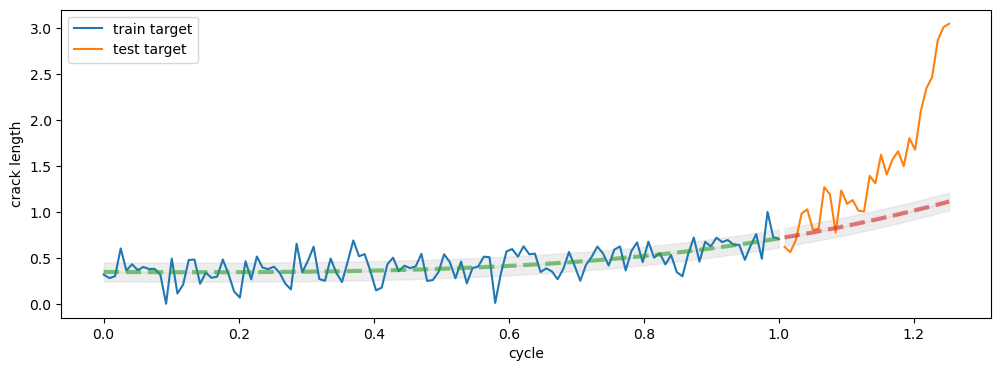

In [436]:
%%time

model_evidential = FullyConnectedEvidential([1, 4, 4], activation=nn.Tanh).to(device)
epochs = 20000
physics_coeff = 1

optim = torch.optim.Adam(model_evidential.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_evidential(model_evidential, train_xtensor, train_ytensor, physics_xtensor, 
        train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
        optim=optim, verbose=True, regularize_coeff=1e-6)

train_mean, train_aleatoric, train_epistemic = predict_evidential(model_evidential, train_xtensor)
test_mean, test_aleatoric, test_epistemic = predict_evidential(model_evidential, test_xtensor)

fig = plot_target_prediction_evidential(train_xtensor, train_ytensor, test_xtensor, test_ytensor, 
    train_mean, train_aleatoric, train_epistemic, test_mean, test_aleatoric, test_epistemic)

## Stein variational gradient descent

https://github.com/hejj16/Stein-Variational-Gradient-Descent-PyTorch/blob/main/Example_of_SVGD.ipynb

https://github.com/shwangtangjun/SVGD-PyTorch/blob/master/svgd.py

https://github.com/LMikeH/svgd-torch/blob/master/svgd_bnn/svgd.py

https://www.cs.utexas.edu/~lqiang/PDF/svgd_aabi2016.pdf

https://www.cs.utexas.edu/~lqiang/PDF/steinslides16.pdf

https://arxiv.org/pdf/1608.04471/pdf


Initialize ${x_i} \sim q_0$ to approximate p(x). Iterative transform $\phi(x)$ as in Normalizing Flow
\begin{align}
x_i \leftarrow x_i + \epsilon \phi(x_i) \\
\phi = \arg \max_{\phi \in F} -\nabla_\epsilon KL[q_{\epsilon \phi} || p]\ |_{\epsilon=0} 
= \arg \max_{\phi \in F} E_{x \sim q} [T_p \phi(x)]
\end{align}

$q_{\epsilon \phi}$ = density of $x' = x + \epsilon \phi(x)$ \
F = set of functions in Reproducing Kernel Hilbert Space with unit norm \
Stein operator $T_p \phi(x) = \nabla_x ln\ p(x) ^T \phi(x) + \nabla_x \phi(x)$ \
With positive definite kernel $k(x, x')$, the optimum is Kernelized Stein Discrepancy

\begin{align}
KSD( q || p) = \max_{\phi \in F} E_{x \sim q} [T_p \phi(x)] \\
\phi^*(x') \propto E_{x \sim q} [T_p\ k(x, x')] = E_{x \sim q} [\nabla_x \log p(x) k(x, x') + \nabla_x k(x, x')] \\
x_i \leftarrow x_i + \epsilon \hat E_{x_i} [\underbrace{\nabla_x \log p(x) . k(x, x_i)}_\text{ascent to high probability} + \underbrace{\nabla_x k(x, x_i)}_\text{repulsive diversity}]
\end{align}

$\hat E_{x_i}[.]$ is empirical average approximation with particle set ${x_i}$

For RBF kernel
\begin{align}
k(x, x_i) = exp(-\frac 1 h || x - x_i ||^2 ) \\
\nabla_x k(x, x_i) = \frac 2 h (x - x_i) k(x, x_i)
\end{align}

Repulsive diversity: Add the difference between particles in the update, scaled by similarity. If strong similarity => add the difference times a big multiplier

In [362]:
t1 = torch.randn((2, 2), requires_grad=True)
t2 = 2 * t1
t3 = 3 * t1
t2.sum().backward()
t3.sum().backward()
t1, t1.grad

(tensor([[-0.6036,  0.6364],
         [ 0.1060,  0.6885]], requires_grad=True),
 tensor([[5., 5.],
         [5., 5.]]))

In [302]:
# https://github.com/shwangtangjun/SVGD-PyTorch/blob/master/svgd.py

def median(tensor):
    """
    torch.median() acts differently from np.median(). We want to simulate numpy implementation.
    """
    tensor = tensor.detach().flatten()
    tensor_max = tensor.max()[None]
    return (torch.cat((tensor, tensor_max)).median() + tensor.median()) / 2.


def kernel_rbf(inputs):
    n = inputs.shape[0]
    pairwise_distance = torch.norm(inputs[:, None] - inputs, dim=2).pow(2)
    h = median(pairwise_distance) / math.log(n)
    kernel_matrix = torch.exp(-pairwise_distance / h)
    return kernel_matrix


def get_gradient(model, inputs):
    n = inputs.size(0)
    inputs = inputs.detach().requires_grad_(True)

    log_prob = model.log_prob(inputs)
    log_prob_grad = torch.autograd.grad(log_prob.sum(), inputs)[0]

    # See https://github.com/activatedgeek/svgd/issues/1#issuecomment-649235844 for why there is a factor -0.5
    kernel = kernel_rbf(inputs)
    kernel_grad = -0.5 * torch.autograd.grad(kernel.sum(), inputs)[0]

    gradient = -(kernel.mm(log_prob_grad) + kernel_grad) / n

    return gradient

In [303]:
# https://github.com/hejj16/Stein-Variational-Gradient-Descent-PyTorch/blob/main/Example_of_SVGD.ipynb

class SVGD:
    def __init__(self, n_particles, n_dim):
        '''
        :param n_particles: int
        :param n_dim: int
        '''
        self.n_particles = n_particles
        self.particles = torch.randn(self.n_particles, n_dim) * 5

    def step(self, target_distribution_logprob, kernel, learning_rate=0.1):
        '''
        :param target_distribution_logprob: pytorch/pyro callable, return log_prob for each input x
        :param kernel: pytorch callable, need to be able to broadcast for one input
        :param learning_rate: float
        :return: None
        '''

        def dlog():
            particles = self.particles.clone().detach()
            particles.requires_grad_()
            torch.sum(target_distribution_logprob(particles)).backward()  # Because sum is linear
            return particles.grad

        def dkernel(x):
            particles = self.particles.clone().detach()
            particles.requires_grad_()
            torch.sum(kernel(particles, x)).backward()
            return particles.grad

        phi = lambda x: torch.mean(kernel(self.particles, x).reshape(-1, 1) * dlog() + dkernel(x), dim=0)
        phis = torch.stack([phi(self.particles[i, :]) for i in range(self.n_particles)], dim=0)
        self.particles = self.particles + learning_rate * phis

        return self.particles



In [354]:
def dlikelihood(initial_particles, target_distribution_logprob):
    particles = initial_particles.clone().detach()
    particles.requires_grad_()
    torch.sum(target_distribution_logprob(particles)).backward()  # Because sum is linear
    return particles.grad

def dkernel(x, initial_particles, kernel):
    particles = initial_particles.clone().detach()
    particles.requires_grad_()
    torch.sum(kernel(particles, x)).backward()
    return particles.grad

def update_particles(particles, target_distribution_logprob, kernel, learning_rate=0.1):
    '''
    :param target_distribution_logprob: pytorch/pyro callable, return log_prob for each input x
    :param kernel: pytorch callable, need to be able to broadcast for one input
    :param learning_rate: float
    :return: None
    '''

    phi = lambda x: torch.mean(kernel(particles, x).reshape(-1, 1) * dlikelihood(particles, target_distribution_logprob) + dkernel(x, particles, kernel), dim=0)
    phis = torch.stack([phi(particles[i, :]) for i in range(particles.shape[0])], dim=0)
    new_particles = particles + learning_rate * phis

    return new_particles

particles = torch.rand((2, 4, 4))
target_logprob = torch.distributions.Normal(1, 2).log_prob
particles, update_particles(particles, target_logprob, rbf_kernel, learning_rate=1)

(tensor([[[0.5006, 0.6503, 0.1981, 0.0371],
          [0.1249, 0.0820, 0.5110, 0.0507],
          [0.9299, 0.5793, 0.2407, 0.6470],
          [0.3892, 0.2866, 0.9109, 0.4828]],
 
         [[0.2405, 0.3912, 0.3939, 0.8480],
          [0.7761, 0.0838, 0.9321, 0.9764],
          [0.7860, 0.9507, 0.6118, 0.1615],
          [0.7616, 0.4329, 0.6777, 0.0427]]]),
 tensor([[[ 0.5577,  0.6999,  0.2136, -0.0158],
          [ 0.0875,  0.1275,  0.4829, -0.0172],
          [ 0.9512,  0.5540,  0.2324,  0.7249],
          [ 0.3733,  0.3039,  0.9444,  0.5632]],
 
         [[ 0.2460,  0.3892,  0.4484,  0.9564],
          [ 0.8682,  0.1296,  0.9879,  1.0927],
          [ 0.7788,  0.9993,  0.6773,  0.1428],
          [ 0.8198,  0.4793,  0.6647,  0.0356]]]))

In [424]:
class GaussianLinearStein(nn.Module):
    def __init__(self, inputsize, outputsize, weight_prior, bias_prior, n_particles):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.weight_prior = weight_prior
        self.bias_prior = bias_prior
        self.n_particles = n_particles
        
        self.weight_mean = nn.Parameter(weight_prior.sample((n_particles, inputsize, outputsize)))
        self.weight_logstd = nn.Parameter(weight_prior.sample((n_particles, inputsize, outputsize)))
        
        self.bias_mean = nn.Parameter(bias_prior.sample((n_particles, 1, outputsize)))
        self.bias_logstd = nn.Parameter(bias_prior.sample((n_particles, 1, outputsize)))

        self.normal01 = td.Normal(0,1)

    def forward(self, inputdata, need_sample=True):
        if not need_sample:
            output = torch.bmm(inputdata.expand(self.n_particles, -1, -1), self.weight_mean) + self.bias_mean
            return output
        
        epsilon_weight = self.normal01.sample(self.weight_mean.shape).to(device)
        epsilon_bias = self.normal01.sample(self.bias_mean.shape).to(device)        
        self.weight = self.weight_mean + torch.log(1 + torch.exp(self.weight_logstd)) * epsilon_weight
        self.bias = self.bias_mean + torch.log(1 + torch.exp(self.bias_logstd)) * epsilon_bias
        # print(f'{inputdata.expand(self.n_particles, -1, -1).shape=} ; {weight.shape=} ; {bias.shape=}')
        output = torch.bmm(inputdata.expand(self.n_particles, -1, -1), self.weight) + self.bias
        return output

class GaussianNetworkStein(nn.Module):
    def __init__(self, layer_size, weight_prior, bias_prior, n_particles, likelihood_std=0.1, activation=nn.Tanh, need_output_exp=False):
        super().__init__()
        self.weight_prior = weight_prior
        self.bias_prior = bias_prior
        self.likelihood_std = torch.tensor(likelihood_std)
        self.need_output_exp = need_output_exp
        self.n_particles = n_particles
        
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(GaussianLinearStein(layer_size[i], layer_size[i+1], weight_prior, bias_prior, n_particles))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            GaussianLinearStein(layer_size[-2], layer_size[-1], weight_prior, bias_prior, n_particles)
        )
        self.mmd = 0
    
    def forward(self, indata, need_sample=True):        
        outdata = indata
        for layer in self.layers:
            if isinstance(layer, GaussianLinearStein):
                outdata = layer(outdata, need_sample)
            else:
                outdata = layer(outdata)
        
        if self.need_output_exp: outdata = torch.exp(outdata)
        
        return outdata

    def forward_sample(inputdata, targetdata, sample_size=10):
        predictions = []
        for samplecount in range(sample_size):
            prediction = self.forward(inputdata)
            predictions.append(prediction)
            
        return torch.stack(predictions, dim=0)
    
    def kernel_backward(self, kernel):
        for layer in self.layers:
            if isinstance(layer, GaussianLinearStein):
                kernel(layer.weight).mean().backward(retain_graph=True)
                kernel(layer.bias).mean().backward(retain_graph=True)

model_stein = GaussianNetworkStein([1, 4, 4, 1], weight_prior=td.Normal(0,1), bias_prior=td.Uniform(-10, 10), 
    n_particles=2, likelihood_std=1, activation=nn.Tanh)
print(model_stein(torch.randn(3, 1)))
model_stein.kernel_backward(kernel_rbf)

tensor([[[ 6.1326],
         [ 6.6495],
         [ 5.9271]],

        [[-5.3902],
         [-5.7082],
         [-5.3765]]], grad_fn=<AddBackward0>)


In [425]:
def compute_data_physics_loss_gaussian_nn_stein(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler, physics_coeff):
    
    data_samples_loglikelihood, physics_samples_loglikelihood = 0., 0.
    inputphysics.requires_grad_(True)
    
    # same sample for data and physics ?
    data_output = model.forward(inputdata)
    physics_output = model.forward(inputphysics)
    # print(f"{data_output.shape = } ; {physics_output.shape = }")
    physics_constraint = 1 * paris_law(outputscaler.inverse(physics_output), paris_C, paris_m, paris_dsigma)    
    # print(f"{data_output.shape = } \n {physics_output.shape = } \n {physics_constraint.shape = }")

    derivative = torch.autograd.grad(outputs=physics_output, inputs=inputphysics, 
        grad_outputs=torch.ones_like(physics_output), retain_graph=True, create_graph=True)[0]
    rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)

    differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
    differential_norm = torch.sum(differential_norm**2)
    data_norm = torch.sum(targetdata**2)
    #         print(f"{data_norm = } {differential_norm = }")

    data_samples_loglikelihood += log_gaussian(data_output/torch.sqrt(data_norm), targetdata/torch.sqrt(data_norm), model.likelihood_std).mean()
    physics_samples_loglikelihood += log_gaussian(rescaled_derivative/torch.sqrt(differential_norm), physics_constraint/torch.sqrt(differential_norm), model.likelihood_std).mean()

    return data_samples_loglikelihood, physics_samples_loglikelihood

In [430]:
def train_model_physics_magnitude_norm_gaussian_nn_stein(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True, divergence_coeff=1):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = {key: np.empty(epochs) for key in "data_loglikelihood physics_loglikelihood".split()}
    model.train()
    
    for epoch in range(epochs):
        
        data_loglikelihood, physics_loglikelihood = compute_data_physics_loss_gaussian_nn_stein(
            paris_C, paris_m, paris_dsigma, model, traininput, trainlabel, physicsinput, 
            xscaler, yscaler, physics_coeff=physics_coeff)
        
        optim.zero_grad()
        data_loglikelihood.backward(retain_graph=True)
        physics_loglikelihood.backward(retain_graph=True)        
        model.kernel_backward(kernel_rbf)
        optim.step()        

        metric["data_loglikelihood"][epoch] = data_loglikelihood.item()
        metric["physics_loglikelihood"][epoch] = physics_loglikelihood.item()
        
#         scheduler.step(loss)
                
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} ") 
            print(f"log likelihood = {data_loglikelihood + physics_loglikelihood} ; {data_loglikelihood = } {physics_loglikelihood = }")
    
    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)
    
    return metric


 Epoch 1 
log likelihood = -2.8822426795959473 ; data_loglikelihood = tensor(-1.9628, grad_fn=<AddBackward0>) physics_loglikelihood = tensor(-0.9194, grad_fn=<AddBackward0>)

 Epoch 101 
log likelihood = -3.363344430923462 ; data_loglikelihood = tensor(-2.4439, grad_fn=<AddBackward0>) physics_loglikelihood = tensor(-0.9194, grad_fn=<AddBackward0>)

 Epoch 201 
log likelihood = -5.498761177062988 ; data_loglikelihood = tensor(-4.5793, grad_fn=<AddBackward0>) physics_loglikelihood = tensor(-0.9194, grad_fn=<AddBackward0>)

 Epoch 301 
log likelihood = -8.325411796569824 ; data_loglikelihood = tensor(-7.4060, grad_fn=<AddBackward0>) physics_loglikelihood = tensor(-0.9194, grad_fn=<AddBackward0>)

 Epoch 401 
log likelihood = -13.980234146118164 ; data_loglikelihood = tensor(-13.0608, grad_fn=<AddBackward0>) physics_loglikelihood = tensor(-0.9194, grad_fn=<AddBackward0>)

 Epoch 501 
log likelihood = -20.73193359375 ; data_loglikelihood = tensor(-19.8125, grad_fn=<AddBackward0>) physics_l

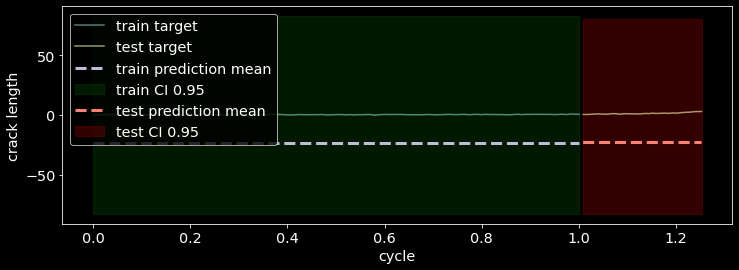

In [433]:
%%time

model_stein = GaussianNetworkStein([1, 4, 4, 1], weight_prior=td.Normal(0,1), bias_prior=td.Uniform(-10, 10), 
    n_particles=10, likelihood_std=1, activation=nn.Tanh)

epochs = 1000
physics_coeff = 1

optim = torch.optim.Adam(model_stein.parameters(), lr=1e-2, weight_decay=1e-6)
metric_stein = train_model_physics_magnitude_norm_gaussian_nn_stein(model_stein, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, divergence_coeff=1e-3)

train_predictions = model_stein(train_xtensor).detach().numpy()
test_predictions = model_stein(test_xtensor).detach().numpy()
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")

# test_mean, test_std = np.mean(test_predictions, 0), np.std(test_predictions, 0)
# uct.viz.plot_calibration(test_mean, test_std, test_ytensor.numpy().squeeze())


In [369]:
for param in model.parameters():
    print(param.shape, kernel_rbf(param))

torch.Size([1, 4]) tensor([[nan]], grad_fn=<ExpBackward0>)
torch.Size([1, 4]) tensor([[nan]], grad_fn=<ExpBackward0>)
torch.Size([1, 4]) tensor([[nan]], grad_fn=<ExpBackward0>)
torch.Size([1, 4]) tensor([[nan]], grad_fn=<ExpBackward0>)
torch.Size([4, 4]) tensor([[1.0000, 0.9880, 0.0041, 0.2557],
        [0.9880, 1.0000, 0.0036, 0.2444],
        [0.0041, 0.0036, 1.0000, 0.0043],
        [0.2557, 0.2444, 0.0043, 1.0000]], grad_fn=<ExpBackward0>)
torch.Size([4, 4]) tensor([[1.0000e+00, 7.5553e-01, 7.7018e-04, 4.2971e-01],
        [7.5553e-01, 1.0000e+00, 3.7671e-05, 1.4545e-01],
        [7.7018e-04, 3.7671e-05, 1.0000e+00, 1.8948e-02],
        [4.2971e-01, 1.4545e-01, 1.8948e-02, 1.0000e+00]],
       grad_fn=<ExpBackward0>)
torch.Size([1, 4]) tensor([[nan]], grad_fn=<ExpBackward0>)
torch.Size([1, 4]) tensor([[nan]], grad_fn=<ExpBackward0>)
torch.Size([4, 1]) tensor([[1.0000, 0.3078, 0.9691, 0.0000],
        [0.3078, 1.0000, 0.2031, 0.0000],
        [0.9691, 0.2031, 1.0000, 0.0000],
      

In [370]:
t1 = torch.randn((3, 1, 4))
t1, kernel_rbf(t1)

(tensor([[[ 1.0848,  1.3573,  0.0661,  1.3923]],
 
         [[ 1.4156,  0.8592,  0.5603, -0.6566]],
 
         [[ 0.7340,  1.1530,  0.9769, -0.7197]]]),
 tensor([[[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
          [2.9279e-01, 6.1750e-02, 6.4473e-02, 3.4231e-21],
          [2.5125e-01, 6.2601e-01, 9.0241e-05, 1.7921e-22]],
 
         [[2.9279e-01, 6.1750e-02, 6.4473e-02, 3.4231e-21],
          [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
          [5.4361e-03, 3.7949e-01, 1.4245e-01, 9.5622e-01]],
 
         [[2.5125e-01, 6.2601e-01, 9.0241e-05, 1.7921e-22],
          [5.4361e-03, 3.7949e-01, 1.4245e-01, 9.5622e-01],
          [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]]]))

In [ ]:
# https://github.com/shwangtangjun/SVGD-PyTorch/blob/master/bayesian_nn.py

'''
Sample code to reproduce results for the Bayesian neural network example.
https://arxiv.org/abs/1502.05336
p(y | W, X, gamma) = prod_i^N  Normal(y_i | f(x_i; W), gamma^-1)
p(W | lambda) = prod_i^N Normal(w_i | 0, lambda^-1)
p(gamma) = Gamma(gamma | a0, b0)
p(lambda) = Gamma(lambda | a0, b0)
    
The posterior distribution is as follows:
p(W, gamma, lambda) = p(y | W, X, gamma) p(W | lambda) p(gamma) p(lambda) 
To avoid negative values of gamma and lambda, we update log(gamma) and log(lambda) instead.

theta=[w1,b1,w2,b2,log(gamma),log(lambda)]
w1: n_features * hidden_dim
b1: hidden_dim
w2: hidden_dim * 1
b2: 1
log(gamma),log(lambda): 1, 1
Actually, every parameter has num_particles rows.

Currently, we can not directly use nn.Module and construct a network, because we have many networks, each parametrized 
by a particle.
'''


class BayesianNN:
    def __init__(self, num_particles):
        self.gamma_prior = Gamma(torch.tensor(1., device=device), torch.tensor(1 / 0.1, device=device))
        self.lambda_prior = Gamma(torch.tensor(1., device=device), torch.tensor(1 / 0.1, device=device))
        self.num_particles = num_particles

    def forward(self, inputs, theta):
        # Unpack theta
        w1 = theta[:, 0:self.n_features * self.hidden_dim].reshape(-1, self.n_features, self.hidden_dim)
        b1 = theta[:, self.n_features * self.hidden_dim:(self.n_features + 1) * self.hidden_dim].unsqueeze(1)
        w2 = theta[:, (self.n_features + 1) * self.hidden_dim:(self.n_features + 2) * self.hidden_dim].unsqueeze(2)
        b2 = theta[:, -3].reshape(-1, 1, 1)
        # log_gamma, log_lambda = theta[-2], theta[-1]

        # num_particles times of forward
        inputs = inputs.unsqueeze(0).repeat(self.num_particles, 1, 1)
        inter = F.relu(torch.bmm(inputs, w1) + b1)
        out = torch.bmm(inter, w2) + b2
        out = out.squeeze()
        return out

    def log_prob(self, theta):
        model_gamma = torch.exp(theta[:, -2])
        model_lambda = torch.exp(theta[:, -1])
        model_w = theta[:, :-2]
        # w_prior should be decided based on current lambda (not sure)
        w_prior = Normal(0, torch.sqrt(torch.ones_like(model_lambda) / model_lambda))

        random_idx = random.sample([i for i in range(self.X_train.shape[0])], self.batch_size)
        X_batch = self.X_train[random_idx]
        y_batch = self.y_train[random_idx]

        outputs = self.forward(X_batch, theta)  # [num_particles, batch_size]
        model_gamma_repeat = model_gamma.unsqueeze(1).repeat(1, self.batch_size)
        y_batch_repeat = y_batch.unsqueeze(0).repeat(self.num_particles, 1)
        distribution = Normal(outputs, torch.sqrt(torch.ones_like(model_gamma_repeat) / model_gamma_repeat))
        log_p_data = distribution.log_prob(y_batch_repeat).sum(dim=1)

        log_p0 = w_prior.log_prob(model_w.t()).sum(dim=0) + self.gamma_prior.log_prob(
            model_gamma) + self.lambda_prior.log_prob(model_lambda)
        log_p = log_p0 + log_p_data * (self.X_train.shape[0] / self.batch_size)  # (8) in paper
        return log_p


def test(model, theta, X_test, y_test):
    prob = model.forward(X_test, theta)
    y_pred = prob.mean(dim=0)  # Average among outputs from different network parameters(particles)

    print(y_pred)
    print(y_test)
    rmse = torch.norm(y_pred - y_test) / math.sqrt(y_test.shape[0])

    print("RMSE: {}".format(rmse))


In [ ]:

def main():
    data = np.loadtxt('data/boston_housing')

    X, y = data[:, :-1], data[:, -1]
    X = torch.from_numpy(X).float().to(device)
    y = torch.from_numpy(y).float().to(device)

    # Normalization
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train_mean, X_train_std = torch.mean(X_train, dim=0), torch.std(X_train, dim=0)
    y_train_mean, y_train_std = torch.mean(y_train, dim=0), torch.std(y_train, dim=0)
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std
    y_train = (y_train - y_train_mean) / y_train_std
    y_test = (y_test - y_train_mean) / y_train_std

    num_particles, batch_size, hidden_dim = 100, 200, 50

    model = BayesianNN(X_train, y_train, batch_size, num_particles, hidden_dim)

    # Random initialization (based on expectation of gamma distribution)
    theta = torch.cat(
        [torch.zeros([num_particles, (X.shape[1] + 2) * hidden_dim + 1], device=device).normal_(0, math.sqrt(10)),
         torch.log(0.1 * torch.ones([num_particles, 2], device=device))], dim=1)

    for epoch in range(2000):
        optimizer = Adam([theta], lr=0.1)
        optimizer.zero_grad()
        theta.grad = get_gradient(model, theta)
        optimizer.step()
        if epoch % 100 == 0:
            test(model, theta, X_test, y_test)

    test(model, theta, X_test, y_test)


if __name__ == '__main__':
    main()

## Bayes by backprop old

In [108]:
# https://www.nitarshan.com/bayes-by-backprop/

class ReparametrizedGaussian():
    def __init__(self, mean, exp_std):
        super().__init__()
        self.mean = mean
        self.exp_std = exp_std
        self.normal01 = torch.distributions.Normal(0,1)
    
    def std(self):
        # std sigma = log( 1 + exp(exp_std) )
        return torch.log1p(torch.exp(self.exp_std))
    
    def sample(self):
        epsilon = self.normal01.sample(self.exp_std.size())
        return self.mean + self.std() * epsilon
    
    def log_prob(self, inputdata):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.std())
                - ((inputdata - self.mean) ** 2) / (2 * self.std() ** 2)).sum()
    
class ScaledMixtureGaussian():
    def __init__(self, weight1, std1, std2):
        super().__init__()
        self.weight1 = weight1
        self.std1 = std1
        self.std2 = std2
        self.gaussian1 = torch.distributions.Normal(0,std1)
        self.gaussian2 = torch.distributions.Normal(0,std2)
    
    def log_prob(self, inputdata):
        prob1 = torch.exp(self.gaussian1.log_prob(inputdata))
        prob2 = torch.exp(self.gaussian2.log_prob(inputdata))
        return (torch.log(self.weight1 * prob1 + (1 - self.weight1) * prob2)).sum()


class BayesianLinear(nn.Module):
    def __init__(self, inputsize, outputsize, mixture_weight=0.5, prior_std1=1, prior_std2=math.exp(-6)):
        super().__init__()
        self.input_size = inputsize
        self.output_size = outputsize
        
        # Weight parameters
        self.weight_mean = nn.Parameter(torch.Tensor(outputsize, inputsize).uniform_(-0.2, 0.2))
        self.weight_reparam_std = nn.Parameter(torch.Tensor(outputsize, inputsize).uniform_(-5,-4))
        # self.weight_gaussian = ReparametrizedGaussian(self.weight_mean, self.weight_exp_std)
        
        # Bias parameters
        self.bias_mean = nn.Parameter(torch.Tensor(outputsize).uniform_(-0.2, 0.2))
        self.bias_reparam_std = nn.Parameter(torch.Tensor(outputsize).uniform_(-5,-4))
        # self.bias_gaussian = ReparametrizedGaussian(self.bias_mean, self.bias_exp_std)
        
        # Prior distributions
        # mixture_weight=0.5
        # prior_std1 = 1
        # prior_std2 = math.exp(-6)
        
        self.weight_prior = ScaledMixtureGaussian(mixture_weight, prior_std1, prior_std2)
        self.bias_prior = ScaledMixtureGaussian(mixture_weight, prior_std1, prior_std2)
        
        self.log_prior = 0
        self.log_proposal = 0

    def forward(self, inputdata, need_sample=False, need_log_probs=False):
        # if self.training or need_sample:
        if need_sample:
            # weight = self.weight_gaussian.sample()
            weight = torch.randn(1).to(device) * reparameterize_std(self.weight_reparam_std) + self.weight_mean
            bias = torch.randn(1).to(device) * reparameterize_std(self.bias_reparam_std) + self.bias_mean
            # bias = self.bias_gaussian.sample()
        else:
            weight = self.weight_mean
            bias = self.bias_mean
        
        # if self.training or need_log_probs:
        self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
        # self.log_proposal = self.weight_gaussian.log_prob(weight) + self.bias_gaussian.log_prob(bias)
        self.log_proposal = log_gaussian_logsigma(weight, self.weight_mean, reparameterize_std(self.weight_reparam_std)).sum() \
            + log_gaussian_logsigma(bias, self.bias_mean, reparameterize_std(self.bias_reparam_std)).sum()
        
#         else:
#             self.log_prior, self.log_proposal = 0, 0

        return tnf.linear(inputdata, weight, bias)

class BayesianNN(nn.Module):
    def __init__(self, layer_size, activation=nn.ReLU, need_output_exp=True):
        super().__init__()
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(BayesianLinear(layer_size[i], layer_size[i+1]))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            BayesianLinear(layer_size[-2], layer_size[-1])
        )
        self.need_output_exp = need_output_exp
        
    def forward(self, indata, need_sample=False):        
        outdata = indata
        for layer in self.layers:
            if isinstance(layer, BayesianLinear):
                outdata = layer(outdata, need_sample)
            else:
                outdata = layer(outdata)
        if self.need_output_exp: outdata = torch.exp(outdata)
        
        return outdata
        # return torch.exp(outdata)
    
    def log_prior(self):
        # logprior = 0
        # for layer in self.layers:
        #     if isinstance(layer, GaussianLinear):
        #         logprior += layer.log_prior
        logprior = sum([layer.log_prior for layer in self.layers if isinstance(layer, BayesianLinear)])
        return logprior
    
    def log_proposal(self):
        # logproposal = 0
        # for layer in self.layers:
        #     if isinstance(layer, GaussianLinear):
        #         logproposal += layer.log_proposal
        logproposal = sum([layer.log_proposal for layer in self.layers if isinstance(layer, BayesianLinear)])
        return logproposal


    """
    def sample_log_prior_proposal(self, indata, targetdata, sample_size):
        outdata = torch.zeros(sample_size)
        log_priors = torch.zeros(sample_size)
        log_proposals = torch.zeros(sample_size)
        
        for i in range(sample_size):
            outdata[i] = self(indata, need_sample=True)
            log_priors[i] = self.log_prior()
            log_proposals[i] = self.log_proposal()
        
        log_prior = log_priors.mean()
        log_proposal = log_proposals.mean()
               
        return outdata, log_prior, log_proposal
"""
    


In [99]:
def compute_data_physics_loss_bayesian_nn(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler, physics_coeff, sample_size=10, likelihood_std=1.):
    
    samples_logprior, samples_logproposal, data_samples_loglikelihood, physics_samples_loglikelihood = 0., 0., 0., 0.
    inputphysics.requires_grad_(True)
    
    for samplecount in range(sample_size):
        data_prediction = model.forward(inputdata, need_sample=True)
        physics_prediction = model.forward(inputphysics, need_sample=True)
        physics_constraint = 1 * paris_law(outputscaler.inverse(physics_prediction), paris_C, paris_m, paris_dsigma)    
        # print(f"{data_prediction = } \n {physics_prediction = } \n {physics_constraint = }")
        
        samples_logprior += model.log_prior()
        samples_logproposal += model.log_proposal()        
#         print(f"{samples_logprior = } {samples_logproposal = }")

        derivative = torch.autograd.grad(outputs=physics_prediction, inputs=inputphysics, 
            grad_outputs=torch.ones_like(inputphysics), retain_graph=True, create_graph=True)[0]
        rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)
        
        differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(targetdata**2)
        #         print(f"{data_norm = } {differential_norm = }")
        
        dataloss = tnf.mse_loss(data_prediction, targetdata)
        physicsloss = physics_coeff * (rescaled_derivative - physics_constraint)**2
        
        # print(f"{log_gaussian(targetdata, data_prediction, model.likelihood_std) = }")
        # data_samples_loglikelihood += log_gaussian(targetdata, data_prediction, model.likelihood_std).mean()
        # physics_samples_loglikelihood += log_gaussian(physics_constraint, rescaled_derivative, model.likelihood_std).mean()
        data_samples_loglikelihood += mse_to_log_gaussian(dataloss / data_norm, likelihood_std).mean()
        physics_samples_loglikelihood += mse_to_log_gaussian(physicsloss / differential_norm, likelihood_std).mean()
#         print(f"{data_samples_loglikelihood = } {physics_samples_loglikelihood = }")
                    
    return samples_logprior/sample_size, samples_logproposal/sample_size, \
        data_samples_loglikelihood/sample_size, physics_samples_loglikelihood/sample_size

In [100]:
def train_model_physics_magnitude_norm_bayesian_nn(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True, sample_size=10, likelihood_coeff=1):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = dict(data_loglikelihood=np.empty(epochs), physics_loglikelihood=np.empty(epochs), 
        logprior=np.empty(epochs), logproposal=np.empty(epochs))
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
        loss = torch.zeros(1)
        
        logprior, logproposal, data_loglikelihood, physics_loglikelihood = compute_data_physics_loss_bayesian_nn(
            paris_C, paris_m, paris_dsigma, model, traininput, trainlabel, physicsinput, 
            xscaler, yscaler, physics_coeff=physics_coeff, sample_size=sample_size)
        loss = (logproposal - logprior) - likelihood_coeff * (data_loglikelihood + physics_loglikelihood)

        metric["data_loglikelihood"][epoch] = data_loglikelihood
        metric["physics_loglikelihood"][epoch] = physics_loglikelihood
        metric["logprior"][epoch] = logprior
        metric["logproposal"][epoch] = logproposal
        
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
                
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f"{logprior = } ; {logproposal = } \n kl = {logproposal - logprior} ; log likelihood = {data_loglikelihood + physics_loglikelihood}")
            print(f"{data_loglikelihood = } {physics_loglikelihood = }")

#             print(f"normalized data loss = {(dataloss / data_norm).detach().item()} ; normalized physics loss = {(physicsloss / differential_norm).detach().item()}")
#             print(f"normalized data loss = {metric['normalized_data_loglikelihood'][epoch].mean()} ; normalized physics loss = {metric['normalized_physics_loglikelihood'][epoch].mean()}")
#             print(f"{data_norm = } {differential_norm = }")

#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

#             fig = plt.figure(figsize=(8,4))
#             plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
#             plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
#             plt.legend()
#             figs.append(fig)
            
#             plt.close()            
            
    # metric["data_loglikelihood"] = metric["data_loglikelihood"].mean(1)
    # metric["physics_loglikelihood"] = metric["physics_loglikelihood"].mean(1)
#     metric["normalized_data_loglikelihood"] = metric["normalized_data_loglikelihood"].mean(1)
#     metric["normalized_physics_loglikelihood"] = metric["normalized_physics_loglikelihood"].mean(1)
    
    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)
    
    return metric

In [101]:
model = BayesianNN([1, 4, 4, 1], activation=nn.Tanh, need_output_exp=True).to(device)
figs=[]
epochs = 4000
physics_coeff = 1
# fig = plt.figure(1, figsize=(12,4))
losses = train_model_debug(model, torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions = sample_prediction(model, torch.cat([train_xtensor, test_xtensor]))
# test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(np.concatenate([train_xscaled, test_xscaled]), np.concatenate([train_yscaled, test_yscaled]), train_predictions, 
                       test_xscaled, test_yscaled, title="train on all data", marker="")


NameError: name 'BayesianNN' is not defined

In [ ]:
model = BayesianNN([1, 4, 4, 1], activation=nn.Tanh, need_output_exp=False).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
metric_mse = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


In [ ]:
model = BayesianNN([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 1000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_bayesian_nn(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, likelihood_coeff=1)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


## vary training size

torch.Size([90, 1]) torch.Size([90, 1]) torch.Size([60, 1]) torch.Size([60, 1])
torch.Size([90, 1]) torch.Size([90, 1]) torch.Size([60, 1]) torch.Size([60, 1])


Text(0.5, 1.0, 'rescaled')

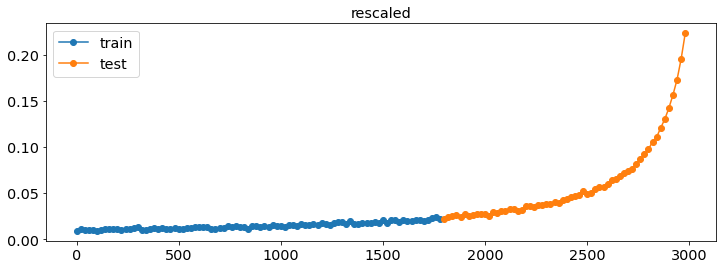

In [90]:
paris_C = np.exp(-23)
paris_m = 4.
paris_dsigma = 75.
paris_a0 = 0.01

train_input, train_target, test_input, test_target = generate_data(paris_C, paris_m, paris_a0, paris_dsigma, trainsize=0.6, 
    startN=0., endN=3000., stepN=20, noise_strength=1e-3)

train_xtensor = totensor(train_input)
train_ytensor = totensor(train_target)
test_xtensor = totensor(test_input)
test_ytensor = totensor(test_target)

print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)

train_xscaler_torch = TorchMinMaxScaler().fit(train_xtensor)
train_yscaler_torch = TorchMinMaxScaler().fit(train_ytensor)

train_xtensor = train_xscaler_torch.forward(train_xtensor)
train_ytensor = train_yscaler_torch.forward(train_ytensor)
test_xtensor = train_xscaler_torch.forward(test_xtensor)
test_ytensor = train_yscaler_torch.forward(test_ytensor)

print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)
plt.figure(figsize=(12, 4))
plt.plot(train_xscaler_torch.inverse(train_xtensor), train_yscaler_torch.inverse(train_ytensor), marker="o", label="train")
plt.plot(train_xscaler_torch.inverse(test_xtensor), train_yscaler_torch.inverse(test_ytensor), marker="o", label="test")
plt.legend()
plt.title("rescaled")


 Epoch 1 loss = 0.10268288850784302
normalized data loss = 0.09268289059400558 ; normalized physics loss = 0.009999999776482582
data_norm = tensor(18.8404) differential_norm = tensor(1.4002e-07, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 0.00034907207009382546
normalized data loss = 0.00028660797397606075 ; normalized physics loss = 6.246409611776471e-05
data_norm = tensor(18.8404) differential_norm = tensor(7.2723e-08, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 0.00023099913960322738
normalized data loss = 0.00022557310876436532 ; normalized physics loss = 5.426025381893851e-06
data_norm = tensor(18.8404) differential_norm = tensor(7.5356e-08, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 0.00022964089293964207
normalized data loss = 0.00022522186918649822 ; normalized physics loss = 4.419019205670338e-06
data_norm = tensor(18.8404) differential_norm = tensor(7.5257e-08, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 0.0002285507071064785
normalized data loss = 0.00022493174765259027 ; 

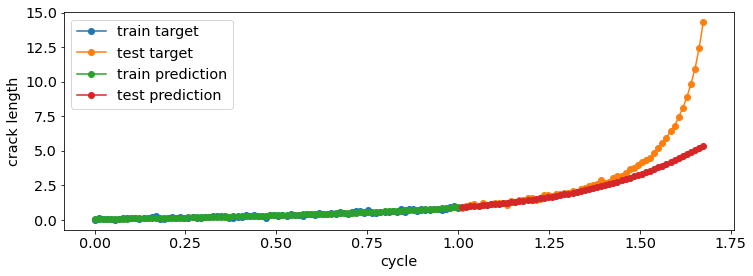

In [91]:
model = FullyConnectedExp([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

torch.Size([105, 1]) torch.Size([105, 1]) torch.Size([45, 1]) torch.Size([45, 1])
torch.Size([105, 1]) torch.Size([105, 1]) torch.Size([45, 1]) torch.Size([45, 1])


Text(0.5, 1.0, 'rescaled')

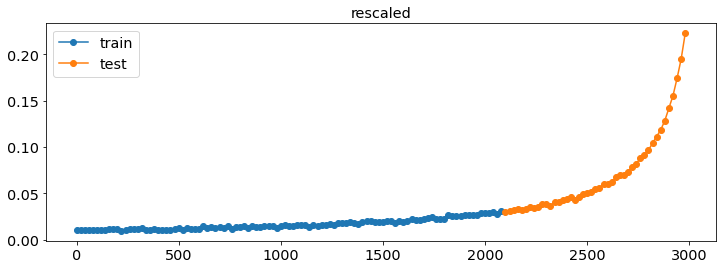

In [92]:
paris_C = np.exp(-23)
paris_m = 4.
paris_dsigma = 75.
paris_a0 = 0.01

train_input, train_target, test_input, test_target = generate_data(paris_C, paris_m, paris_a0, paris_dsigma, trainsize=0.7, 
    startN=0., endN=3000., stepN=20, noise_strength=1e-3)

train_xtensor = totensor(train_input)
train_ytensor = totensor(train_target)
test_xtensor = totensor(test_input)
test_ytensor = totensor(test_target)

print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)

train_xscaler_torch = TorchMinMaxScaler().fit(train_xtensor)
train_yscaler_torch = TorchMinMaxScaler().fit(train_ytensor)

train_xtensor = train_xscaler_torch.forward(train_xtensor)
train_ytensor = train_yscaler_torch.forward(train_ytensor)
test_xtensor = train_xscaler_torch.forward(test_xtensor)
test_ytensor = train_yscaler_torch.forward(test_ytensor)

print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)
plt.figure(figsize=(12, 4))
plt.plot(train_xscaler_torch.inverse(train_xtensor), train_yscaler_torch.inverse(train_ytensor), marker="o", label="train")
plt.plot(train_xscaler_torch.inverse(test_xtensor), train_yscaler_torch.inverse(test_ytensor), marker="o", label="test")
plt.legend()
plt.title("rescaled")


 Epoch 1 loss = 0.029395565390586853
normalized data loss = 0.01939556561410427 ; normalized physics loss = 0.009999999776482582
data_norm = tensor(18.5580) differential_norm = tensor(6.6390e-08, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 9.812735515879467e-05
normalized data loss = 9.46472428040579e-05 ; normalized physics loss = 3.4801109904947225e-06
data_norm = tensor(18.5580) differential_norm = tensor(4.1686e-07, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 9.587969543645158e-05
normalized data loss = 9.362313721794635e-05 ; normalized physics loss = 2.256561629110365e-06
data_norm = tensor(18.5580) differential_norm = tensor(4.2069e-07, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 9.46128202485852e-05
normalized data loss = 9.297331416746601e-05 ; normalized physics loss = 1.6395094917243114e-06
data_norm = tensor(18.5580) differential_norm = tensor(4.2329e-07, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 9.394072549184784e-05
normalized data loss = 9.266241249861196e-05 ; normal

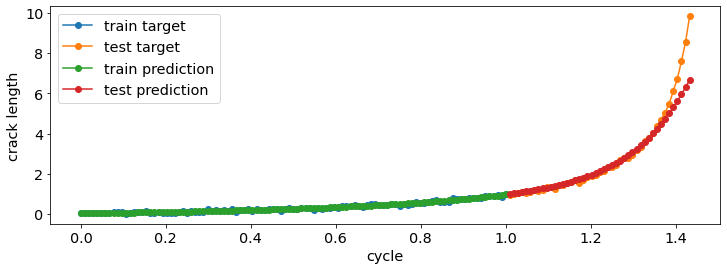

In [93]:
model = FullyConnectedExp([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

## vary noise strength

torch.Size([120, 1]) torch.Size([120, 1]) torch.Size([30, 1]) torch.Size([30, 1])
torch.Size([120, 1]) torch.Size([120, 1]) torch.Size([30, 1]) torch.Size([30, 1])


Text(0.5, 1.0, 'rescaled')

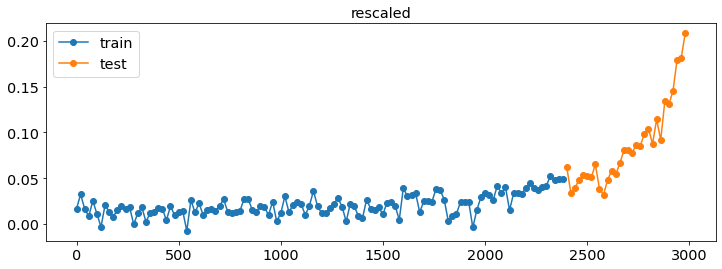

In [94]:
paris_C = np.exp(-23)
paris_m = 4.
paris_dsigma = 75.
paris_a0 = 0.01

train_input, train_target, test_input, test_target = generate_data(paris_C, paris_m, paris_a0, paris_dsigma, trainsize=0.8, 
    startN=0., endN=3000., stepN=20, noise_strength=1e-2)

train_xtensor = totensor(train_input)
train_ytensor = totensor(train_target)
test_xtensor = totensor(test_input)
test_ytensor = totensor(test_target)

print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)

train_xscaler_torch = TorchMinMaxScaler().fit(train_xtensor)
train_yscaler_torch = TorchMinMaxScaler().fit(train_ytensor)

train_xtensor = train_xscaler_torch.forward(train_xtensor)
train_ytensor = train_yscaler_torch.forward(train_ytensor)
test_xtensor = train_xscaler_torch.forward(test_xtensor)
test_ytensor = train_yscaler_torch.forward(test_ytensor)

print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)
plt.figure(figsize=(12, 4))
plt.plot(train_xscaler_torch.inverse(train_xtensor), train_yscaler_torch.inverse(train_ytensor), marker="o", label="train")
plt.plot(train_xscaler_torch.inverse(test_xtensor), train_yscaler_torch.inverse(test_ytensor), marker="o", label="test")
plt.legend()
plt.title("rescaled")


 Epoch 1 loss = 0.025925621390342712
normalized data loss = 0.016101431101560593 ; normalized physics loss = 0.00982419028878212
data_norm = tensor(31.4532) differential_norm = tensor(1.5427e-06, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 0.0007092729792930186
normalized data loss = 0.0006901825545355678 ; normalized physics loss = 1.9090448404313065e-05
data_norm = tensor(31.4532) differential_norm = tensor(3.1537e-06, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 0.0006685760454274714
normalized data loss = 0.0006546151707880199 ; normalized physics loss = 1.3960865544504486e-05
data_norm = tensor(31.4532) differential_norm = tensor(1.1792e-05, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 0.0006618023617193103
normalized data loss = 0.0006500901072286069 ; normalized physics loss = 1.171227813756559e-05
data_norm = tensor(31.4532) differential_norm = tensor(1.9273e-05, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 0.000658695527818054
normalized data loss = 0.0006472279201261699 ; norma

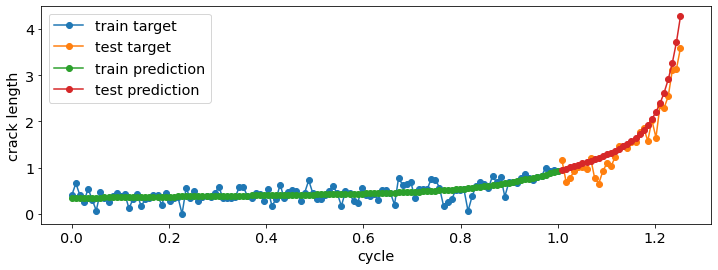

In [95]:
model = FullyConnectedExp([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

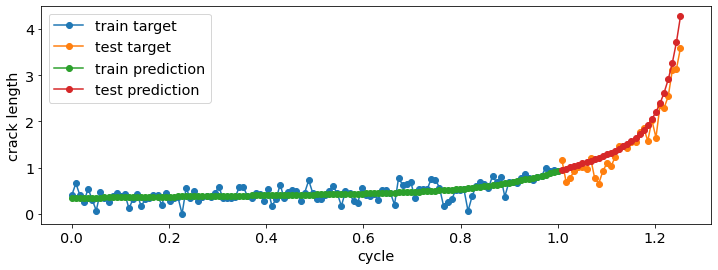

In [96]:
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, figsize=(12, 4))
fig.savefig("prediction.png", bbox_inches="tight")

## harmonic oscillator test

In [43]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


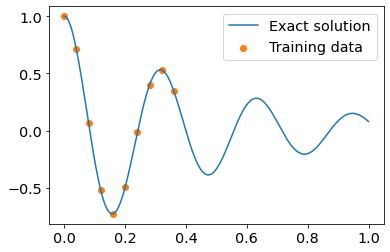

In [44]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()


In [45]:
def plot_result(x,y,x_data,y_data,yh, i,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
#     plt.ylim(-1.1, 1.1)
#     plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

In [46]:
def train_oscillator():

    x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
    mu, k = 2*d, w0**2

    torch.manual_seed(2022)
    model = FullyConnected([1, 32, 32, 32, 1], activation=nn.Tanh)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
    files = []
    epochs=4000
    for i in range(epochs):
        optimizer.zero_grad()

        # compute the "data loss"
        yh = model(x_data)
        loss1 = torch.mean((yh-y_data)**2)# use mean squared error

        # compute the "physics loss"
        yhp = model(x_physics)
        dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
        dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
        physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
        loss2 = (1e-4)*torch.mean(physics**2)

        # backpropagate joint loss
        loss = loss1 + loss2# add two loss terms together
        loss.backward()
        optimizer.step()

        # plot the result as training progresses
#         if (i+1) % 10 == 0: 
        if (i+1) % (epochs//5) == 0: 

            yh = model(x).detach()
            xp = x_physics.detach()

            plot_result(x,y,x_data,y_data,yh, i, xp)
            plt.show()
            fig = plt.figure(figsize=(12, 4))
#             xphysics_plot = x_physics.detach().numpy()
            plt.plot(xp, dx.detach().numpy(), label="dx")
            plt.plot(xp, dx2.detach().numpy(), label="dx2")
            plt.plot(xp, -(mu*dx + k*yhp).detach().numpy(), label="physics law")
            plt.legend()
            figs.append(fig)
#             print(dx)
#             print(dx2, '\n',  mu*dx + k*yhp)
            print(loss1, loss2)
#             file = "plots/pinn_%.8i.png"%(i+1)
#             plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
#             files.append(file)

#             if (i+1) % 200 == 0: plt.show()
#             else: plt.close("all")

In [47]:
figs=[]
# train_oscillator()

## Pyro

In [106]:
# https://www.kaggle.com/code/carlossouza/simple-bayesian-neural-network-in-pyro/notebook
"""
class BayesianNNPyro(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean
"""

'\nclass BayesianNNPyro(PyroModule):\n    def __init__(self, in_features, out_features):\n        super().__init__()\n        self.linear = PyroModule[nn.Linear](in_features, out_features)\n        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))\n        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))\n\n    def forward(self, x, y=None):\n        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))\n        mean = self.linear(x).squeeze(-1)\n        with pyro.plate("data", x.shape[0]):\n            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)\n        return mean\n'

## iterative approximation

In [34]:
def forward_step(initial_value, derivatives): 
    predictions = []
    current_value = initial_value
    for derivative in derivatives:
        predictions.append(current_value + derivative)
        
    return np.array(predictions)


Text(0, 0.5, 'crack length')

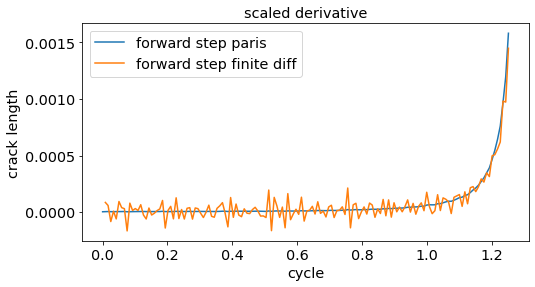

In [35]:

plt.figure(figsize=(8,4))
# plt.plot(all_xscaled[1:], dadN_scaled*(max(train_target) - min(train_target))/(max(train_input) - min(train_input)), label="da/dN")
# plt.plot(all_xscaled, parislaw_rescaled, label="paris law")
plt.plot(all_xscaled, forward_step(0, parislaw_rescaled), label="forward step paris")
plt.plot(all_xscaled[1:], forward_step(0, dadN_scaled*(max(train_target) - min(train_target))/(max(train_input) - min(train_input))), label="forward step finite diff")
plt.legend()
plt.title("scaled derivative")
plt.xlabel("cycle")
plt.ylabel("crack length")

# plt.xlim(0,1)

## linear regression

In [37]:
linreg = sklearn.linear_model.LinearRegression()
linreg.fit(train_input.reshape(-1, 1), train_target.reshape(-1, 1))

LinearRegression()

In [38]:
linreg_train_prediction = linreg.predict(train_input.reshape(-1,1))
linreg_test_prediction = linreg.predict(test_input.reshape(-1,1))

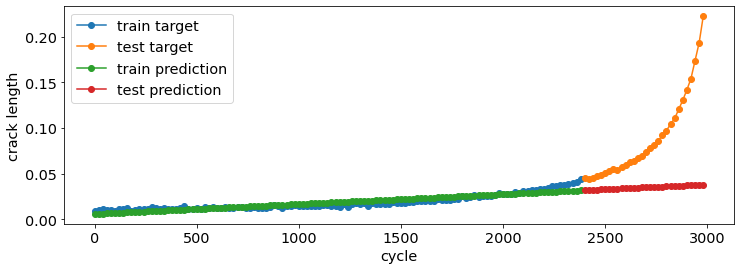

In [39]:
fig = plot_target_prediction(train_input, train_target, linreg_train_prediction, 
                       test_input, test_target, linreg_test_prediction)

## tolerant differential loss

In [1068]:
def tolerant_l2_loss(prediction, target, tolerance):
    mse = tnf.mse_loss(prediction, target, reduction="none")
    loss = torch.max(torch.zeros(1).to(device), mse - tolerance**2 * target**2)
    return torch.mean(loss)

def train_model_physics_tolerant_mse(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    losses = dict(dataloss=[], physicsloss=[])
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
               
        dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
           model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)
        
        tolerant_physicsloss = tolerant_l2_loss(rescaled_derivative, physics_constraint, tolerance=0.01)
        loss = dataloss + physics_coeff * tolerant_physicsloss
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())
        
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f" data loss = {(dataloss).detach().item()} ; tolerant physics loss = {(tolerant_physicsloss).detach().item()}")

#             print(f"physic loss 2 = {physicsloss2.detach().item()}")
#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

            fig = plt.figure(figsize=(8,4))
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
            plt.legend()
            figs.append(fig)
            
            plt.close()            
    return losses


 Epoch 1 loss = 0.036873284727334976
 data loss = 0.036873284727334976 ; tolerant physics loss = 4.719213908543907e-10

 Epoch 1001 loss = 0.018119441345334053
 data loss = 0.018119441345334053 ; tolerant physics loss = 3.648717994408912e-10

 Epoch 2001 loss = 0.018115293234586716
 data loss = 0.018115293234586716 ; tolerant physics loss = 3.947015769778517e-10

 Epoch 3001 loss = 0.018115047365427017
 data loss = 0.018115047365427017 ; tolerant physics loss = 3.9755843062039276e-10

 Epoch 4001 loss = 0.018351422622799873
 data loss = 0.018351422622799873 ; tolerant physics loss = 3.521916369653155e-10

 Epoch 5001 loss = 0.018137488514184952
 data loss = 0.018137488514184952 ; tolerant physics loss = 3.692227634743972e-10

 Epoch 6001 loss = 0.01821591518819332
 data loss = 0.01821591518819332 ; tolerant physics loss = 3.2910502101302086e-10

 Epoch 7001 loss = 0.018022069707512856
 data loss = 0.018022069707512856 ; tolerant physics loss = 3.1955540991113196e-10

 Epoch 8001 loss 

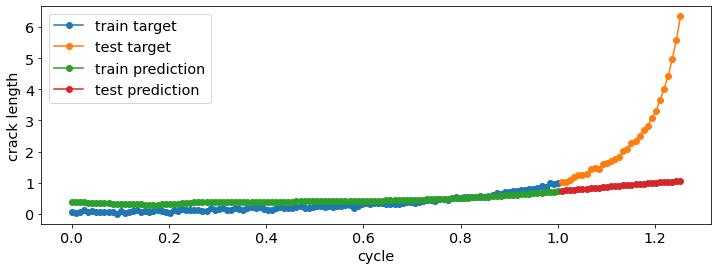

In [1069]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

losses = train_model_physics_tolerant_mse(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)



train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

## Inverse dirichlet loss weight

https://iopscience.iop.org/article/10.1088/2632-2153/ac3712/pdf

In [1070]:
def gradient_variance(loss, model):
    allgrad = torch.tensor([]).to(device)
    for module in model.modules():
        if not isinstance(module, nn.Linear): continue
        weightgrad = torch.autograd.grad(loss, module.weight, retain_graph=True)[0]
        biasgrad = torch.autograd.grad(loss, module.bias, retain_graph=True)[0]
#         print(f"{allgrad.shape = } {weightgrad.shape = } {biasgrad.shape = }")
        allgrad = torch.cat((allgrad, weightgrad.view(-1), biasgrad))
#     print(f"{allgrad.shape = }")

    return torch.std(allgrad)

def dirichlet_weight(dataloss, physicsloss, model, old_dataweight, old_physicsweight, moving_oldcoeff):
    data_gradvar = gradient_variance(dataloss, model)
    physics_gradvar = gradient_variance(physicsloss, model)
#     print(f"{data_gradvar = } {physics_gradvar = }")
    
    # max_gradvar = torch.max(data_gradvar.detach(), physics_gradvar.detach())    
    max_gradvar = torch.max(data_gradvar, physics_gradvar)
    dataweight = max_gradvar / data_gradvar
    physicsweight = max_gradvar / physics_gradvar
#     print(f"{dataweight = } {physicsweight = }")
#     weightedloss =  dataweight * dataloss +  physicsweight * physicsloss
    
    new_dataweight = old_dataweight * moving_oldcoeff + dataweight * (1-moving_oldcoeff)
    new_physicsweight = old_physicsweight * moving_oldcoeff + physicsweight * (1-moving_oldcoeff)
    
    return new_dataweight, new_physicsweight

def train_model_physics_dirichlet(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    losses = dict(dataloss=[], physicsloss=[])
    model.train()
    dataweight = 1; physicsweight = 1
    moving_oldcoeff = 0.5
    
    for epoch in range(epochs):
        optim.zero_grad()
               
        dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
           model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)
        
        dataweight, physicsweight = dirichlet_weight(dataloss, physicsloss, model, dataweight, physicsweight, moving_oldcoeff)
        loss = dataweight * dataloss + physics_coeff * physicsweight * physicsloss
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
        losses["dataloss"].append((dataweight * dataloss).detach().item())
        losses["physicsloss"].append((physics_coeff * physicsweight * physicsloss).detach().item())
        
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
#             print(f"weighted data loss = {(dataweight * dataloss).detach().item()} ; weighted physics loss = {(physicsweight * physicsloss).detach().item()}")
            print(f"weighted data loss = {losses['dataloss'][-1]} ; weighted physics loss = {losses['physicsloss'][-1]}")

            print(f"{dataweight = } {physicsweight = }")

#             print(f"physic loss 2 = {physicsloss2.detach().item()}")
#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

            fig = plt.figure(figsize=(8,4))
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
            plt.legend()
            figs.append(fig)
            
            plt.close()            
    return losses

In [1071]:
# for module in model.modules():
#     if isinstance(module, nn.Linear):
#         print(module.weight.grad)


 Epoch 1 loss = 0.5484089851379395
weighted data loss = 0.5241439938545227 ; weighted physics loss = 0.02426496520638466
dataweight = tensor(1.) physicsweight = tensor(1.3643e+11)

 Epoch 1001 loss = 0.09558746218681335
weighted data loss = 0.08872537314891815 ; weighted physics loss = 0.006862089037895203
dataweight = tensor(1.) physicsweight = tensor(1.5072e+10)

 Epoch 2001 loss = 0.057990193367004395
weighted data loss = 0.04773721471428871 ; weighted physics loss = 0.010252978652715683
dataweight = tensor(1.) physicsweight = tensor(1.8687e+09)

 Epoch 3001 loss = 0.04231680929660797
weighted data loss = 0.03216211870312691 ; weighted physics loss = 0.010154691524803638
dataweight = tensor(1.) physicsweight = tensor(6.4757e+08)

 Epoch 4001 loss = 0.05381068214774132
weighted data loss = 0.04619936645030975 ; weighted physics loss = 0.007611316163092852
dataweight = tensor(1.) physicsweight = tensor(2.7215e+09)

 Epoch 5001 loss = 0.05163545161485672
weighted data loss = 0.0444194

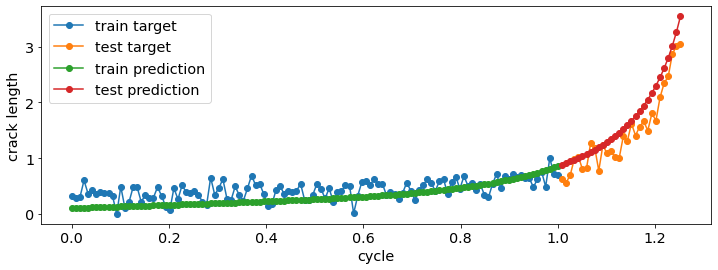

In [1076]:
%%time

model = FullyConnected([1, 4, 4, 1]).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

losses = train_model_physics_dirichlet(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

In [ ]:
figs[-1]

In [ ]:
fig = plot_twinx(np.arange(epochs), losses["dataloss"], "dataloss", losses["physicsloss"], "physicsloss")

In [ ]:
model = FullyConnectedExp([1, 4, 4, 1]).to(device)
figs=[]
epochs = 100
physics_coeff = 1

losses = train_model_physics_dirichlet(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)



train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

In [ ]:
figs[-1]

In [ ]:
fig = plot_twinx(np.arange(epochs), losses["dataloss"], "dataloss", losses["physicsloss"], "physicsloss")

## LBFGS

In [ ]:
# tensor_to_array = lambda tensor: tensor.detach().cpu().numpy().squeeze()
# array_to_tensor = lambda array: torch.tensor(array).to(device)

def train_model_physics_lbfgs_backup(model, traininput, trainlabel, testinput, xscaler, yscaler, 
    C , m, dsigma, epochs=5, physics_coeff=1, verbose=True):
    optim = torch.optim.LBFGS(model.parameters(), lr=1e-3, history_size=10, max_iter=4)
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    testinput = testinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    losses = dict(dataloss=[], physicsloss=[])
    model.train()
    
    for epoch in range(epochs):
        dataloss = None; physicsloss = None; loss = None
        def closure():
            nonlocal dataloss; nonlocal physicsloss; nonlocal loss
            optim.zero_grad()
            outputdata = model(traininput)
    #         predictions = outputdata[0]
    #         print(f"{predictions.shape=}, {trainlabel.shape=}")
            dataloss = tnf.mse_loss(outputdata, trainlabel)

            min_input = min(min(traininput), min(testinput)).detach().item()
            max_input = max(max(traininput), max(testinput)).detach().item()
            xphysics = torch.linspace(min_input, max_input, steps=100).reshape(-1, 1).requires_grad_(True).to(device)        
            yphysics = model(xphysics)       

            derivative = torch.autograd.grad(outputs=yphysics, inputs=xphysics, 
                grad_outputs=torch.ones_like(xphysics), retain_graph=True, create_graph=True)[0]
            physics_constraint = paris_law(yscaler.inverse(yphysics), paris_C, paris_m, paris_dsigma)

            rescaled_derivative = derivative * (yscaler.max - yscaler.min) / (xscaler.max - xscaler.min)
            physicsloss = physics_coeff * torch.mean(torch.pow(rescaled_derivative - physics_constraint, 2))        

            loss = dataloss + physicsloss
            loss.backward()
            
            return loss
        
        optim.step(closure)        
#         scheduler.step(loss)
#         losses["dataloss"].append(dataloss.detach().item())
#         losses["physicsloss"].append(physicsloss.detach().item())

        if epochs < 10 or epoch % (epochs//10) == 0:
#             loss = closure()
#             print(f"Epoch {epoch+1} data loss = {dataloss.detach().item()} ; physics loss = {physicsloss.detach().item()}")
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f"data loss = {dataloss.detach().item()} ; physics loss = {physicsloss.detach().item()}")#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))
#             plt.close()
            
    return losses

In [ ]:
# tensor_to_array = lambda tensor: tensor.detach().cpu().numpy().squeeze()
# array_to_tensor = lambda array: torch.tensor(array).to(device)

def train_model_physics_lbfgs(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    C , m, dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True):
    
    if optim is None:
        optim = torch.optim.LBFGS(model.parameters(), lr=1e-3, history_size=20, max_iter=8)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    losses = dict(dataloss=[], physicsloss=[])
    model.train()
    
    for epoch in range(epochs):
        dataloss = None; physicsloss = None; loss = None
        def closure():
            nonlocal dataloss; nonlocal physicsloss; nonlocal loss
            optim.zero_grad()

            dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
               model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)      
        
            loss = dataloss + physicsloss
            loss.backward()
            
            return loss
        
        optim.step(closure)        
#         scheduler.step(loss)
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())

        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
#             loss = closure()
#             print(f"Epoch {epoch+1} data loss = {dataloss.detach().item()} ; physics loss = {physicsloss.detach().item()}")
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f"data loss = {dataloss.detach().item()} ; physics loss = {physicsloss.detach().item()}")
        #             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))
#             plt.close()
            
    return losses

In [ ]:
model_lbfgs = FullyConnected([1, 16, 16, 1]).to(device)
figs=[]
epochs = 100
physics_coeff=1e6
# fig = plt.figure(1, figsize=(12,4))

# random_seed=2022
# set_random_seed(random_seed)

losses = train_model_physics_lbfgs(model_lbfgs, train_xtensor[:], train_ytensor[:], physics_xtensor[:], 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model_lbfgs, train_xtensor)
test_predictions, test_loss = predict_model(model_lbfgs, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

In [ ]:
model_lbfgs = FullyConnectedExp([1, 16, 16, 1]).to(device)
figs=[]
epochs = 100
physics_coeff=1e6
# fig = plt.figure(1, figsize=(12,4))

# random_seed=2022
# set_random_seed(random_seed)

losses = train_model_physics_lbfgs(model_lbfgs, train_xtensor[:], train_ytensor[:], physics_xtensor[:], 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model_lbfgs, train_xtensor)
test_predictions, test_loss = predict_model(model_lbfgs, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

In [ ]:
model_adam = FullyConnected([1, 16, 16, 1]).to(device)
figs=[]
epochs = 100
physics_coeff=1e9
# fig = plt.figure(1, figsize=(12,4))

# random_seed=2022
# set_random_seed(random_seed)

losses = train_model_physics(model_adam, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)


train_predictions, _ = predict_model(model_adam, train_xtensor)
test_predictions, test_loss = predict_model(model_adam, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

In [ ]:
model_sgd = FullyConnected([1, 4, 4, 1]).to(device)
figs=[]
epochs = 100
physics_coeff=1e10
# fig = plt.figure(1, figsize=(12,4))


# random_seed=2023
# set_random_seed(random_seed)

losses = train_model_physics(model_sgd, train_xtensor[:], train_ytensor[:], physics_xtensor[:], 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=torch.optim.SGD(model_sgd.parameters(), lr=1e-2))

train_predictions, _ = predict_model(model_sgd, train_xtensor)
test_predictions, test_loss = predict_model(model_sgd, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

## constrained optimization

https://cooper.readthedocs.io/en/latest/auto_tutorials/plot_gaussian_mixture.html

In [ ]:
class TwoStepMinimization(cooper.ConstrainedMinimizationProblem):
    def __init__(self, dataloss_max, tolerance, is_constrained=True):
        super().__init__(is_constrained=is_constrained)
        self.dataloss_max = dataloss_max
        self.tolerance = tolerance

    def closure(self, dataloss, physicsloss):
        # |dataloss - maxloss| <= tolerance
        ineq_defect = torch.abs(dataloss - self.dataloss_max) - self.tolerance
#         print(ineq_defect)
        state = cooper.CMPState(
            loss=physicsloss,
            ineq_defect=ineq_defect,
        )
        return state

In [ ]:
def train_constrained_lagrangian(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, dataloss_max, tolerance, epochs=5, physics_coeff=1, verbose=True):
    
    cmp = TwoStepMinimization(dataloss_max=dataloss_max, tolerance=tolerance)
    formulation = cooper.LagrangianFormulation(cmp)

    primal_optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)#, weight_decay=1e-6)
    dual_optimizer = cooper.optim.partial(torch.optim.Adam, lr=1e-2)#, momentum=0.7)

    constrained_optimizer = cooper.ConstrainedOptimizer(
        formulation=formulation,
        primal_optimizer=primal_optimizer,
        dual_optimizer=dual_optimizer,
    )

    losses = dict(dataloss=[], physicsloss=[])
    for epoch in range(epochs):
        constrained_optimizer.zero_grad()
        
        dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
           model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)
        
#         print(dataloss, physicsloss)
        lagrangian = formulation.composite_objective(cmp.closure, dataloss.cpu(), physicsloss.cpu())
        formulation.custom_backward(lagrangian)
        constrained_optimizer.step()
        
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())

        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} ineq_defect = {cmp.closure(dataloss.cpu(), physicsloss.cpu()).ineq_defect}") 
            print(f"data loss = {dataloss.detach().item()} ; physics loss = {physicsloss.detach().item()}")

    return losses

In [ ]:
model = FullyConnected([1, 16, 16, 1]).to(device)
figs=[]
epochs = 100


physics_coeff=1
losses = train_model_physics(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

In [ ]:
physics_coeff=1e10
losses = train_constrained_lagrangian(model, train_xtensor.to(device), train_ytensor.to(device), physics_xtensor.to(device), 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, dataloss_max=0.001, tolerance=0.0005 , epochs=epochs, physics_coeff=physics_coeff,
)
    
train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

In [ ]:
def generate_mog_dataset():
    """
    Generate a MoG dataset on 2D, with two classes.
    """

    n_per_class = 100
    dim = 2
    n_gaussians = 4
    mus = [(0, 1), (-1, 0), (0, -1), (1, 0)]
    mus = [torch.tensor(m) for m in mus]
    var = 0.05

    inputs, labels = [], []

    for id in range(n_gaussians):
        # Generate input data by mu + x @ sqrt(cov)
        cov = np.sqrt(var) * torch.eye(dim)
        mu = mus[id]
        inputs.append(mu + torch.randn(n_per_class, dim) @ cov)

        # Labels
        labels.append(torch.tensor(n_per_class * [1.0 if id < 2 else 0.0]))

    return torch.cat(inputs, dim=0), torch.cat(labels, dim=0)


def plot_pane(ax, inputs, x1, x2, achieved_const, titles, colors):
    const_str = str(np.round(achieved_const, 0)) + "%"
    ax.scatter(*torch.transpose(inputs, 0, 1), color=colors)
    ax.plot(x1, x2, color="gray", linestyle="--")
    ax.fill_between(x1, -2, x2, color=blue, alpha=0.1)
    ax.fill_between(x1, x2, 2, color=red, alpha=0.1)

    ax.set_aspect("equal")
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_title(titles[idx] + " - Pred. Blue Prop.: " + const_str)


class MixtureSeparation(cooper.ConstrainedMinimizationProblem):
    """
    Implements CMP for separating the MoG dataset with a linear predictor.

    Args:
        is_constrained: Flag to apply or not the constraint on the percentage of
            points predicted as belonging to the blue class
        use_proxy: Flag to use proxy-constraints. If ``True``, we use a hinge
            relaxation. Defaults to ``False``.
        const_level: Minimum proportion of points to be predicted as belonging
            to the blue class. Ignored when ``is_constrained==False``. Defaults
            to ``0.7``.
    """

    def __init__(
        self, is_constrained: bool, use_proxy: bool = False, const_level: float = 0.7
    ):

        super().__init__(is_constrained=is_constrained)

        self.const_level = const_level
        self.use_proxy = use_proxy

    def closure(self, model, inputs, targets):

        logits = model(inputs)
        loss = bce_loss(logits.flatten(), targets)

        if not self.is_constrained:
            # Unconstrained problem of separating two classes
            state = cooper.CMPState(
                loss=loss,
            )
        else:
            # Separating classes s.t. predicting at least const_level as class 0

            # Hinge approximation of the rate
            probs = torch.sigmoid(logits)
            hinge = torch.mean(torch.max(torch.zeros_like(probs), 1 - probs))

            # level - proxy_ineq_defect <= 0
            hinge_defect = self.const_level - hinge

            if not self.use_proxy:
                ineq_defect = hinge_defect
                proxy_ineq_defect = None
            else:
                # Use non-proxy defects to update the Lagrange multipliers

                # Proportion of elements in class 0 is the non-proxy defect
                classes = logits >= 0.0
                prop_0 = torch.sum(classes == 0) / targets.numel()
                ineq_defect = self.const_level - prop_0
                proxy_ineq_defect = hinge_defect

            state = cooper.CMPState(
                loss=loss,
                ineq_defect=ineq_defect,
                proxy_ineq_defect=proxy_ineq_defect,
            )

        return state


def train(problem_name, inputs, targets, num_iters=5000, lr=1e-2, const_level=0.7):
    """
    Train via SGD
    """

    is_constrained = problem_name.lower() in ["constrained", "proxy"]
    use_proxy = problem_name.lower() == "proxy"

    model = torch.nn.Linear(2, 1)

    cmp = MixtureSeparation(is_constrained, use_proxy, const_level)
    formulation = cooper.LagrangianFormulation(cmp)

    primal_optimizer = SGD(model.parameters(), lr=lr, momentum=0.7)

    if is_constrained:
        dual_optimizer = cooper.optim.partial(SGD, lr=lr, momentum=0.7)
    else:
        dual_optimizer = None

    constrained_optimizer = cooper.ConstrainedOptimizer(
        formulation=formulation,
        primal_optimizer=primal_optimizer,
        dual_optimizer=dual_optimizer,
    )

    for i in range(num_iters):
        constrained_optimizer.zero_grad()
        if is_constrained:
            lagrangian = formulation.composite_objective(
                cmp.closure, model, inputs, targets
            )
            formulation.custom_backward(lagrangian)
        else:
            # No Lagrangian in the unconstrained case
            loss = cmp.closure(model, inputs, targets).loss
            loss.backward()

        constrained_optimizer.step()

    # Number of elements predicted as class 0 in the train set after training
    logits = model(inputs)
    pred_classes = logits >= 0.0
    prop_0 = torch.sum(pred_classes == 0) / targets.numel()

    return model, 100 * prop_0.item()


# Plot configs
titles = ["Unconstrained", "Constrained", "Proxy"]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Data and training configs
inputs, labels = generate_mog_dataset()
const_level = 0.7
lr = 2e-2
num_iters = 5000

for idx, name in enumerate(titles):

    model, achieved_const = train(
        name, inputs, labels, lr=lr, num_iters=num_iters, const_level=const_level
    )

    # Compute decision boundary
    weight, bias = model.weight.data.flatten().numpy(), model.bias.data.numpy()
    x1 = np.linspace(-2, 2, 100)
    x2 = (-1 / weight[1]) * (weight[0] * x1 + bias)

    # Color points according to true label
    red, blue = style_utils.COLOR_DICT["red"], style_utils.COLOR_DICT["blue"]
    colors = [red if _ == 1 else blue for _ in labels.flatten()]
    plot_pane(axs[idx], inputs, x1, x2, achieved_const, titles, colors)

fig.suptitle("Goal: Predict at least " + str(const_level * 100) + "% as blue")
plt.show()


## loss landscape

In [ ]:
# %matplotlib ipympl

In [ ]:
landscape_step = 40
xlandscape = np.array([[j for j in range(landscape_step)] for i in range(landscape_step)])
ylandscape = np.array([[i for _ in range(landscape_step)] for i in range(landscape_step)])
# print(xlandscape.shape, ylandscape.shape)

In [ ]:
class DataPhysicsLoss(loss_landscapes.metrics.Metric):
#     def __init__(self, xdata, ydata, xphysics, yphysics, physics_coeff):
    def __init__(self, xdata, ydata, xscaler, yscaler, physics_coeff):
        super().__init__()
        self.xdata = xdata
        self.ydata = ydata
#         self.xphysics = xphysics
#         self.yphysics = yphysics
        self.physics_coeff = physics_coeff
        self.xscaler = xscaler
        self.yscaler = yscaler
        
    def __call__(self, model_wrapper):
#         data_prediction = model_wrapper.forward(self.xdata)
#         dataloss = tnf.mse_loss(data_prediction, self.ydata)

        min_input = min(self.xdata).detach().item()
        max_input = max(self.xdata).detach().item()
        xphysics = torch.linspace(min_input, max_input, steps=200).reshape(-1, 1).requires_grad_(True)
#         prediction_physics = model_wrapper.forward(xphysics)       

#         derivative = torch.autograd.grad(outputs=prediction_physics, inputs=xphysics, 
#             grad_outputs=torch.ones_like(xphysics), retain_graph=True, create_graph=True)[0]
#         physics_constraint = paris_law(self.yscaler.inverse(prediction_physics), paris_C, paris_m, paris_dsigma)

#         rescaled_derivative = derivative * (self.yscaler.max - self.yscaler.min) / (self.xscaler.max - self.xscaler.min)
#         physicsloss = self.physics_coeff * torch.mean(torch.pow(rescaled_derivative - physics_constraint, 2))    
        dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
               model_wrapper.forward, self.xdata, self.ydata, xphysics, self.xscaler, self.yscaler, physics_coeff=self.physics_coeff)      
    
        loss = dataloss + physicsloss
        
        return loss.detach().numpy()

In [ ]:
model_lbfgs.eval()
# metric = loss_landscapes.metrics.Loss(tnf.mse_loss, train_xtensor, train_ytensor)
metric = DataPhysicsLoss(train_xtensor, train_ytensor, train_xscaler_torch, train_yscaler_torch, physics_coeff=physics_coeff)
loss_data = loss_landscapes.random_plane(model_lbfgs.cpu(), metric, distance=120, steps=landscape_step, normalization='filter', deepcopy_model=True)

In [ ]:
plt.figure()
plt.contour(loss_data, levels=50)
plt.title('Loss Contours around Model LBFGS')
plt.colorbar()
plt.show()


In [ ]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
surface = ax.plot_surface(xlandscape, ylandscape, loss_data, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Loss Landscape Surface LBFGS')
fig.colorbar(surface)
# fig.show()

In [ ]:
model_adam.eval()
# metric = loss_landscapes.metrics.Loss(tnf.mse_loss, train_xtensor, train_ytensor)
metric = DataPhysicsLoss(train_xtensor, train_ytensor, train_xscaler_torch, train_yscaler_torch, physics_coeff=physics_coeff)
loss_data = loss_landscapes.random_plane(model_adam.cpu(), metric, distance=120, steps=landscape_step, normalization='filter', deepcopy_model=True)

In [ ]:
plt.figure()
plt.contour(loss_data, levels=50)
plt.title('Loss Contours Model Adam')
plt.colorbar()
plt.show()


In [ ]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
surface = ax.plot_surface(xlandscape, ylandscape, loss_data, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Loss Landscape Surface Adam')
fig.colorbar(surface)
# fig.show()

In [ ]:
model.eval()
# metric = loss_landscapes.metrics.Loss(tnf.mse_loss, train_xtensor, train_ytensor)
metric = DataPhysicsLoss(train_xtensor, train_ytensor, train_xscaler_torch, train_yscaler_torch, physics_coeff=physics_coeff)
loss_data = loss_landscapes.random_plane(model.cpu(), metric, distance=120, steps=landscape_step, normalization='filter', deepcopy_model=True)

In [ ]:
plt.figure()
plt.contour(loss_data, levels=50)
plt.title('Loss Contours Model Adam')
plt.colorbar()
plt.show()


In [ ]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
surface = ax.plot_surface(xlandscape, ylandscape, loss_data, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Loss Landscape Surface Adam')
fig.colorbar(surface)
# fig.show()

In [ ]:
# %matplotlib inline

## bayesian optimization basic

In [ ]:
# for name, param in model.named_parameters():
#     print(name, " ; " , param.data)

model.state_dict()

In [ ]:
def build_ax_parameters(model):
    statedict = model.cpu().state_dict()
    allparams = []
    for layername, layerparam in statedict.items():
#         print(layername, layerparam.shape)
        for i, paramvalue in enumerate(layerparam.flatten()):
            allparams.append(dict(
                name=f"{layername}.{i}",
                type="range",
                bounds=[-2.0, 2.0],
                value_type="float"
            ))
    return allparams

# ax_parameters = build_ax_parameters(model)
# pprint(ax_parameters)

In [ ]:
def build_torch_state_dict(axvalues, old_statedict):
    new_statedict = copy.deepcopy(old_statedict)
    statedict = {}
#     pprint(axvalues)
    for paramname, paramvalue in axvalues.items():
        layername = paramname[0:paramname.rfind(".")]
        statedict.setdefault(layername, []).append(paramvalue)
        
    for layername in old_statedict.keys():
#         print(layername)
        new_statedict[layername] = torch.tensor(statedict[layername]).reshape(new_statedict[layername].shape).to(device)
    return new_statedict

In [ ]:
def evaluate_objective(parameters, model, traininput, traintarget, physicsinput, xscaler, yscaler, physics_coeff):
    new_statedict = build_torch_state_dict(parameters, model.state_dict())
#     pprint(new_statedict)
    model.load_state_dict(new_statedict)
#     print(model)
        
    dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
       model.to(device), traininput.to(device), traintarget.to(device), physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)      
        
#     loss = dataloss + physicsloss

    return {"dataphysics": (loss.detach().item(), 0.0)}

def evaluate_multi_objective(parameters, model, traininput, traintarget, physicsinput, xscaler, yscaler, physics_coeff):
    new_statedict = build_torch_state_dict(parameters, model.state_dict())
#     pprint(new_statedict)
    model.load_state_dict(new_statedict)
#     print(model)
        
    dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
       model.to(device), traininput.to(device), traintarget.to(device), physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)      
        
    return dict(
        data=(dataloss.detach().item(), 0.0),
        physics=(1e9 * physicsloss.detach().item(), 0.0),   
    )

In [ ]:
def ax_optimize(axclient, model, traininput, traintarget, physicsinput, xscaler, yscaler, physics_coeff, trials=50):
    for i in range(trials):
        parameters, trial_index = axclient.get_next_trial()
        axclient.complete_trial(
            trial_index=trial_index, 
            raw_data=evaluate_multi_objective(parameters, model, traininput, traintarget, physicsinput, xscaler, yscaler, physics_coeff))



In [ ]:
model_bayesopt = FullyConnected([1, 4, 4, 1]).to(device)

ax_client = AxClient(torch_device=device, verbose_logging=False)
ax_client.create_experiment(
    name="dataphysics",
    parameters=build_ax_parameters(model_bayesopt),
    objectives={
        "data": ObjectiveProperties(minimize=True),
        "physics": ObjectiveProperties(minimize=True),
    },
)

ax_optimize(ax_client, model_bayesopt, train_xtensor, train_ytensor, physics_xtensor,
    train_xscaler_torch, train_yscaler_torch, physics_coeff, trials=200)

In [ ]:
ax_client.get_trials_data_frame()
# ax_client.generation_strategy.trials_as_df

In [ ]:
# ax_parameters, ax_values = ax_client.get_best_parameters()
# # print(f"Best parameters: {parameters}")expected improvement
# print(f"Corresponding mean: {ax_values[0]}, covariance: {ax_values[1]}")

# new_statedict = build_torch_state_dict(ax_parameters, model_bayesopt.state_dict())
# #     pprint(new_statedict)
# model_bayesopt.load_state_dict(new_statedict)


In [ ]:
figs=[]
pareto_front = ax_client.get_pareto_optimal_parameters()
for iteration, result in pareto_front.items():
    new_statedict = build_torch_state_dict(result[0], model_bayesopt.state_dict())
    #     pprint(new_statedict)
    model_bayesopt.load_state_dict(new_statedict)
    train_predictions, _ = predict_model(model_bayesopt, train_xtensor)
    test_predictions, test_loss = predict_model(model_bayesopt, test_xtensor, test_ytensor)

    fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                           test_xscaled, test_yscaled, test_predictions, title=f"dataloss={result[1][0]['data']} physicsloss={result[1][0]['physics']}")
    figs.append(fig)


In [ ]:
train_predictions, _ = predict_model(model_bayesopt, train_xtensor)
test_predictions, test_loss = predict_model(model_bayesopt, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

In [ ]:
render(ax_client.get_contour_plot(metric_name="data"))

In [ ]:
render(ax_client.get_contour_plot("layers.0.weight.2", "layers.0.weight.3"))

In [ ]:
render(ax_client.get_optimization_trace())

In [ ]:
losses = train_model_physics_lbfgs(model_bayesopt, train_xtensor[:], train_ytensor[:], physics_xtensor[:], 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model_bayesopt, train_xtensor)
test_predictions, test_loss = predict_model(model_bayesopt, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")


## bayesian optimization advanced

In [ ]:
gen_strat = GenerationStrategy(
    steps=[
        # 1. Initialization step (does not require pre-existing data and is well-suited for 
        # initial sampling of the search space)
        GenerationStep(
            model=Models.SOBOL,
            num_trials=16,  # How many trials should be produced from this generation step
#             min_trials_observed=3, # How many trials need to be completed to move to next model
            max_parallelism=10,  # Max parallelism for this step
#             model_kwargs={"torch_device": device}
        ),
        # 2. Bayesian optimization step (requires data obtained from previous phase and learns
        # from all data available at the time of each new candidate generation call)
        GenerationStep(
            model=Models.GPEI,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            max_parallelism=3,  # Parallelism limit for this step, often lower than for Sobol
            # More on parallelism vs. required samples in BayesOpt:
            # https://ax.dev/docs/bayesopt.html#tradeoff-between-parallelism-and-total-number-of-trials
        ),
    ]
)


In [ ]:
model_bayesopt = FullyConnected([1, 4, 1]).to(device)

ax_client = AxClient(generation_strategy=gen_strat, verbose_logging=False, torch_device=device)
ax_client.create_experiment(
    name="dataphysics",
    parameters=build_ax_parameters(model_bayesopt),
    objectives={
        "dataphysics": ObjectiveProperties(minimize=True),
    },
)

ax_optimize(ax_client, model_bayesopt, train_xtensor, train_ytensor, physics_xtensor,
    train_xscaler_torch, train_yscaler_torch, physics_coeff, trials=64)

ax_parameters, ax_values = ax_client.get_best_parameters()
# print(f"Best parameters: {parameters}")expected improvement
print(f"Corresponding mean: {ax_values[0]}, covariance: {ax_values[1]}")

new_statedict = build_torch_state_dict(ax_parameters, model_bayesopt.state_dict())
#     pprint(new_statedict)
model_bayesopt.load_state_dict(new_statedict)


train_predictions, _ = predict_model(model_bayesopt, train_xtensor)
test_predictions, test_loss = predict_model(model_bayesopt, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

In [ ]:
epochs=100
losses = train_model_physics(model_bayesopt, train_xtensor[:], train_ytensor[:], physics_xtensor[:], 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model_bayesopt, train_xtensor)
test_predictions, test_loss = predict_model(model_bayesopt, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

## Optimization experiment

In [ ]:
def initialize_result(filepath):
    header = "optimizer,trainloss,physicsloss,testloss,duration_seconds,randomseed\n"
    with open(filepath, "w") as file:
        file.write(header)    
    return header

def append_result(filepath, optimizer, trainloss, physicsloss, testloss, duration, randomseed):
    line = f"{optimizer},{trainloss},{physicsloss},{testloss},{duration},{randomseed}\n"
    with open(filepath, "a") as file:
        file.write(line)
    return line

        

In [ ]:
def run_single_optimizer(train_function, optimname, iteration, resultpath, optim=None):
    starttime = time.time()

    model = FullyConnected([1, 4, 1]).to(device)
    epochs = 100
    physics_coeff=1e10
    
    if optimname == "sgd":
#         print("sgd")
        optim = torch.optim.SGD(model.parameters(), lr=1e-2)

    losses = train_function(model, train_xtensor, train_ytensor, physics_xtensor, train_xscaler_torch, train_yscaler_torch, 
        paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff, optim=optim, verbose=False)
    
    test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
    
    endtime = time.time()
    append_result(resultpath, optimname, losses["dataloss"][-1], losses["physicsloss"][-1],
        test_loss, endtime - starttime, iteration)    

In [ ]:
def run_bayesopt(iteration, resultpath):
    starttime = time.time()
    model = FullyConnected([1, 4, 1]).to(device)
    physics_coeff=1e10

    gen_strat = GenerationStrategy(steps=[
        GenerationStep(model=Models.SOBOL, num_trials=16, max_parallelism=10),
        GenerationStep(model=Models.GPEI, num_trials=-1, max_parallelism=3),
    ])

    ax_client = AxClient(generation_strategy=gen_strat, verbose_logging=False, torch_device=device)
    ax_client.create_experiment(
        name="dataphysics",
        parameters=build_ax_parameters(model),
        objectives={
            "dataphysics": ObjectiveProperties(minimize=True),
        },
    )

    ax_optimize(ax_client, model, train_xtensor, train_ytensor, physics_xtensor,
        train_xscaler_torch, train_yscaler_torch, physics_coeff, trials=64)

    ax_parameters, ax_values = ax_client.get_best_parameters()
    new_statedict = build_torch_state_dict(ax_parameters, model.state_dict())
    model.load_state_dict(new_statedict)

    dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
       model.to(device), train_xtensor.to(device), train_ytensor.to(device), physics_xtensor, 
       train_xscaler_torch, train_yscaler_torch, physics_coeff=physics_coeff)      
    
    test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)

    endtime = time.time()
    append_result(resultpath, "bayesopt", dataloss, physicsloss,
        test_loss, endtime - starttime, iteration)    
    

In [ ]:
def run_double_optimizer(train_function, optimname, iteration, resultpath, optim=None):
    starttime = time.time()
    model = FullyConnected([1, 4, 1]).to(device)
    physics_coeff=1e10

    gen_strat = GenerationStrategy(steps=[
        GenerationStep(model=Models.SOBOL, num_trials=16, max_parallelism=10),
        GenerationStep(model=Models.GPEI, num_trials=-1, max_parallelism=3),
    ])

    ax_client = AxClient(generation_strategy=gen_strat, verbose_logging=False, torch_device=device)
    ax_client.create_experiment(
        name="dataphysics",
        parameters=build_ax_parameters(model),
        objectives={
            "dataphysics": ObjectiveProperties(minimize=True),
        },
    )

    ax_optimize(ax_client, model, train_xtensor, train_ytensor, physics_xtensor,
        train_xscaler_torch, train_yscaler_torch, physics_coeff, trials=64)

    ax_parameters, ax_values = ax_client.get_best_parameters()
    new_statedict = build_torch_state_dict(ax_parameters, model.state_dict())
    model.load_state_dict(new_statedict)
    
    if "sgd" in optimname:
#         print("sgd")
        optim = torch.optim.SGD(model.parameters(), lr=1e-2)
    
    epochs=100
    losses = train_function(model, train_xtensor, train_ytensor, physics_xtensor, train_xscaler_torch, train_yscaler_torch, 
        paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff, optim=optim, verbose=False)
    
    test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
    
    endtime = time.time()
    append_result(resultpath, optimname, losses["dataloss"][-1], losses["physicsloss"][-1],
        test_loss, endtime - starttime, iteration)   

In [ ]:
def run_optimization(iterations, resultpath):
    initialize_result(resultpath)
    
    for iteration in range(iterations):
        set_all_random_seeds(iteration)
        
#         run_single_optimizer(train_model_physics, "adam", iteration, resultpath)
#         run_single_optimizer(train_model_physics, "sgd", iteration, resultpath)
#         run_single_optimizer(train_model_physics_lbfgs, "lbfgs", iteration, resultpath, optim=None)
#         run_bayesopt(iteration, resultpath)
    
#         run_double_optimizer(train_model_physics, "bayesopt->adam", iteration, resultpath, optim=None)
        run_double_optimizer(train_model_physics, "bayesopt->sgd", iteration, resultpath)
#         run_double_optimizer(train_model_physics_lbfgs, "bayesopt->lbfgs", iteration, resultpath, optim=None)

# result_path = "/mnt/beegfs/projects/power-conv/result/optimize.csv"
# run_optimization(10, result_path)